In [1]:
%load_ext autoreload
%autoreload 2 

In [17]:
import os
import torch
import hydra
from tqdm import tqdm
from Bio import SeqIO

import numpy as np
import pickle
import pandas as pd
import re
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.contingency_tables import mcnemar
from sklearn.metrics import roc_curve, auc
from experiment.trainer import auc_cal, precision_cal, recall_cal
from draw_utils import count_gene_kind, count_pfam,  class_dict, class_dict_2, class_to_tensor, tensor_to_columns, tensor_to_classes, compute_confusion_matrix

import math
import json

CURRENT_DIR=os.getcwd()
print(CURRENT_DIR)


/data5_large/home/kechenlu/natural_product/visualization


In [2]:

mpl.rcParams.update({
    'font.size': 8,
    #'font.family': 'sans-serif',
    #'font.sans-serif': ['Arial'],  # Substitute with 'Helvetica' or system default
    'axes.linewidth': .75,
    'axes.labelsize': 9,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    #'xtick.direction': 'in',
    #'ytick.direction': 'in',
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'lines.linewidth': .75,
    'savefig.dpi': 600,
    'pdf.fonttype': 42,  # For editable text in Illustrator
    'ps.fonttype': 42,
})
plt.rcParams['figure.dpi'] = 600

In [3]:
with hydra.initialize(config_path =  os.path.join("..", "configs"), 
                        version_base="1.2"): 
    cfg = hydra.compose(config_name = "dataset" )

## MAC metadata analysis

### Figure 1B upsetplot

/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte

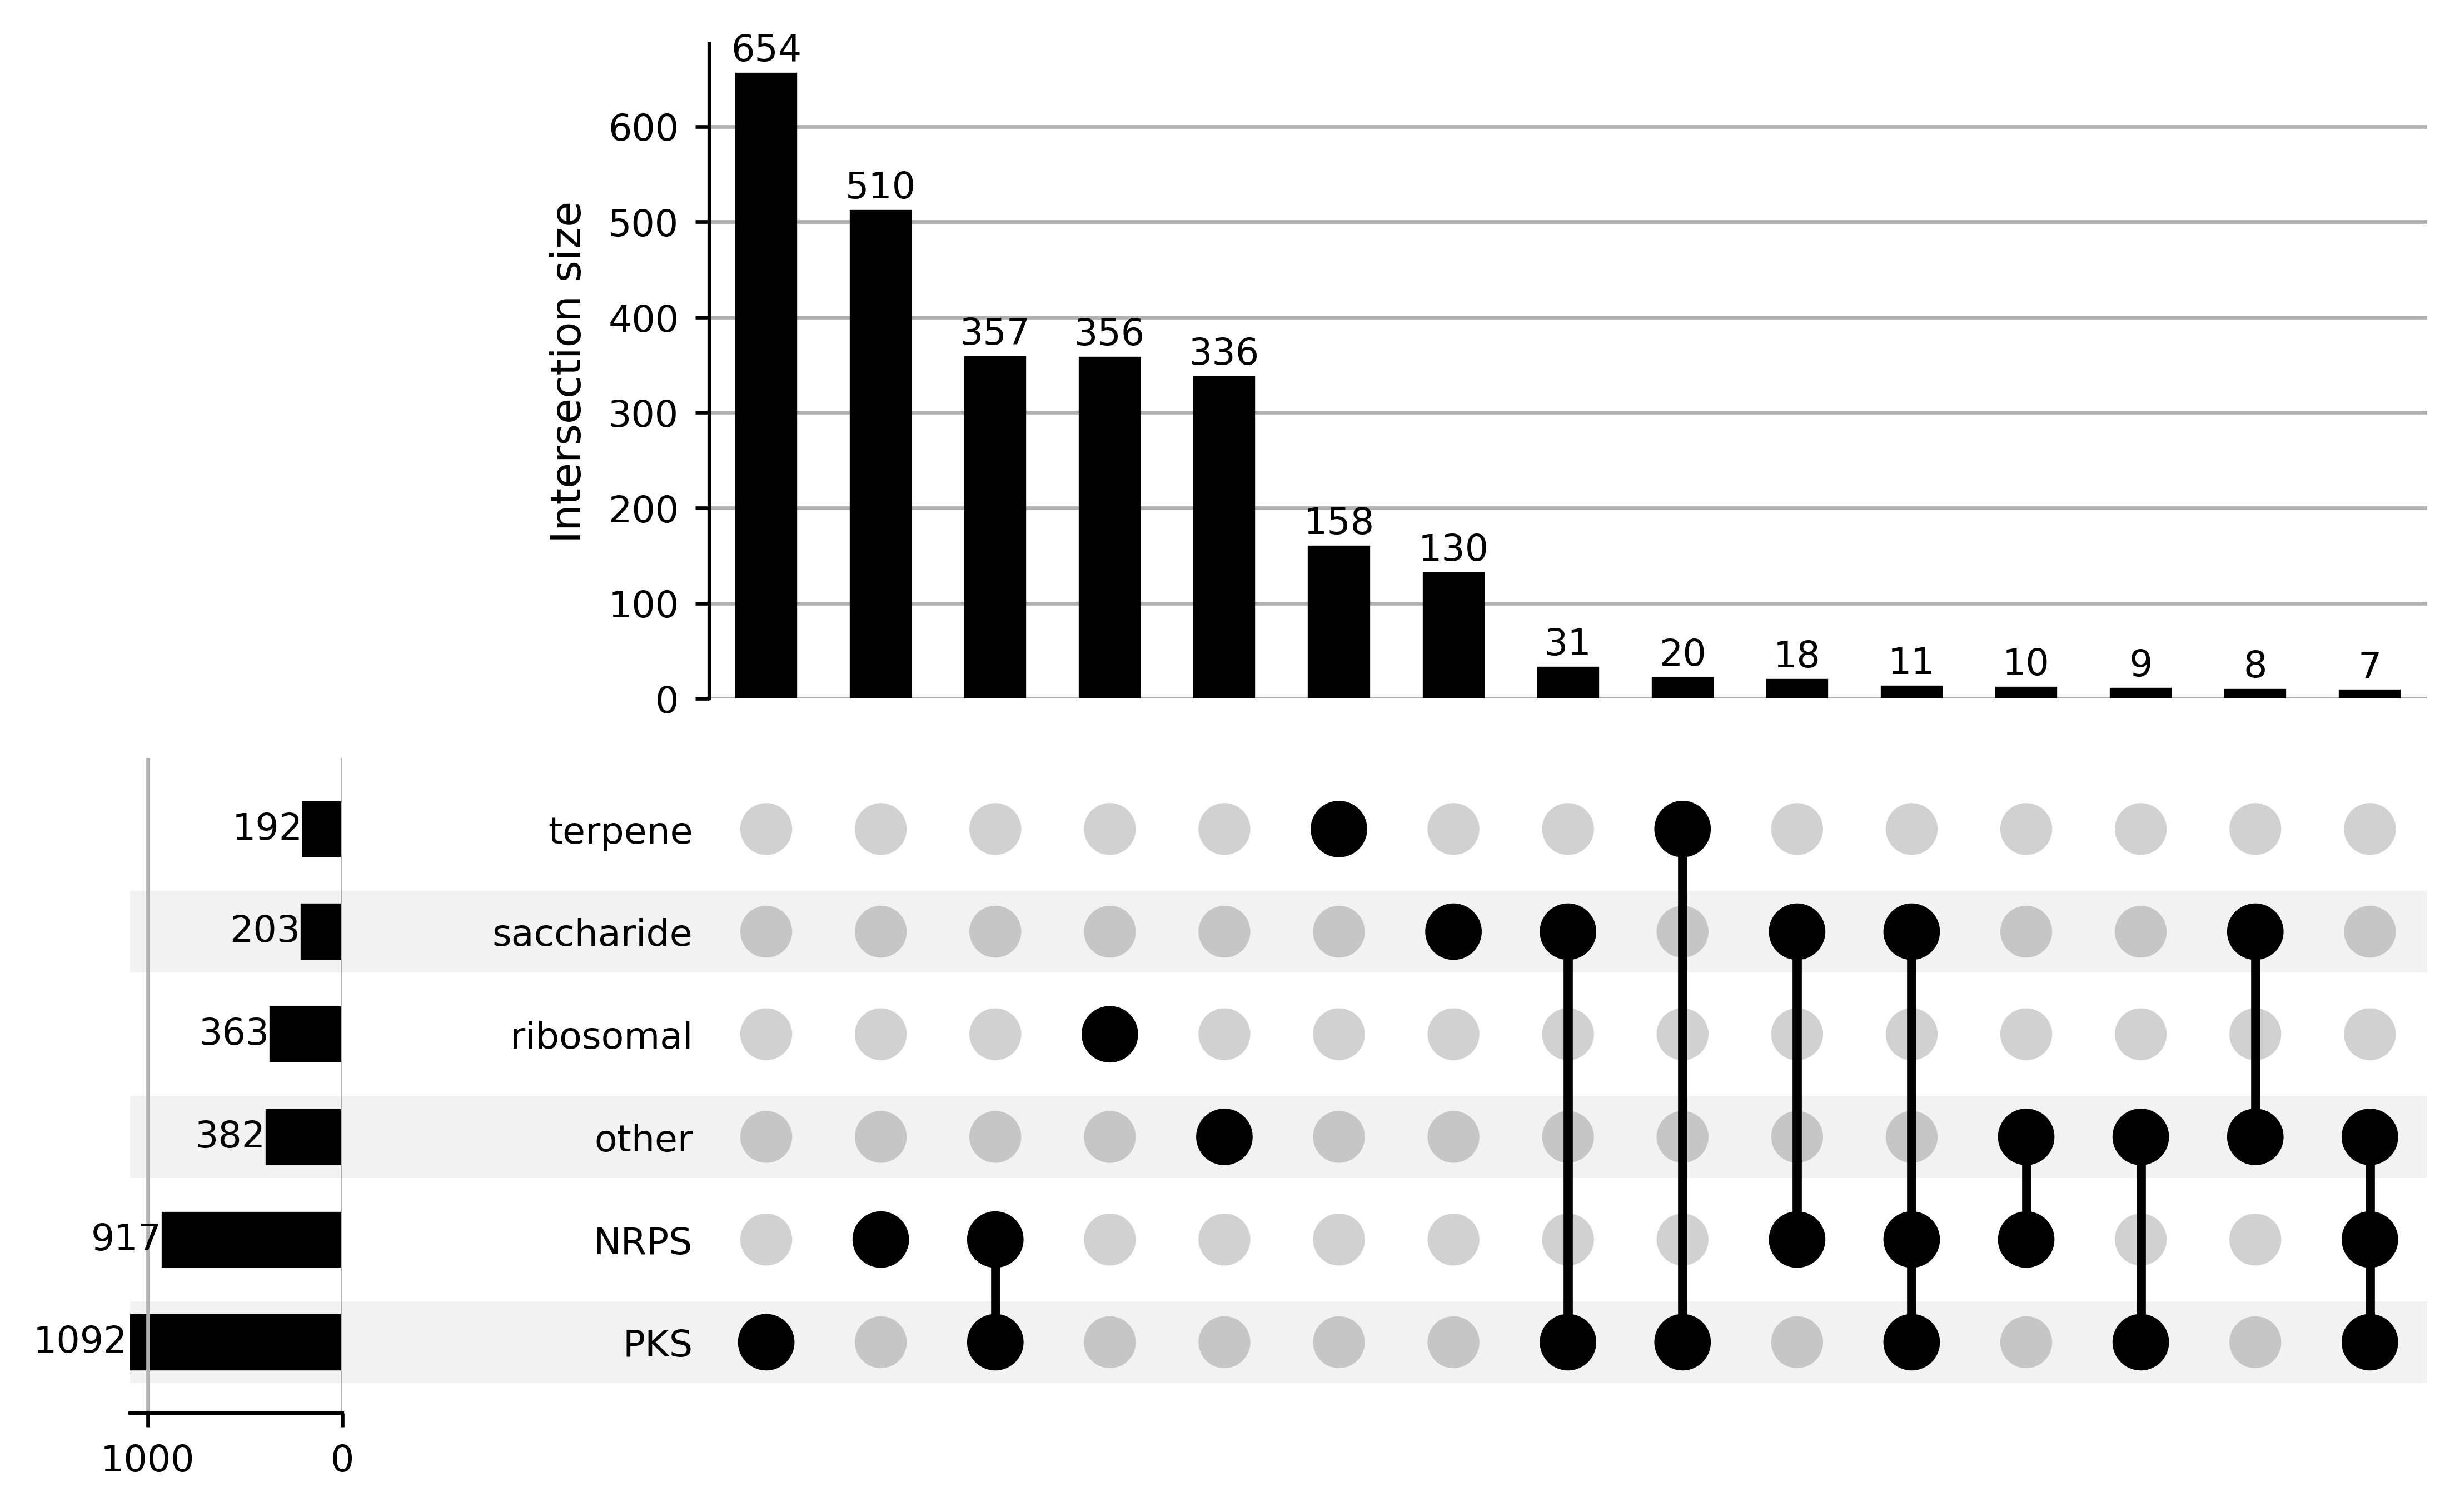

In [4]:
from upsetplot import plot

MAC_metadata = pd.read_pickle("../data/BGC_4.0/MAC_metadata.pkl")
MAC_metadata["biosyn_class_tensor"] = MAC_metadata["biosyn_class"].apply(class_to_tensor, class_dict = class_dict)
tensor = torch.stack(MAC_metadata["biosyn_class_tensor"].to_list())
class_names = list(class_dict)
df = pd.DataFrame(tensor, columns=class_names)
counts = df.groupby(class_names).size()
plot(counts, show_counts=True, min_subset_size=5, sort_by="cardinality")  
plt.savefig(os.path.join("figures", "upsetplot_updated_Fig1B.pdf"), format='pdf')
plt.show() 

### MiBIG metadata check

In [ ]:
# fetch metadata for reviewers
def read_json(json_path):
    # return organism, compound name, compound structure
    data = json.load(open(json_path))

    organism = data["taxonomy"]["name"]
    tax_id = data["taxonomy"]["ncbiTaxId"]
    compounds = [(compound["name"], compound["structure"]) if "structure" in compound else (compound["name"], None) for compound in data["compounds"]]
    return {"BGC_number":data["accession"], "organism": organism, "tax_id": tax_id, "compounds": compounds}

base_dir = "../data/mibig_json_4.0"
json_files = os.listdir(base_dir)

df_list = []
for file in tqdm(json_files):
    try:
        path = os.path.join(base_dir, file)
        data = read_json(path)
        df_list.append(data)
    except Exception as e:
        print(e)
        print(file)
        continue
df = pd.DataFrame(df_list)

100%|██████████| 3013/3013 [00:03<00:00, 958.56it/s]


In [ ]:
# get Number of genes
base_dir = "../data/mibig_gbk_4.0"
gbk_files = os.listdir(base_dir)
BGC_len = {}

def get_num_genes(genbank_file):
    records = SeqIO.parse(genbank_file, "genbank")
    count = 0
    for record in records:
        for feature in record.features:
            if feature.type=="CDS":
                count += 1
    return count

for file in tqdm(gbk_files):
    try:
        path = os.path.join(base_dir, file)
        BGC_number = os.path.basename(file).split(".")[0]
        num_genes = get_num_genes(path)
        BGC_len[BGC_number] = num_genes

    except Exception as e:
        print(e)
        print(file)
        continue


100%|██████████| 2636/2636 [00:24<00:00, 108.12it/s]


In [ ]:
# Get final metadata for upload
mibig_data = pd.read_pickle("../data/BGC_4.0/MAC_metadata.pkl")
mibig_data["num_domain"] = mibig_data["enzyme_list"].apply(len)
mibig_data["num_gene"] = mibig_data["BGC_number"].map(BGC_len)

mibig_data = mibig_data.drop(columns = ["enzyme_list"])
full_data = pd.merge(mibig_data, df, on = "BGC_number", how = "left")
full_data.to_csv("../data/mibig_metadata.csv", index = False)

### BGC-MAC metadata
- Figure S1
- Table S2

In [ ]:
#BGC-MAC random seed = 43
#Each fold
from Bio import Entrez
Entrez.email = "kechenlu.bio@gmail.com"

#Get mapping from BGC number to folding
MAC_metadata = pd.read_pickle("../data/BGC_4.0/MAC_metadata.pkl")
data = MAC_metadata.sample(frac=1, random_state = 43).reset_index(drop=True)
folds = np.array_split(data, 10) 
BGC_number_fold = {}
for i, df in enumerate(folds):
    for BGC in df["BGC_number"].to_list():
        BGC_number_fold[BGC] = i+1

/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [ ]:
#load metadata and map folds

mibig_metadata = pd.read_csv("../data/mibig_metadata.csv")
mibig_metadata["fold"] = mibig_metadata["BGC_number"].map(BGC_number_fold)
mibig_metadata["is_test"] = mibig_metadata["fold"].apply(lambda x:(x==10))


In [ ]:
# Check the species
def get_division(tax_id):
    handle = Entrez.efetch(
        db="taxonomy",
        id=tax_id,
        retmode="xml"
    )
    taxonomy_record = Entrez.read(handle)
    handle.close()

    lineage = taxonomy_record[0]

    return lineage["Division"]

def is_fungi(tax_id):
    handle = Entrez.efetch(
    db="taxonomy",
    id=tax_id,
    retmode="xml"
    )
    taxonomy_record = Entrez.read(handle)
    handle.close()

    lineage = taxonomy_record[0]["Lineage"]

    return "Fungi" in lineage

tax_ids = list(set(mibig_metadata["tax_id"].to_list()))
tax_division = {tax_id: get_division(tax_id) for tax_id in tqdm(tax_ids)}
mibig_metadata["division"] = mibig_metadata["tax_id"].map(tax_division)


  0%|          | 0/1595 [00:00<?, ?it/s]

100%|██████████| 1595/1595 [26:37<00:00,  1.00s/it]


{1703937: 'Bacteria',
 1703938: 'Bacteria',
 2834438: 'Bacteria',
 1703943: 'Bacteria',
 1867796: 'Bacteria',
 2162715: 'Bacteria',
 639005: 'Bacteria',
 639006: 'Bacteria',
 33: 'Bacteria',
 34: 'Bacteria',
 40993: 'Plants and Fungi',
 38: 'Bacteria',
 41: 'Bacteria',
 98346: 'Plants and Fungi',
 43: 'Bacteria',
 45: 'Bacteria',
 1286194: 'Bacteria',
 52: 'Bacteria',
 2056244: 'Bacteria',
 56: 'Bacteria',
 237631: 'Plants and Fungi',
 393283: 'Plants and Fungi',
 69: 'Bacteria',
 925777: 'Bacteria',
 483421: 'Bacteria',
 41061: 'Plants and Fungi',
 41067: 'Plants and Fungi',
 73839: 'Plants and Fungi',
 999541: 'Bacteria',
 999542: 'Bacteria',
 1278073: 'Bacteria',
 204925: 'Bacteria',
 1179773: 'Bacteria',
 2736254: 'Bacteria',
 999550: 'Bacteria',
 49283: 'Bacteria',
 319633: 'Bacteria',
 229533: 'Plants and Fungi',
 229535: 'Plants and Fungi',
 1851571: 'Bacteria',
 197: 'Bacteria',
 352472: 'Invertebrates',
 1433842: 'Bacteria',
 467194: 'Bacteria',
 155900: 'Environmental samples

In [ ]:
# Divide division into Fungi and Plant
plants_fungi_id = []
for tax_id in tax_division:
    if tax_division[tax_id] == "Plants and Fungi":
        plants_fungi_id.append(tax_id)

results = {}
for id in plants_fungi_id:
    result = is_fungi(id)
    print(id, result)
    results[id] = result

tax_bac_fung_pla = {}
for tax_id in tax_division:
    if tax_division[tax_id] == "Plants and Fungi":
        if results[tax_id]:
            tax_bac_fung_pla[tax_id] = "Fungi"
        else:
            tax_bac_fung_pla[tax_id] = "Plant"
    else:
        tax_bac_fung_pla[tax_id] = "Bacteria"
mibig_metadata["Bacteria_Fungi_Plant"] = mibig_metadata["tax_id"].map(tax_bac_fung_pla)

# mibig_metadata = mibig_metadata.drop(columns = ["enzyme_list"])

mibig_metadata.to_csv("../data/mibig_metadata_fold.csv", index = False)


[40993, 98346, 237631, 393283, 41061, 41067, 73839, 229533, 229535, 180498, 41251, 1573173, 573841, 33178, 1892770, 426418, 33203, 426428, 3047880, 655819, 860625, 655844, 1810919, 1491466, 344612, 1450533, 303698, 983644, 1835702, 2163413, 647933, 500485, 180999, 148305, 1229662, 2040732, 1549217, 41900, 1033177, 1131482, 721885, 877550, 1934374, 1729595, 1279085, 2081996, 2041049, 451804, 83212, 378183, 1213857, 34305, 124418, 1287682, 665115, 34381, 1828523, 42742, 42747, 2819868, 1263415, 657443, 1116229, 198730, 321614, 1214568, 690307, 280754, 370937, 2582783, 469280, 665912, 108922, 1460663, 117187, 289240, 510516, 27334, 27339, 264951, 60169, 568076, 994086, 985895, 109376, 150374, 35717, 945030, 306088, 1756125, 330879, 2911399, 77044, 756982, 1813822, 2633043, 331117, 298378, 3469, 413071, 945553, 2502037, 93625, 1813945, 101852, 1986016, 396772, 364010, 3562, 454130, 904690, 192010, 3659, 3702, 2715282, 282267, 1896107, 1707701, 306901, 380704, 36650, 36652, 36656, 61235, 11

In [5]:
# Class distribution for each fold
from collections import defaultdict, Counter
import ast

mibig_metadata = pd.read_csv("../data/mibig_metadata_fold.csv")
mibig_metadata["biosyn_class"] = mibig_metadata["biosyn_class"].apply(ast.literal_eval)
fold_biosyn_dict = defaultdict(list)
fold_organism = defaultdict(list)
fold_genus = defaultdict(list)

for index, row in mibig_metadata.iterrows():
    fold = row['fold']
    biosyn_classes = row['biosyn_class']  
    organism = row["organism"]
    try:
        genus = row["organism"].split()[0]
    except:
        genus = "Unknown"
    fold_biosyn_dict[fold].extend(biosyn_classes)
    fold_organism[fold].append(organism)
    fold_genus[fold].append(genus)

for fold in fold_biosyn_dict:
    print(f"{fold}: {Counter(fold_biosyn_dict[fold])}")
    # print(f"{fold}: {Counter(fold_organism[fold])}")
    # print(f"{fold}: {Counter(fold_genus[fold])}")

5: Counter({'PKS': 125, 'NRPS': 92, 'other': 36, 'ribosomal': 34, 'saccharide': 16, 'terpene': 16})
9: Counter({'PKS': 112, 'NRPS': 91, 'ribosomal': 38, 'other': 32, 'saccharide': 22, 'terpene': 21})
8: Counter({'PKS': 109, 'NRPS': 88, 'ribosomal': 41, 'other': 29, 'terpene': 23, 'saccharide': 21})
6: Counter({'PKS': 105, 'NRPS': 98, 'other': 40, 'saccharide': 24, 'ribosomal': 23, 'terpene': 22})
2: Counter({'PKS': 119, 'NRPS': 96, 'other': 43, 'ribosomal': 26, 'terpene': 20, 'saccharide': 19})
4: Counter({'PKS': 98, 'NRPS': 85, 'ribosomal': 45, 'other': 42, 'terpene': 26, 'saccharide': 15})
1: Counter({'NRPS': 108, 'PKS': 97, 'ribosomal': 39, 'other': 39, 'saccharide': 19, 'terpene': 17})
7: Counter({'PKS': 117, 'NRPS': 92, 'ribosomal': 47, 'other': 25, 'terpene': 18, 'saccharide': 16})
3: Counter({'PKS': 111, 'NRPS': 89, 'other': 44, 'ribosomal': 31, 'saccharide': 26, 'terpene': 12})
10: Counter({'PKS': 99, 'NRPS': 78, 'other': 52, 'ribosomal': 39, 'saccharide': 25, 'terpene': 17})


In [6]:
# Organism Distribution for train and test data
train_org = mibig_metadata[mibig_metadata["fold"] != 10]["organism"].to_list()
test_org = mibig_metadata[mibig_metadata["fold"] == 10]["organism"].to_list()
train_genus = [
    org.strip().split()[0] if org and org.strip() else "Unknown" 
    for org in train_org
]
train_bfp = mibig_metadata[mibig_metadata["fold"] != 10]["Bacteria_Fungi_Plant"].to_list() 
test_bfp = mibig_metadata[mibig_metadata["fold"] == 10]["Bacteria_Fungi_Plant"].to_list() 

test_genus = [org.split()[0] for org in test_org]
train_genus_counter = Counter(train_genus)
test_genus_counter = Counter(test_genus)
train_bfp_counter  = Counter(train_bfp)
test_bfp_counter = Counter(test_bfp)

train_bfp_counter


Counter({'Bacteria': 1895, 'Fungi': 438, 'Plant': 39})

In [10]:
def plot_counter_pie_proportional(counter, ax=None, max_categories=8, figsize=(4, 4), 
                                show_title=True, title=None):

    total = sum(counter.values())
    items = [(label, count) for label, count in counter.items()]
    items.sort(key=lambda x: x[1], reverse=True)
    
    if len(items) <= max_categories:
        main_labels, main_values = zip(*items)
        other_count = 0
    else:
        main_items = items[:max_categories-1]
        other_count = sum(count for label, count in items[max_categories-1:])
        
        if other_count > 0:
            main_items.append(('Other', other_count))
        
        main_labels, main_values = zip(*main_items)
    
    colors = plt.cm.Pastel1(np.linspace(0, 1, len(main_labels)))
    
    labels = [f'{label} ({int(v)})' for label, v in zip(main_labels, main_values)]
    
    # Independent Mode
    if ax is None:  
        plt.figure(figsize=figsize)
        wedges, texts, autotexts = plt.pie(
            main_values,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            explode=[0.1 if i == 0 else 0 for i in range(len(main_labels))]
        )
        
        if show_title and title:
            plt.title(title, fontsize=9, fontweight='bold')
        elif show_title:
            plt.title(f'Category Distribution (Total: {total})', fontsize=9, fontweight='bold')
        
        plt.axis('equal')
        plt.tight_layout()
        #plt.show()

    # Subfigure mode 
    else:  
        wedges, texts, autotexts = ax.pie(
            main_values,
            labels=labels,
            autopct='%1.1f%%',
            startangle=90,
            colors=colors,
            explode=[0.1 if i == 0 else 0 for i in range(len(main_labels))],
            textprops={'fontsize': 7}  
        )
        

        if show_title and title:
            ax.set_title(title, fontsize=10, fontweight='bold', pad=10)
        elif show_title:
            ax.set_title(f'Category Distribution (Total: {total})', fontsize=10, fontweight='bold', pad=10)
        
        ax.axis('equal')
    
    return {
        'main_categories': dict(zip(main_labels, main_values)),
        'other_count': other_count,
        'total': total
    }


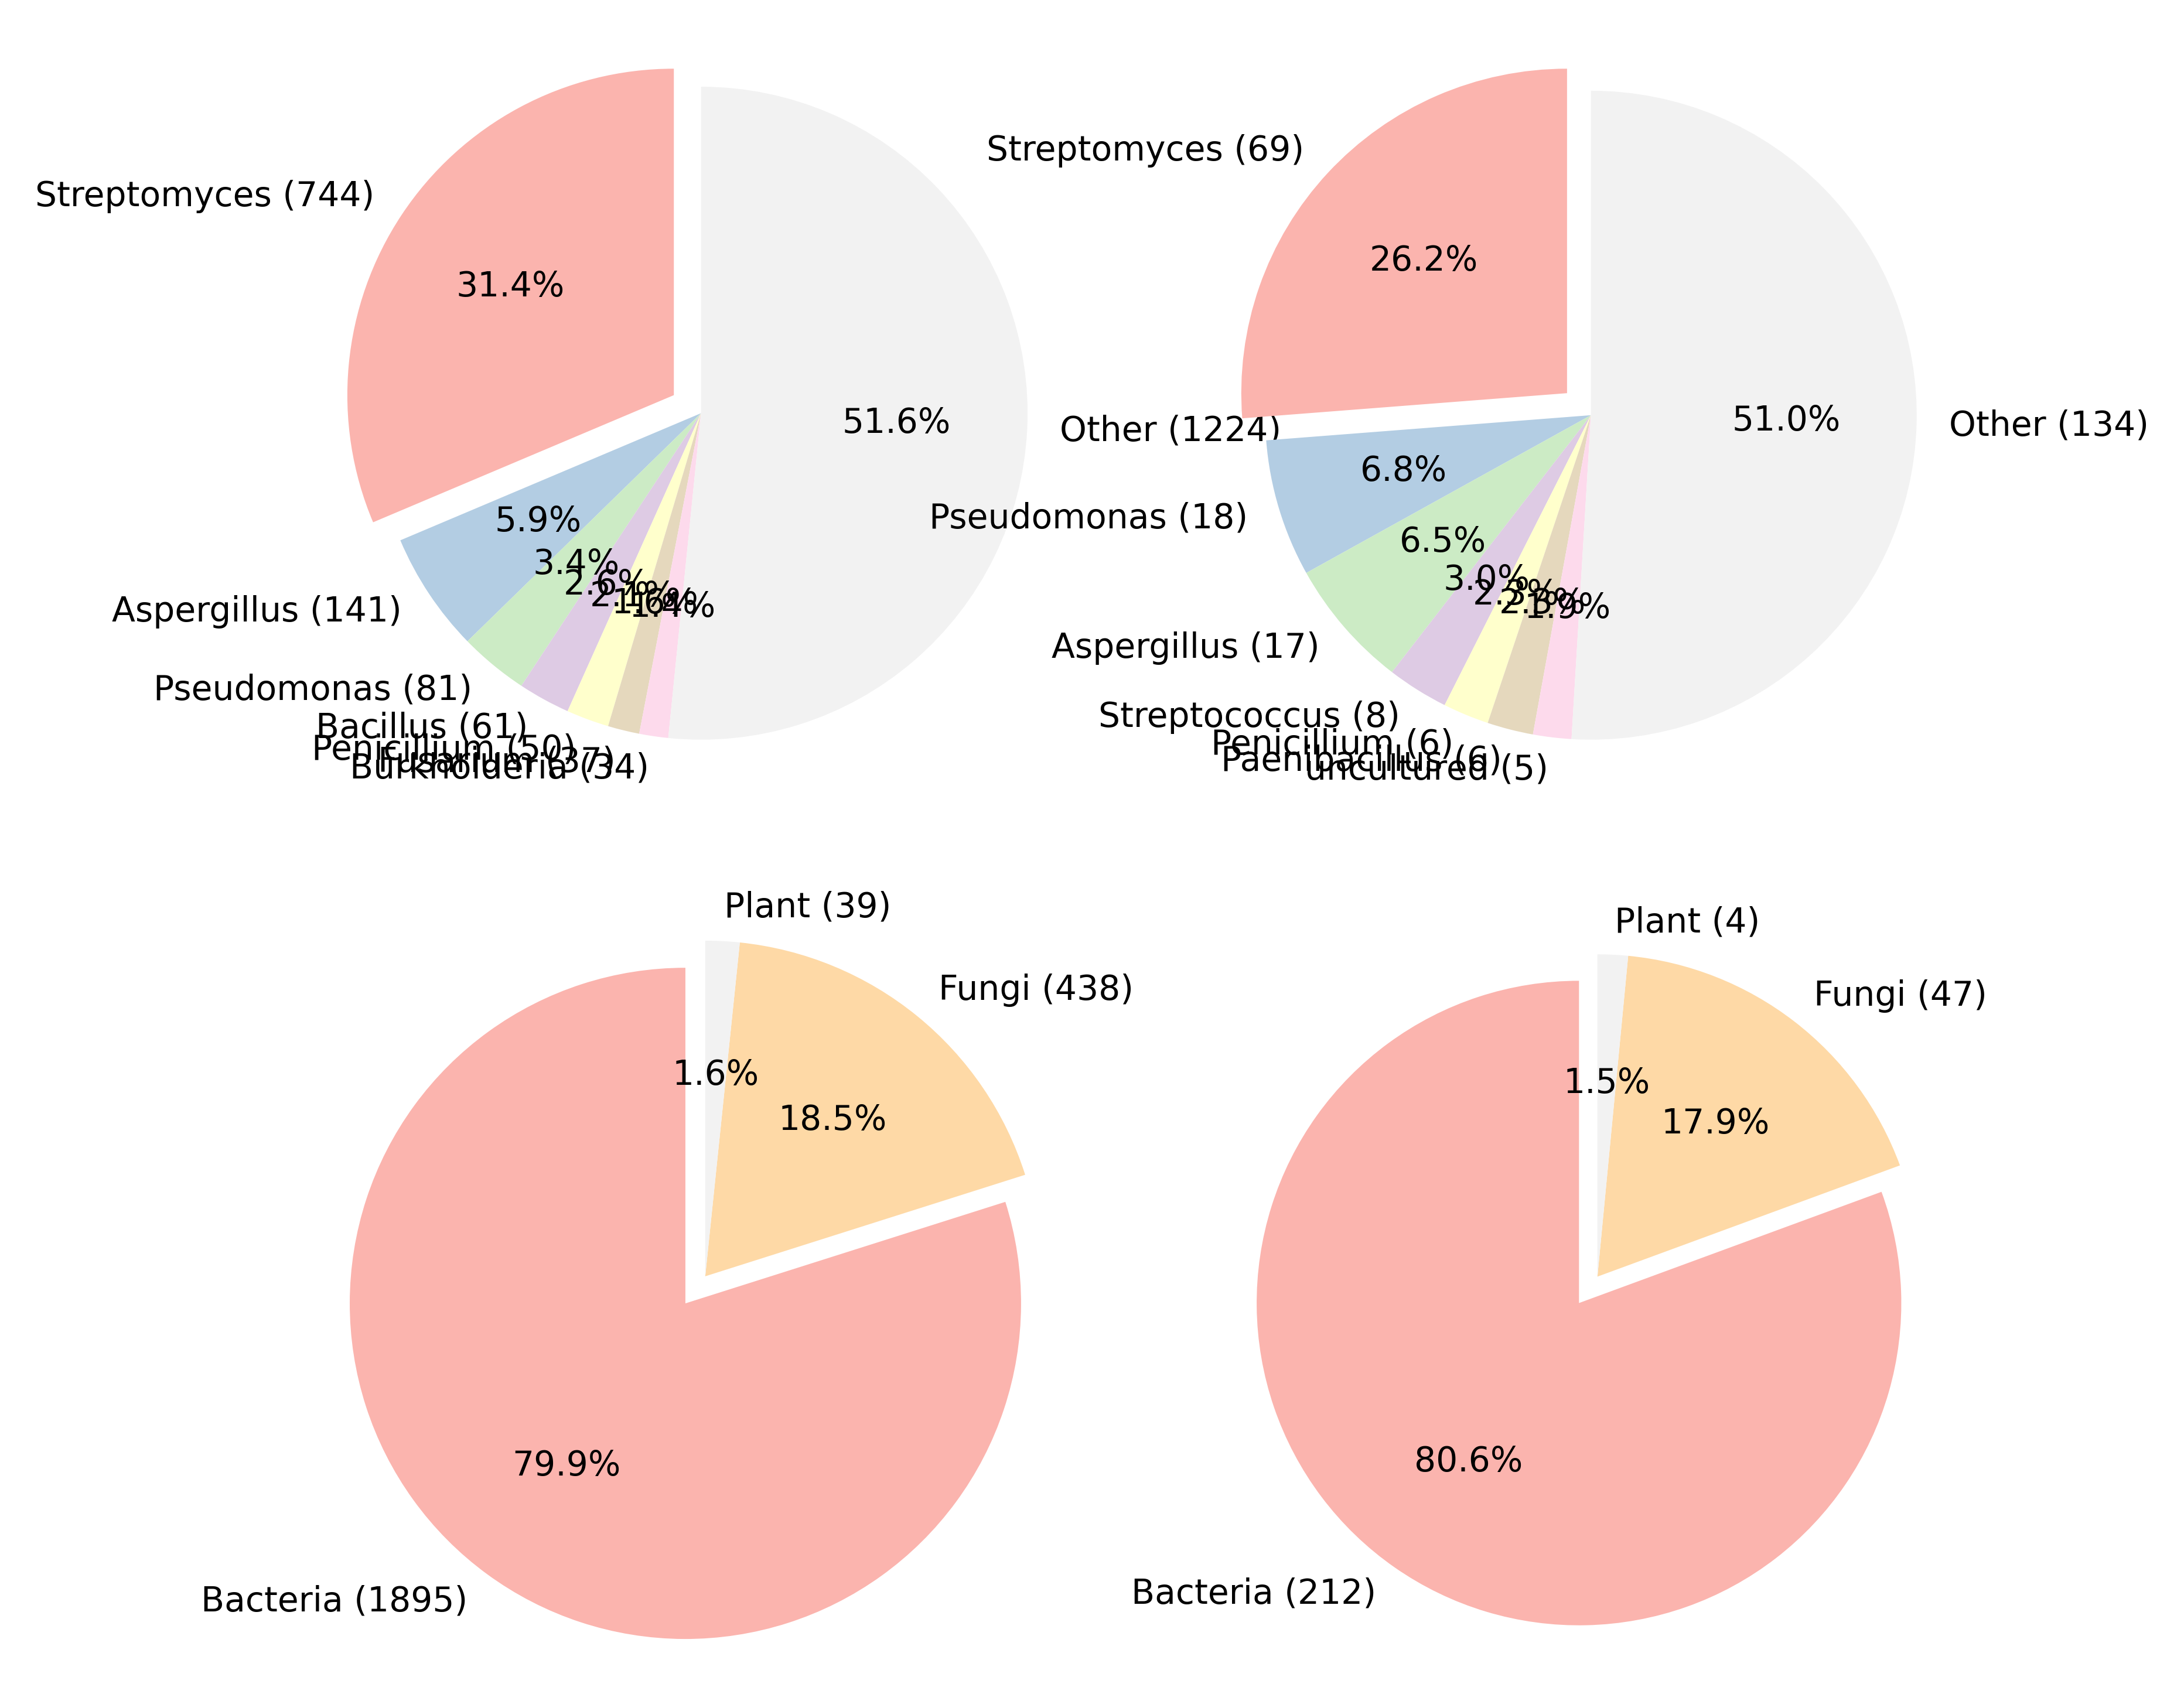

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6))
axes = axes.flatten() 

counters = [ 
train_genus_counter,
test_genus_counter ,
train_bfp_counter ,
test_bfp_counter ]

for i, counter in enumerate(counters):
    plot_counter_pie_proportional(
        counter, 
        ax=axes[i], 
        max_categories=8,  
        show_title=False, 
    )

#plt.savefig(os.path.join("supporting_figs" , "MAC-distribution.pdf"), format='pdf')


### BGC-MAP metadata

In [ ]:
#BGC-MAP random seed = 42
#Each fold information

MAP_metadata = pd.read_pickle("../data/BGC_4.0/MAP_metadata.pkl")

MAP_metadata = MAP_metadata.reset_index(drop=True) 
MAP_metadata['identifier'] = MAP_metadata.index  # add identifier for each pair

data = MAP_metadata.sample(frac=1, random_state=42).reset_index(drop=True)

# get fold information
folds = np.array_split(data, 10)
fold_labels = []
for i, fold_data in enumerate(folds, 1):
    fold_data_copy = fold_data.copy()
    fold_data_copy['fold'] = i
    fold_labels.append(fold_data_copy)

data_with_folds = pd.concat(fold_labels, ignore_index=True)

fold_mapping = dict(zip(data_with_folds['identifier'], data_with_folds['fold']))
MAP_metadata['fold'] = MAP_metadata['identifier'].map(fold_mapping)

MAP_metadata = MAP_metadata.drop('identifier', axis=1)
MAP_metadata = MAP_metadata.drop('enzyme_list', axis=1)

MAP_metadata.to_csv("../data/MAP_metadata_fold.csv", index = False)

/home/kchlu/link_name/miniconda3/envs/natural_product/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Figure S3 AB Taxonomy embedding distribution

In [5]:
mibig_metadata = pd.read_csv("../data/mibig_metadata_fold.csv")
esm_rep = torch.load("../data/BGC_4.0/Esm2_rep_mibig.pth", weights_only = False)
BGC_rep = {k:torch.mean(torch.stack(v), dim=0) for k,v in esm_rep.items()}
mibig_metadata["BGC_rep"] = mibig_metadata["BGC_number"].map(BGC_rep)
mibig_metadata

BGC_number            biosyn_class  num_domain  num_gene  \
0     BGC0000001                 ['PKS']          60        29   
1     BGC0000002                 ['PKS']         136        34   
2     BGC0000003                 ['PKS']          13         6   
3     BGC0000004                 ['PKS']          30        23   
4     BGC0000006                 ['PKS']          30        23   
...          ...                     ...         ...       ...   
2630  BGC0003164  ['NRPS', 'saccharide']          21        19   
2631  BGC0003165  ['NRPS', 'saccharide']          27        26   
2632  BGC0003168  ['NRPS', 'saccharide']          71        44   
2633  BGC0003169                ['NRPS']          38         6   
2634  BGC0003170                ['NRPS']          37         5   

                            organism   tax_id  \
0     Verrucosispora maris AB-18-032   263358   
1         Kutzneria albida DSM 43870  1449976   
2               Alternaria alternata     5599   
3                 Aspergillus oryzae     5062   
4                 Aspergillus flavus     5059   
...                              ...      ...   
2630           Streptomyces  fd1-xmd  1812480   
2631   Streptomyces luteocolor BD-12   285500   
2632        Streptomyces sp. WAC1420  2203203   
2633     Paenibacillus polymyxa PKB1     1406   
2634       Paenibacillus polymyxa M1  1052684   

                                              compounds  fold  is_test  \
0     [('abyssomicin C', 'CC1C[C@]23OC(=O)C4=C2OC1C(...     5    False   
1     [('aculeximycin', 'CCCC(O[C@H]1C[C@](C)(N)[C@H...     5    False   
2     [('AF-toxin', 'CCC(C)C(C(=O)OC(/C=C/C=C/C=C/C(...     9    False   
3     [('aflatoxin G1', 'COC1=C2C3=C(C(=O)OCC3)C(=O)...     9    False   
4     [('aflatoxin B1', 'COc1cc2c(c3oc(=O)c4c(c13)CC...     8    False   
...                                                 ...   ...      ...   
2630  [('streptothricin F', 'NCCC[C@H](N)CC(=O)N[C@@...    10     True   
2631  [('streptothricin BD-12', 'CN(C1C(O)[C@@H](OC(...     9    False   
2632  [('pekiskomycin', 'CO[C@@H]([C@@H](O)[C@@H](O)...     3    False   
2633  [('D-Dab3-polymyxin B1', 'O=C(N[C@@H](CCNC1=O)...    10     True   
2634  [('polymyxin P1', 'O=C(N[C@@H](CCNC1=O)C(N[C@@...     8    False   

              division Bacteria_Fungi_Plant  \
0             Bacteria             Bacteria   
1             Bacteria             Bacteria   
2     Plants and Fungi                Fungi   
3     Plants and Fungi                Fungi   
4     Plants and Fungi                Fungi   
...                ...                  ...   
2630          Bacteria             Bacteria   
2631          Bacteria             Bacteria   
2632          Bacteria             Bacteria   
2633          Bacteria             Bacteria   
2634          Bacteria             Bacteria   

                                                BGC_rep  
0     [tensor(0.0231), tensor(-0.0060), tensor(-0.01...  
1     [tensor(0.0276), tensor(-0.0101), tensor(-0.02...  
2     [tensor(0.0423), tensor(-0.0139), tensor(-0.01...  
3     [tensor(0.0533), tensor(-0.0191), tensor(0.017...  
4     [tensor(0.0533), tensor(-0.0186), tensor(0.019...  
...                                                 ...  
2630  [tensor(0.0430), tensor(0.0017), tensor(0.0293...  
2631  [tensor(0.0376), tensor(0.0070), tensor(0.0343...  
2632  [tensor(0.0405), tensor(0.0113), tensor(0.0080...  
2633  [tensor(0.0408), tensor(0.0155), tensor(-0.045...  
2634  [tensor(0.0398), tensor(0.0148), tensor(-0.047...  

[2635 rows x 12 columns]

In [6]:
from sklearn.manifold import TSNE

embeddings = torch.stack(mibig_metadata["BGC_rep"].tolist())  # 形状: [n_samples, 1280]
embeddings = embeddings.numpy()
labels = mibig_metadata["Bacteria_Fungi_Plant"].values

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

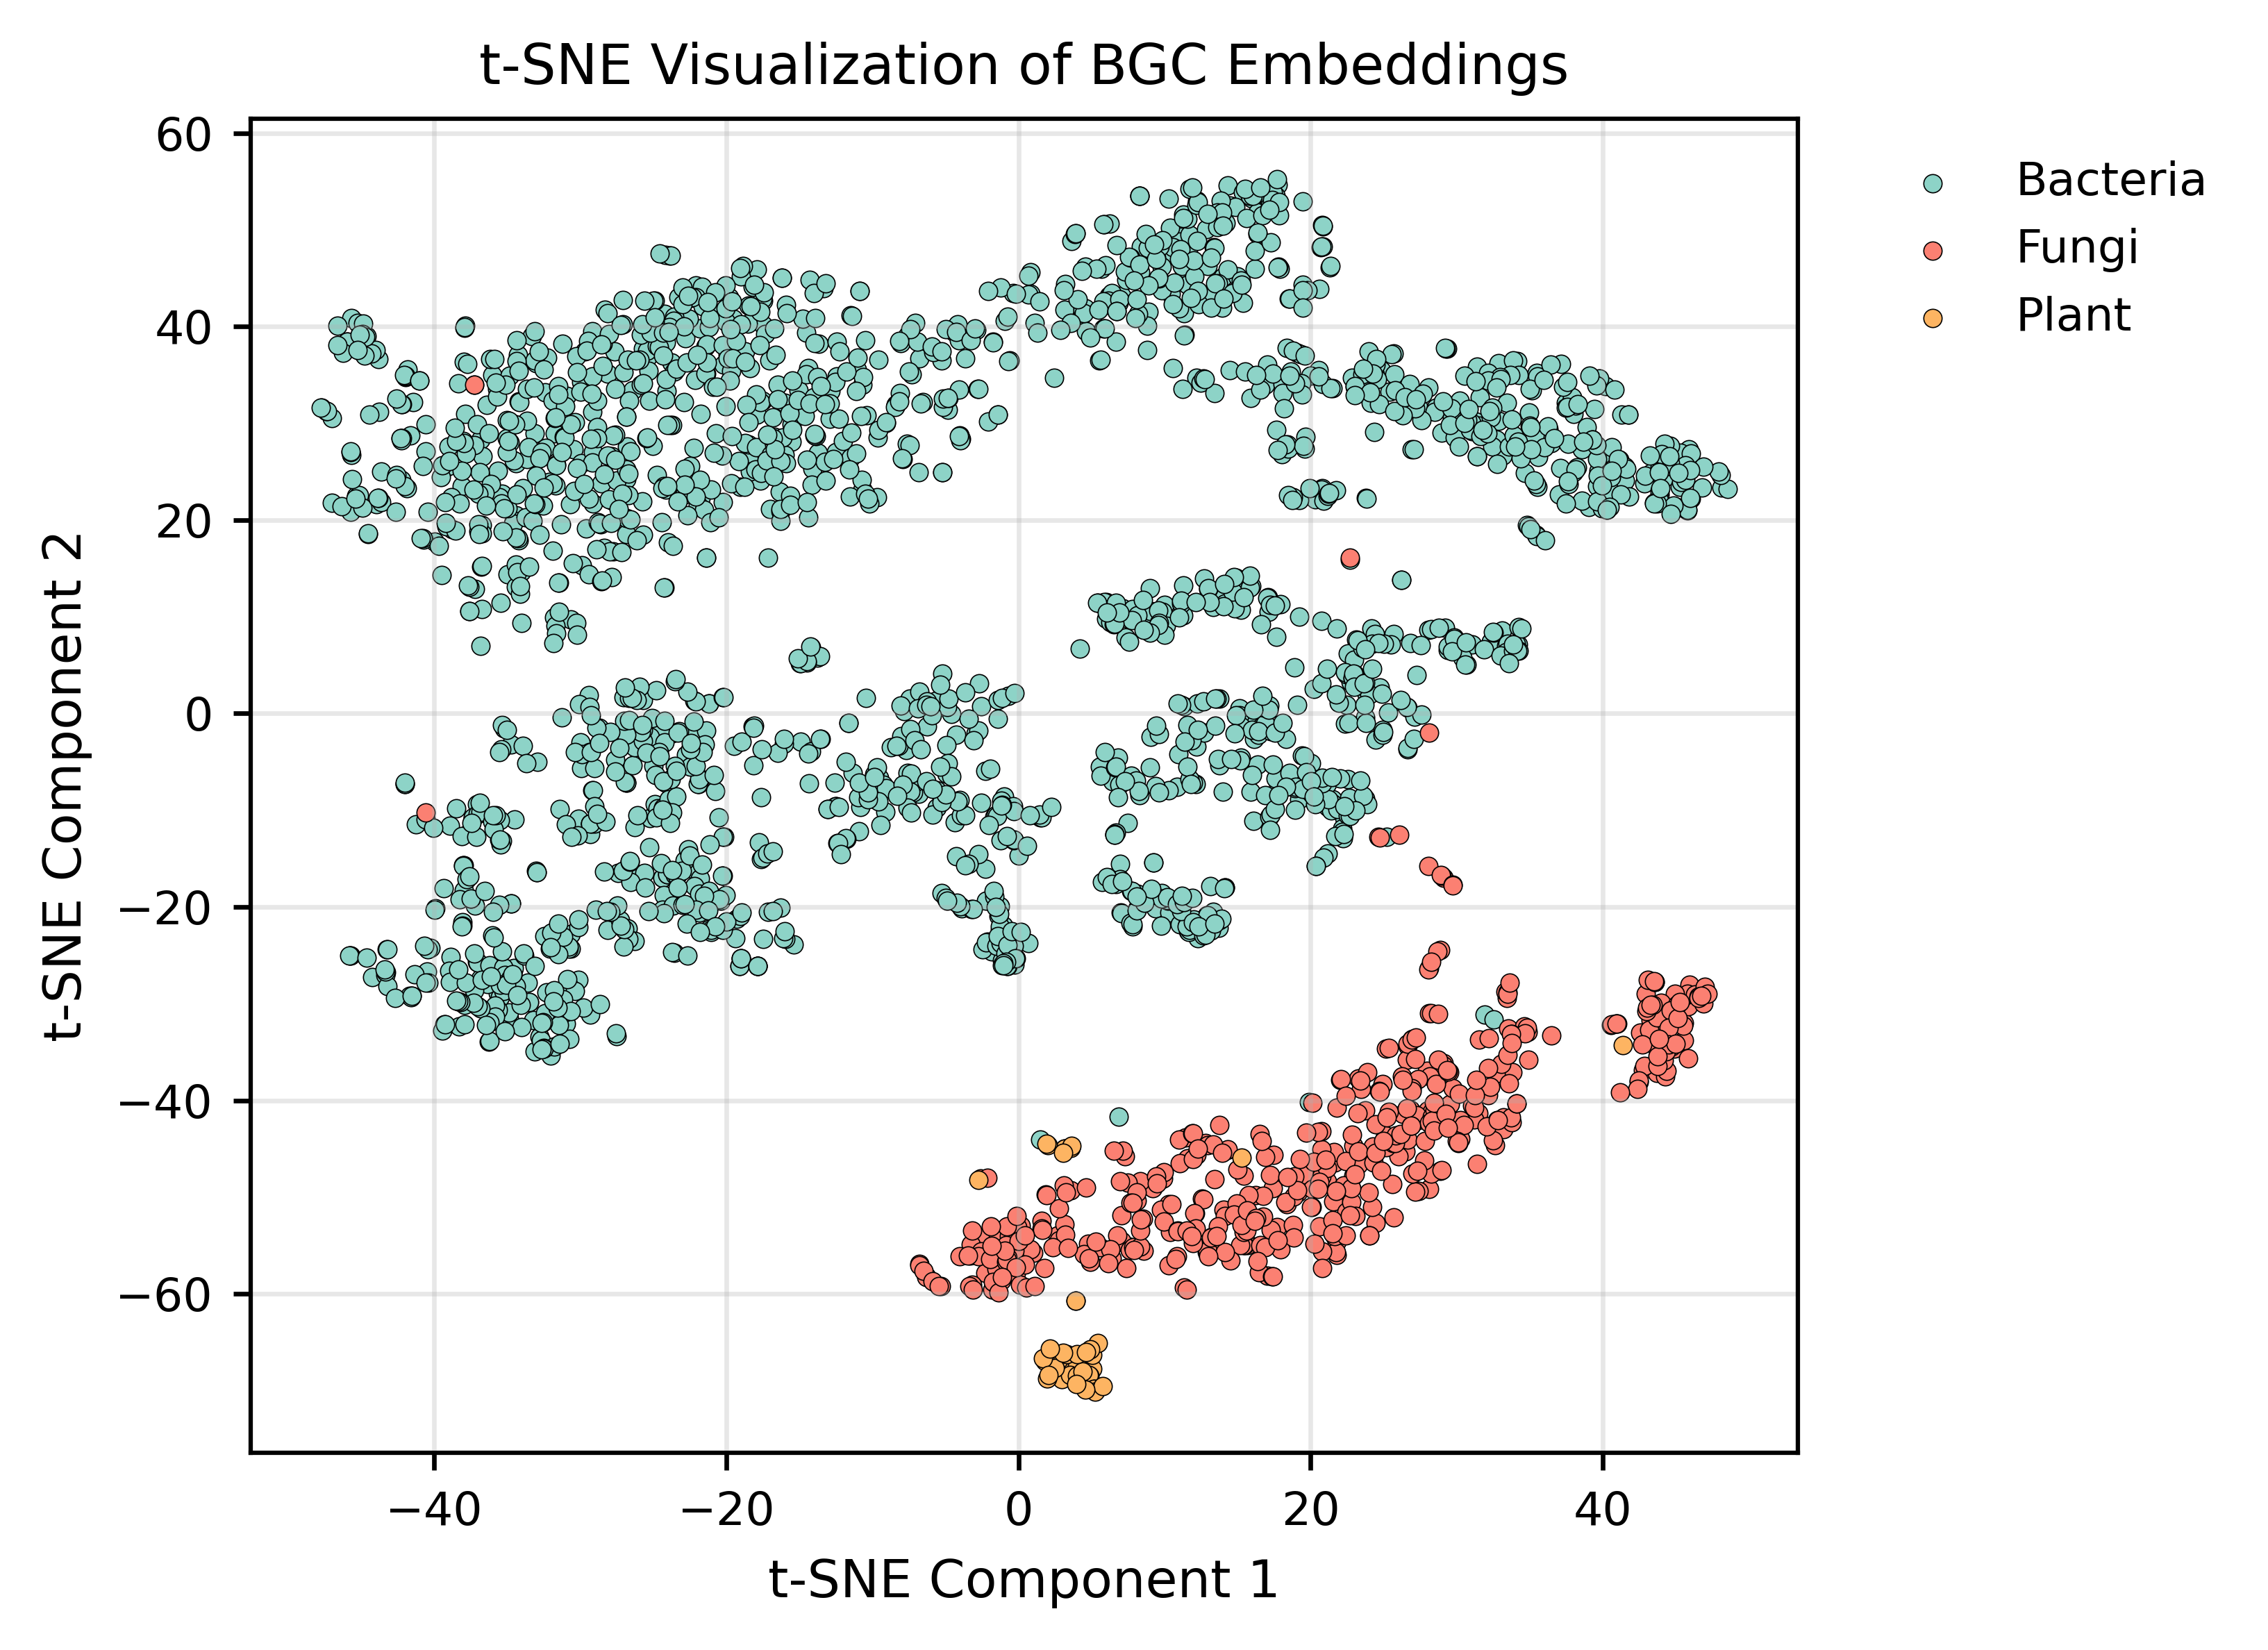

In [7]:

plt.figure(figsize=(5.5, 4))

unique_labels = np.unique(labels)
#colors = plt.cm.Set3(np.linspace(0, 1, len(unique_labels)))
colors = [plt.cm.Set3(i) for i in [0, 3, 5]]

for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(embeddings_2d[mask, 0], embeddings_2d[mask, 1], 
                c=[colors[i]], label=label, alpha=1, s=10, edgecolors = "black", linewidth = 0.2)

plt.title('t-SNE Visualization of BGC Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, alpha=0.3)
#plt.savefig(os.path.join("supporting_figs", "tax_tsne.pdf"), format='pdf')
plt.show()

In [8]:
from collections import Counter
import ast

fungi_BGC = mibig_metadata[mibig_metadata["Bacteria_Fungi_Plant"] == "Fungi"]
fungi_BGC["biosyn_class"] = fungi_BGC["biosyn_class"].apply(ast.literal_eval)
fungi_class = fungi_BGC["biosyn_class"].to_list()

fungi_classes = []
for class_list in fungi_class:
    fungi_classes.extend(class_list)

print(Counter(fungi_classes))

Counter({'PKS': 282, 'NRPS': 170, 'terpene': 90, 'other': 39, 'ribosomal': 5, 'saccharide': 1})


/tmp/ipykernel_3313273/3228854391.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fungi_BGC["biosyn_class"] = fungi_BGC["biosyn_class"].apply(ast.literal_eval)


{'main_categories': {'PKS': 282,
  'NRPS': 170,
  'terpene': 90,
  'other': 39,
  'ribosomal': 5,
  'saccharide': 1},
 'other_count': 0,
 'total': 587}

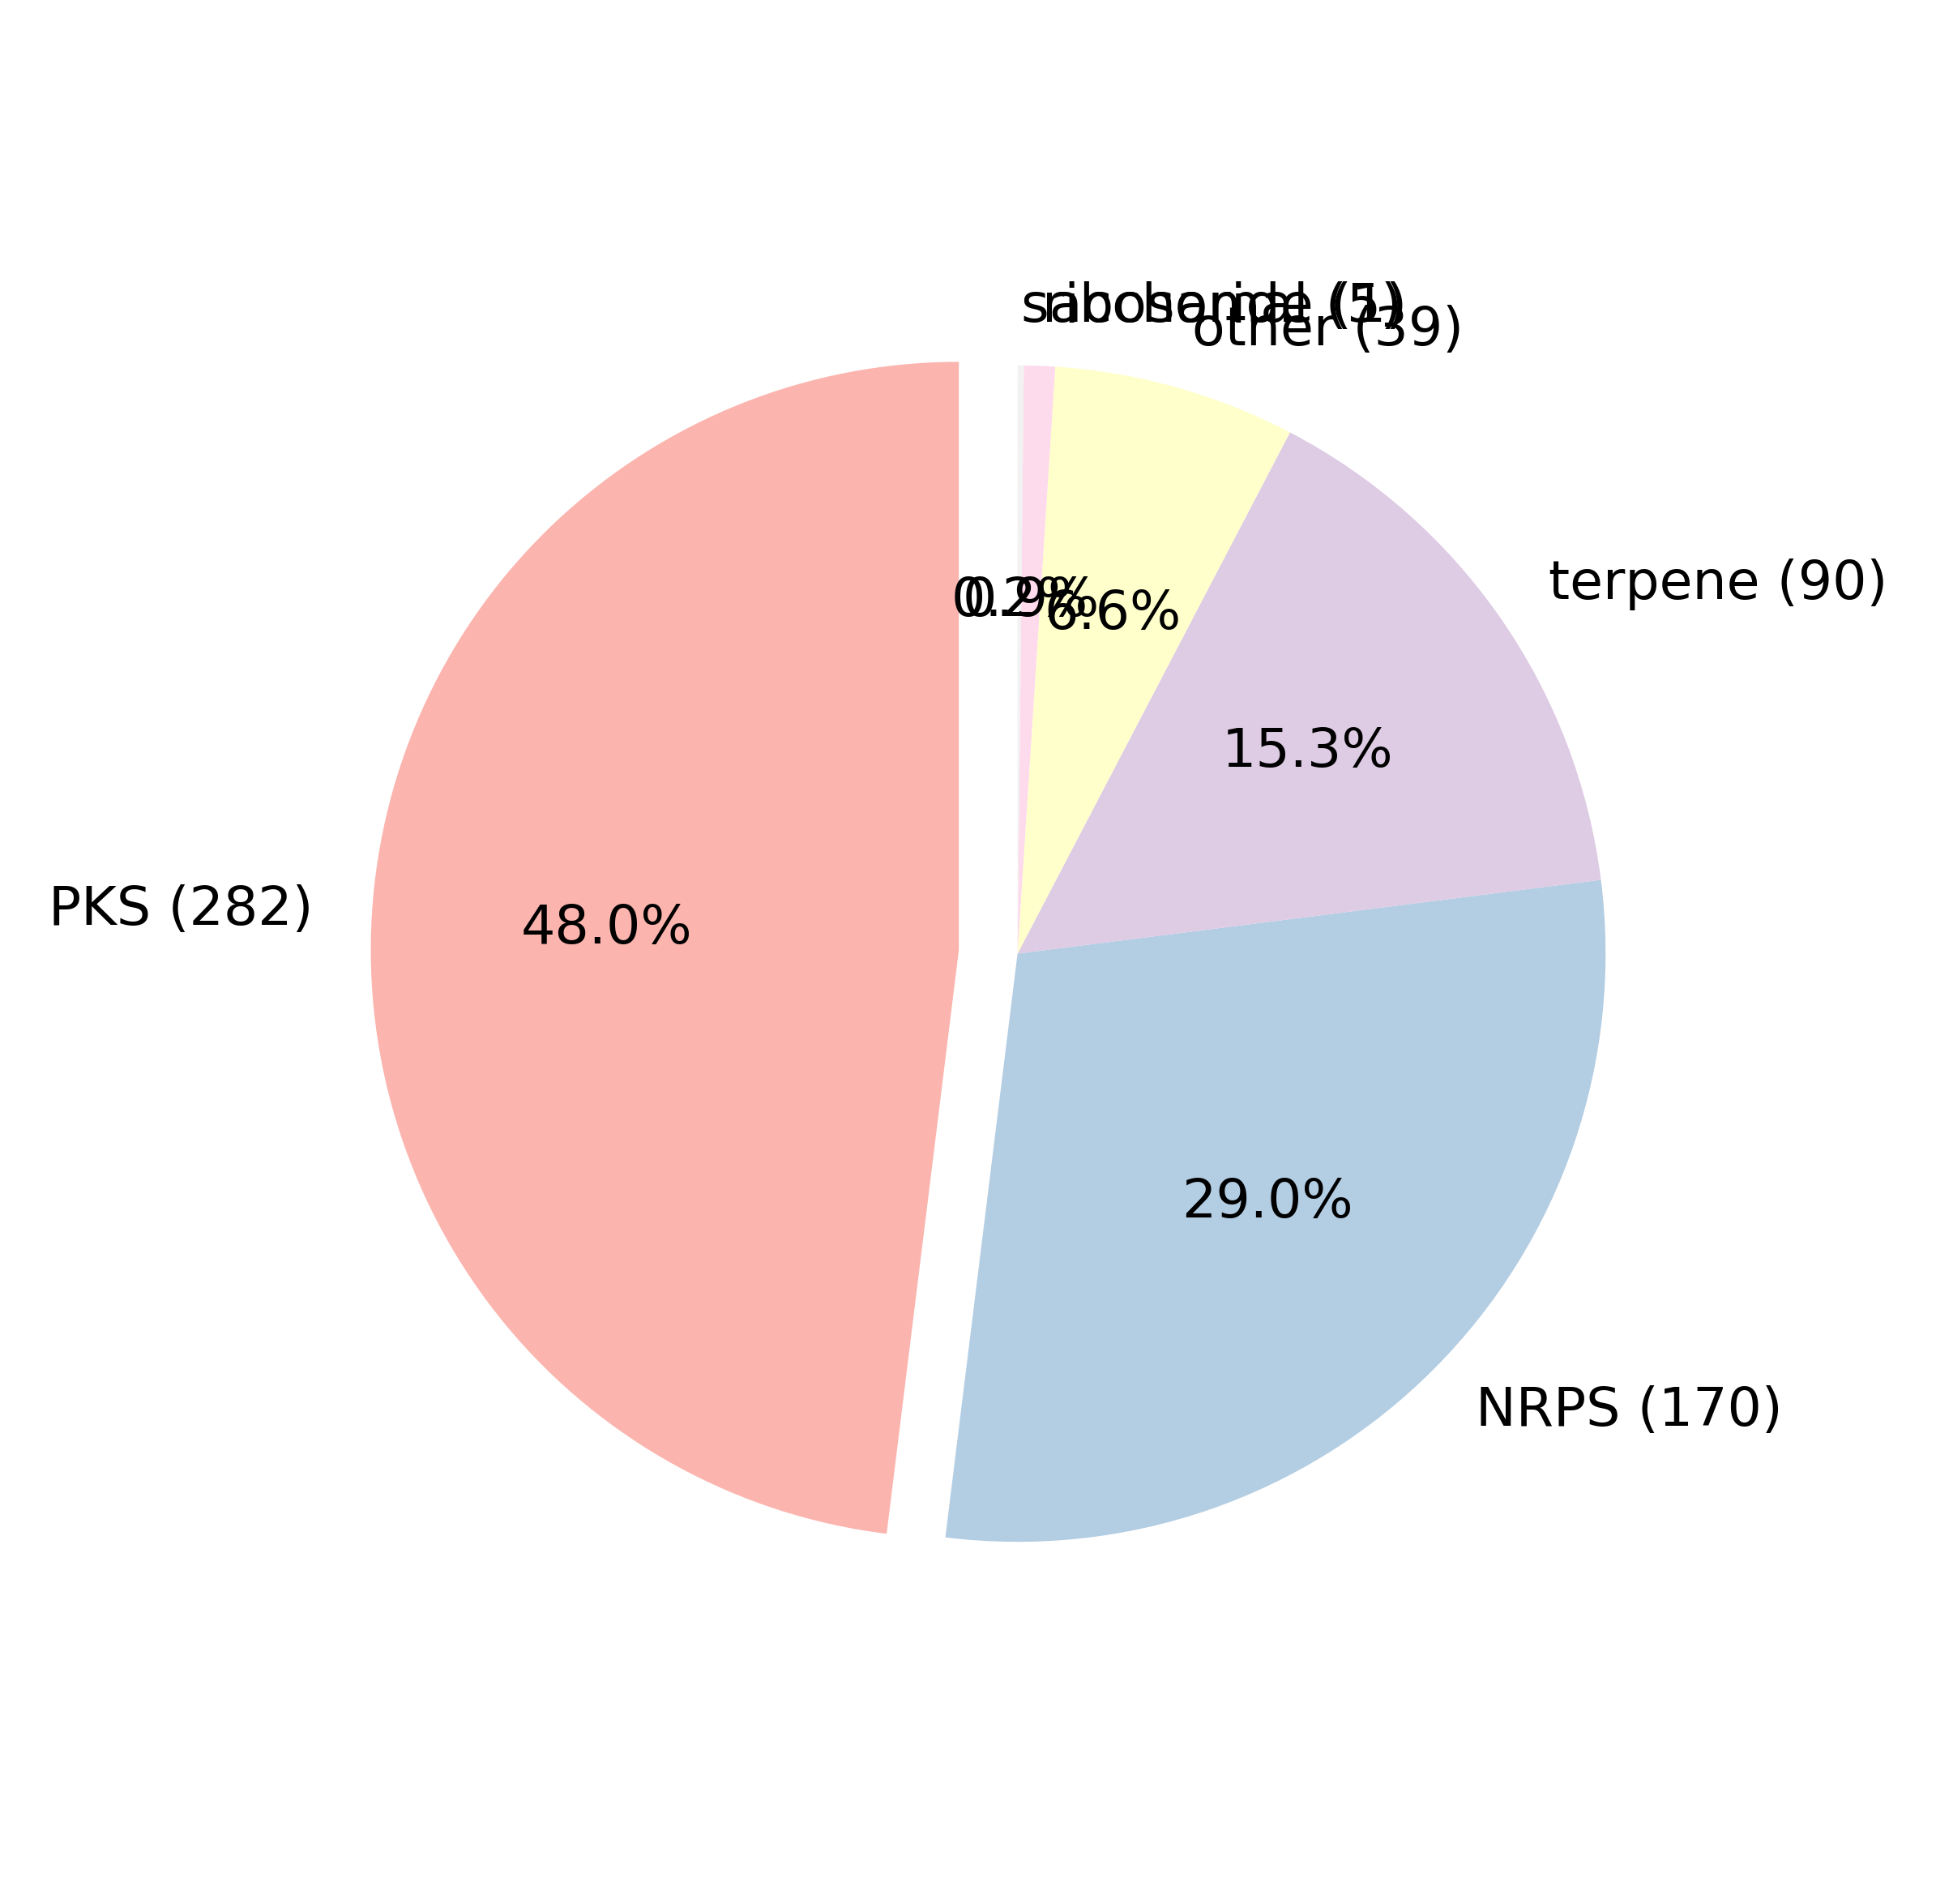

In [11]:
plot_counter_pie_proportional(
        Counter(fungi_classes), 
        max_categories=8,  
        show_title=False, 
    )

#plt.savefig(os.path.join("supporting_figs", "Fungi_class_distribution.pdf"), format='pdf')


## MAC Performance

In [19]:
model_cfg = cfg.BGC_MAC
ckpt_name = "MAC_2025-10-10_17-52-47"
test_name = os.path.basename(cfg.MAC_metadata).split(".")[0]
test_data = pd.read_pickle(os.path.join("..", model_cfg.checkpoint_dir, f"test_{test_name}_{model_cfg.data.random_seed}.pkl"))
antismash_pred = pickle.load(open(os.path.join("..", model_cfg.checkpoint_dir, f"antismash_pred_{model_cfg.data.random_seed}.pkl"), "rb"))
ckpt_path = os.path.join("..", model_cfg.checkpoint_dir, ckpt_name)
ensemble_evaluation = pickle.load(open(os.path.join( ckpt_path, "MAC_test_ensemble.pkl"), "rb"))
individual_evaluation = pickle.load(open(os.path.join( ckpt_path, "MAC_test_individual.pkl"), "rb"))
print(ensemble_evaluation.keys())
print(individual_evaluation.keys())
true = ensemble_evaluation["true_labels"]
pred = ensemble_evaluation["pred"]
print(true.shape)
print(pred.shape)

dict_keys(['pred', 'metrics', 'attn_weight', 'gene_kind_high_attn', 'pfam_high_attn', 'true_labels'])
dict_keys(['pred', 'metrics', 'attn_weight', 'true_labels'])
(263, 6)
(263, 6)


In [ ]:
data_for_save = test_data.drop(columns = ["enzyme_list", "protein_rep", "pfam", "gene_kind"])
data_for_save["prediction_score"] = list(pred)
data_for_save["biosyn_class"] = data_for_save["biosyn_class"].apply(tensor_to_classes)
data_for_save["prediction_result"] = data_for_save["prediction_score"].apply(tensor_to_classes)
data_for_save = tensor_to_columns(data_for_save, "prediction_score")
data_for_save.to_csv(f"/home/kchlu/link_name/natural_product/ckpt/BGC_MAC/{ckpt_name}/result.csv")

### Figure 2

In [ ]:
with pd.ExcelWriter(os.path.join("..", "visualization", "table", "MAC_performance_multiple_head.xlsx"), engine="openpyxl") as writer:
    pd.DataFrame(ensemble_evaluation["metrics"]).to_excel(writer, sheet_name="ensemble", index=False)
    pd.DataFrame(individual_evaluation["metrics"]["precision_per_class"]).to_excel(writer, sheet_name="Precision", index=False)
    pd.DataFrame(individual_evaluation["metrics"]["recall_per_class"]).to_excel(writer, sheet_name="recall", index=False)
    pd.DataFrame(individual_evaluation["metrics"]["auc_per_class"]).to_excel(writer, sheet_name="auc", index=False)
display(pd.DataFrame(individual_evaluation["metrics"]["auc_per_class"]))

0         1         2         3         4         5
0  0.963132  0.861466  0.970867  0.977679  0.973613  0.995457
1  0.969854  0.855815  0.954853  0.992331  0.980168  0.995935
2  0.964103  0.853901  0.962368  0.980540  0.972773  0.996652
3  0.960845  0.823551  0.962060  0.990499  0.972773  0.995218
4  0.963756  0.845060  0.965262  0.991415  0.977815  0.996652
5  0.958351  0.848797  0.965201  0.989812  0.968067  0.996174
6  0.964172  0.851531  0.964031  0.982944  0.978319  0.998565
7  0.967360  0.845972  0.963723  0.992788  0.976303  0.994978
8  0.959182  0.848341  0.963538  0.987294  0.977815  0.996652

In [5]:

def mcnemar_test_multitask(true, pred1, pred2):
    """
    Perform McNemar's test for multitask binary classification.

    Parameters:
        true (np.ndarray): Ground truth labels, shape (n_samples, n_tasks).
        pred1 (np.ndarray): Predictions from model 1, shape (n_samples, n_tasks).
        pred2 (np.ndarray): Predictions from model 2, shape (n_samples, n_tasks).

    Returns:
        list: A list of results for each task, where each result is a dictionary with:
              - "task": Task index (starting from 0)
              - "contingency_table": Contingency table for the task
              - "chi2_statistic": Chi-squared statistic for the task (if exact=False)
              - "p_value": P-value for the task
    """
    # Convert inputs to numpy arrays if they are tensors

    n_tasks = true.shape[1]
    results = []

    for task in range(n_tasks):
        # Extract data for the current task
        true_task = true[:, task]
        pred1_task = pred1[:, task]
        pred2_task = pred2[:, task]

        # Contingency table components
        a = np.sum((pred1_task == true_task) & (pred2_task == true_task))  # Both correct
        b = np.sum((pred1_task == true_task) & (pred2_task != true_task))  # pred1 correct, pred2 incorrect
        c = np.sum((pred1_task != true_task) & (pred2_task == true_task))  # pred1 incorrect, pred2 correct
        d = np.sum((pred1_task != true_task) & (pred2_task != true_task))  # Both incorrect

        # Construct the full contingency table
        contingency_table = np.array([[a, b], [c, d]])

        # Choose exact or approximate test based on b + c
        exact = (b + c) < 100  # Use exact test for small sample sizes
        result = mcnemar(contingency_table, exact=exact)

        # Append the result for this task
        results.append({
            "task": list(class_dict.keys())[task],
            "contingency_table": contingency_table.tolist(),
            "chi2_statistic": result.statistic if not exact else None,
            "p_value": result.pvalue
        })

    return results

In [6]:
results = mcnemar_test_multitask(true, np.round(pred), antismash_pred)
for res in results:
    print(f"Task {res['task']}:")
    print("  P-value:", res["p_value"])
print(results)

Task NRPS:
  P-value: 0.5078125
Task other:
  P-value: 0.18485048241641844
Task PKS:
  P-value: 0.453125
Task ribosomal:
  P-value: 1.0
Task saccharide:
  P-value: 0.0241195447742939
Task terpene:
  P-value: 0.7744140625
[{'task': 'NRPS', 'contingency_table': [[241, 6], [3, 13]], 'chi2_statistic': None, 'p_value': np.float64(0.5078125)}, {'task': 'other', 'contingency_table': [[189, 34], [23, 17]], 'chi2_statistic': None, 'p_value': np.float64(0.18485048241641844)}, {'task': 'PKS', 'contingency_table': [[244, 5], [2, 12]], 'chi2_statistic': None, 'p_value': np.float64(0.453125)}, {'task': 'ribosomal', 'contingency_table': [[251, 6], [6, 0]], 'chi2_statistic': None, 'p_value': np.float64(1.0)}, {'task': 'saccharide', 'contingency_table': [[229, 21], [8, 5]], 'chi2_statistic': None, 'p_value': np.float64(0.0241195447742939)}, {'task': 'terpene', 'contingency_table': [[250, 5], [7, 1]], 'chi2_statistic': None, 'p_value': np.float64(0.7744140625)}]


In [20]:
data = []
for result in results:
    task = result['task']
    contingency_table = np.array(result['contingency_table'])

    data.append({
        'Task': task,
        'BGC_MAC_Correct & AntiSMASH_Correct': contingency_table[0, 0],
        'BGC_MAC_Correct & AntiSMASH_Incorrect': contingency_table[0, 1],
        'BGC_MAC_Incorrect & AntiSMASH_Correct': contingency_table[1, 0],
        'BGC_MAC_Incorrect & AntiSMASH_Incorrect': contingency_table[1, 1]
    })

df = pd.DataFrame(data)

# Display the combined DataFrame
df

Task  BGC_MAC_Correct & AntiSMASH_Correct  \
0        NRPS                                  241   
1       other                                  189   
2         PKS                                  244   
3   ribosomal                                  251   
4  saccharide                                  229   
5     terpene                                  250   

   BGC_MAC_Correct & AntiSMASH_Incorrect  \
0                                      6   
1                                     34   
2                                      5   
3                                      6   
4                                     21   
5                                      5   

   BGC_MAC_Incorrect & AntiSMASH_Correct  \
0                                      3   
1                                     23   
2                                      2   
3                                      6   
4                                      8   
5                                      7   

   BGC_MAC_Incorrect & AntiSMASH_Incorrect  
0                                       13  
1                                       17  
2                                       12  
3                                        0  
4                                        5  
5                                        1

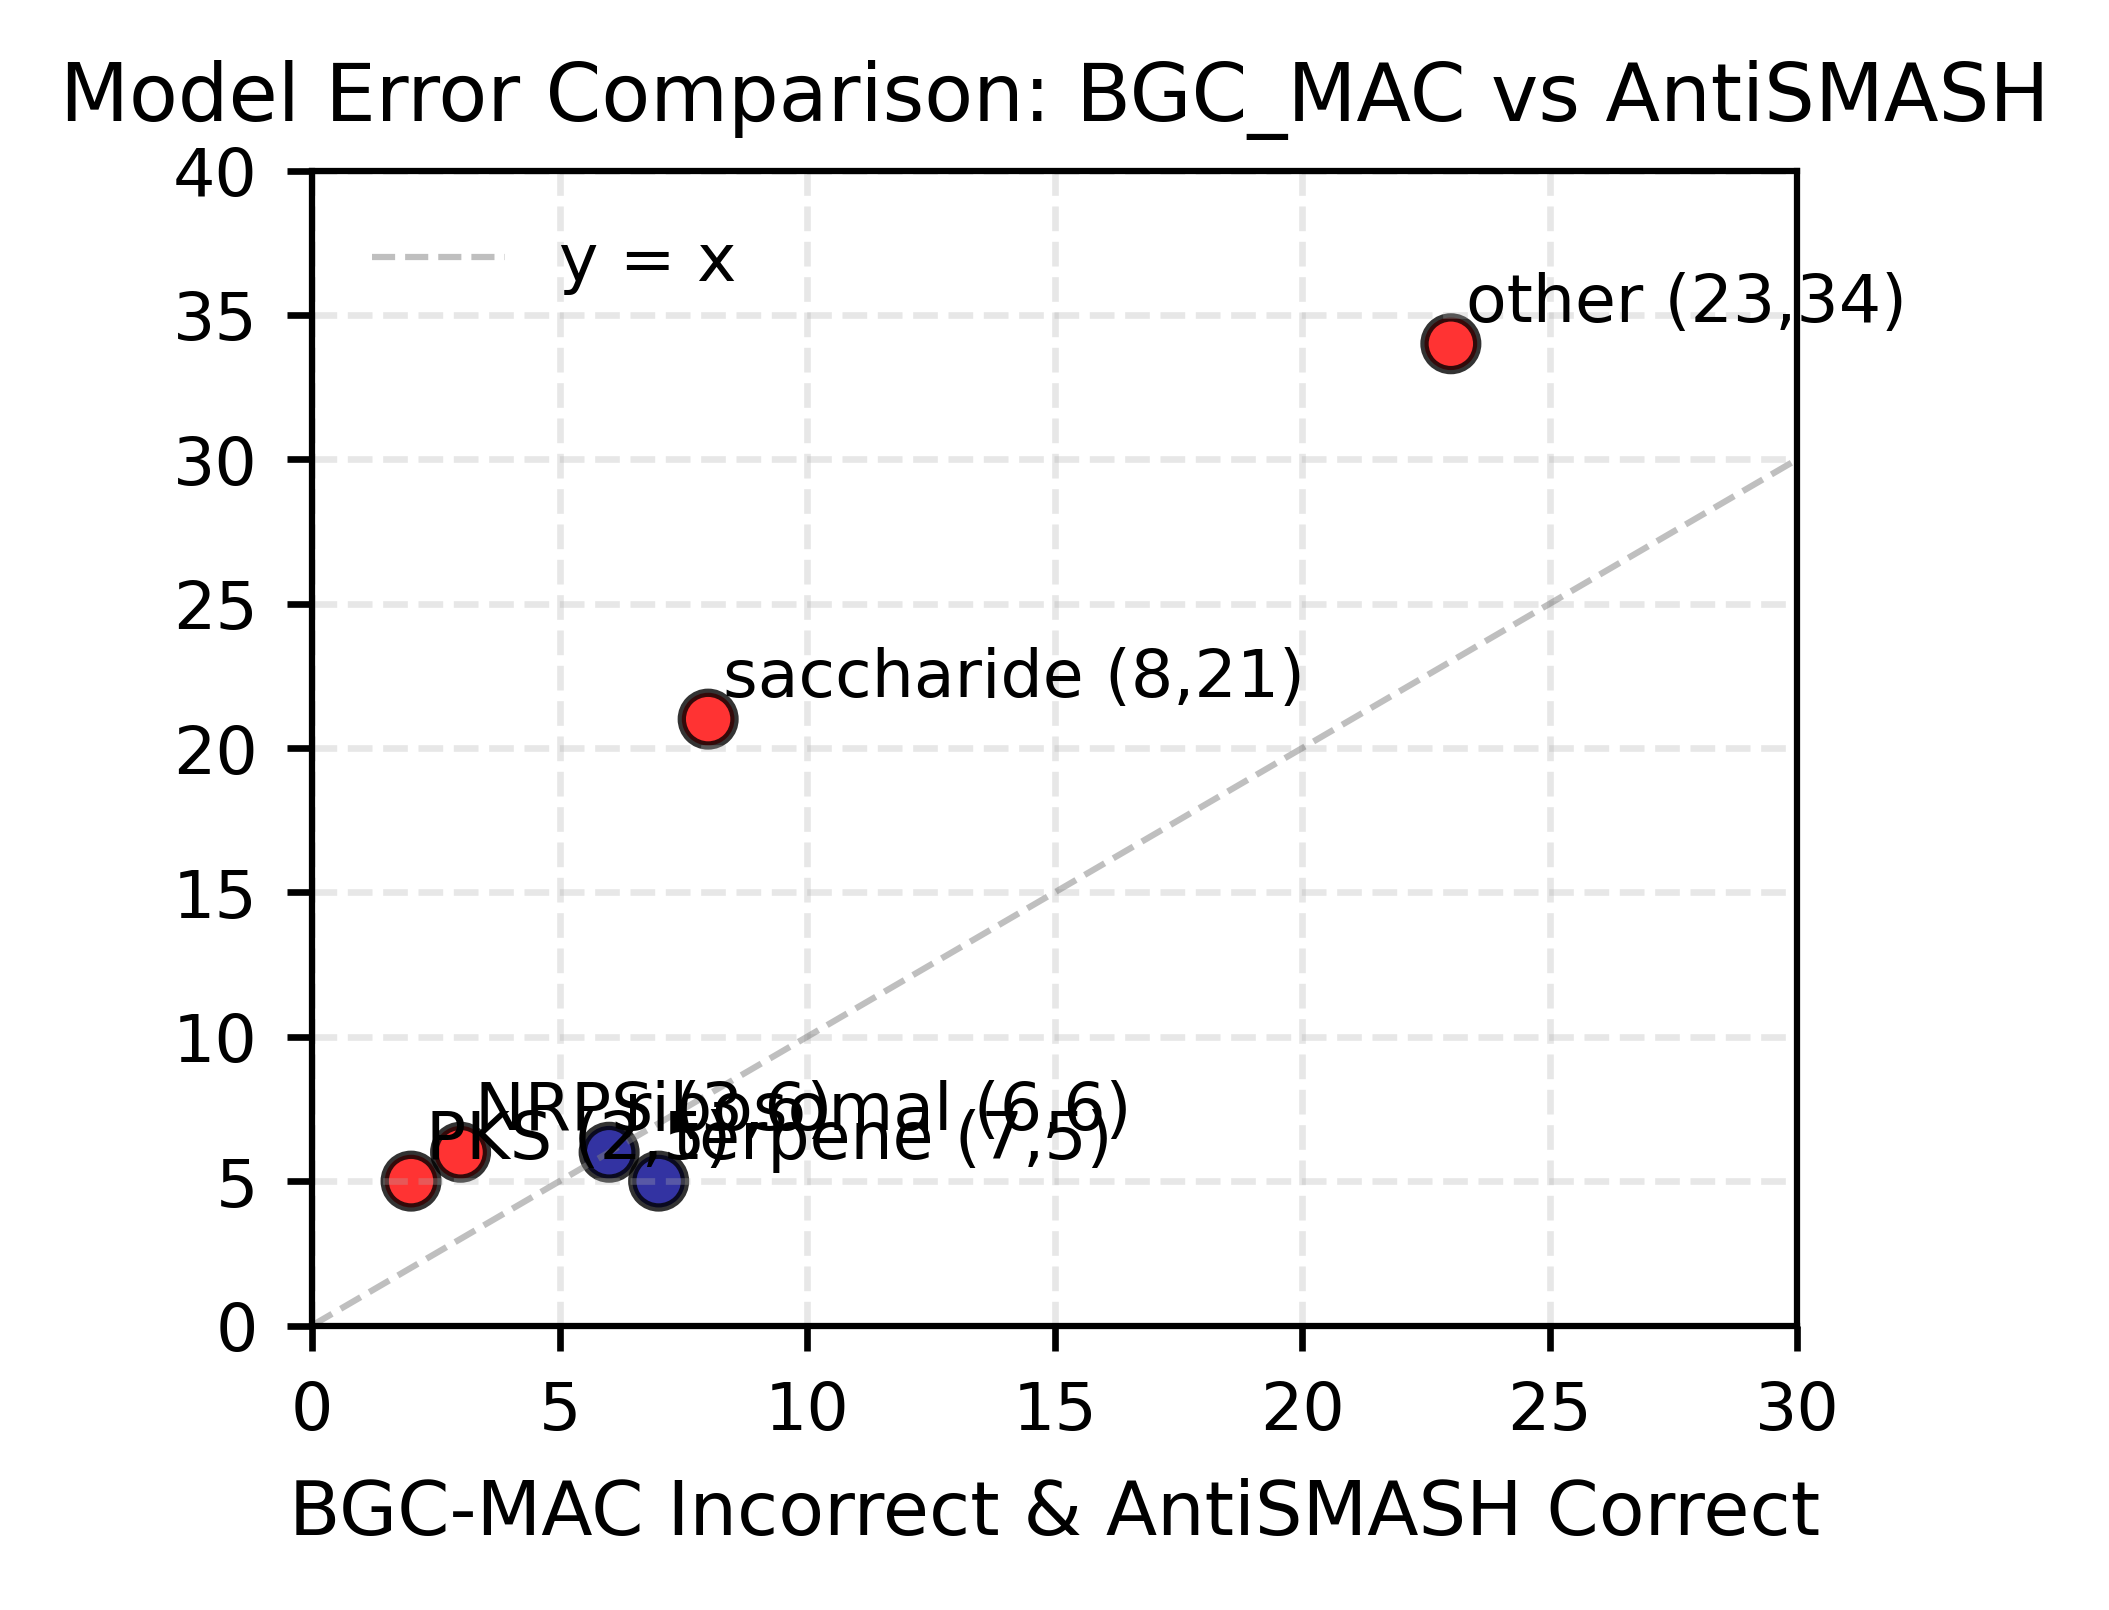

In [10]:
plt.figure(figsize=(230/72, 180/72))
plt.scatter(
    x=df["BGC_MAC_Incorrect & AntiSMASH_Correct"],
    y=df["BGC_MAC_Correct & AntiSMASH_Incorrect"],
    s=40,
    # y > x red, otherwise blue
    color=np.where(
        df["BGC_MAC_Correct & AntiSMASH_Incorrect"] > df["BGC_MAC_Incorrect & AntiSMASH_Correct"],
        "red",
        "darkblue"
    ),
    edgecolor="black",
    alpha=0.8,
)

for i, row in df.iterrows():
    xx = row["BGC_MAC_Incorrect & AntiSMASH_Correct"]
    yy = row["BGC_MAC_Correct & AntiSMASH_Incorrect"]
    plt.text(
        x=row["BGC_MAC_Incorrect & AntiSMASH_Correct"] + 0.3,
        y=row["BGC_MAC_Correct & AntiSMASH_Incorrect"] + 0.3,
        s=row["Task"]+f" ({xx},{yy})",
        #fontsize=20,
        ha="left",
        va="bottom",
    )

plt.plot([0, 40], [0, 40], linestyle="--", color="gray", alpha=0.5, label="y = x")

plt.xlabel("BGC-MAC Incorrect & AntiSMASH Correct")
plt.title("Model Error Comparison: BGC_MAC vs AntiSMASH")
plt.grid(True, linestyle="--", alpha=0.3)
plt.yticks()
plt.xticks()
plt.xlim(0, 30)
plt.ylim(0, 40) 
plt.legend()
plt.savefig(os.path.join("figures", "compare.pdf"), format='pdf')

plt.show()

picture saved to./figures


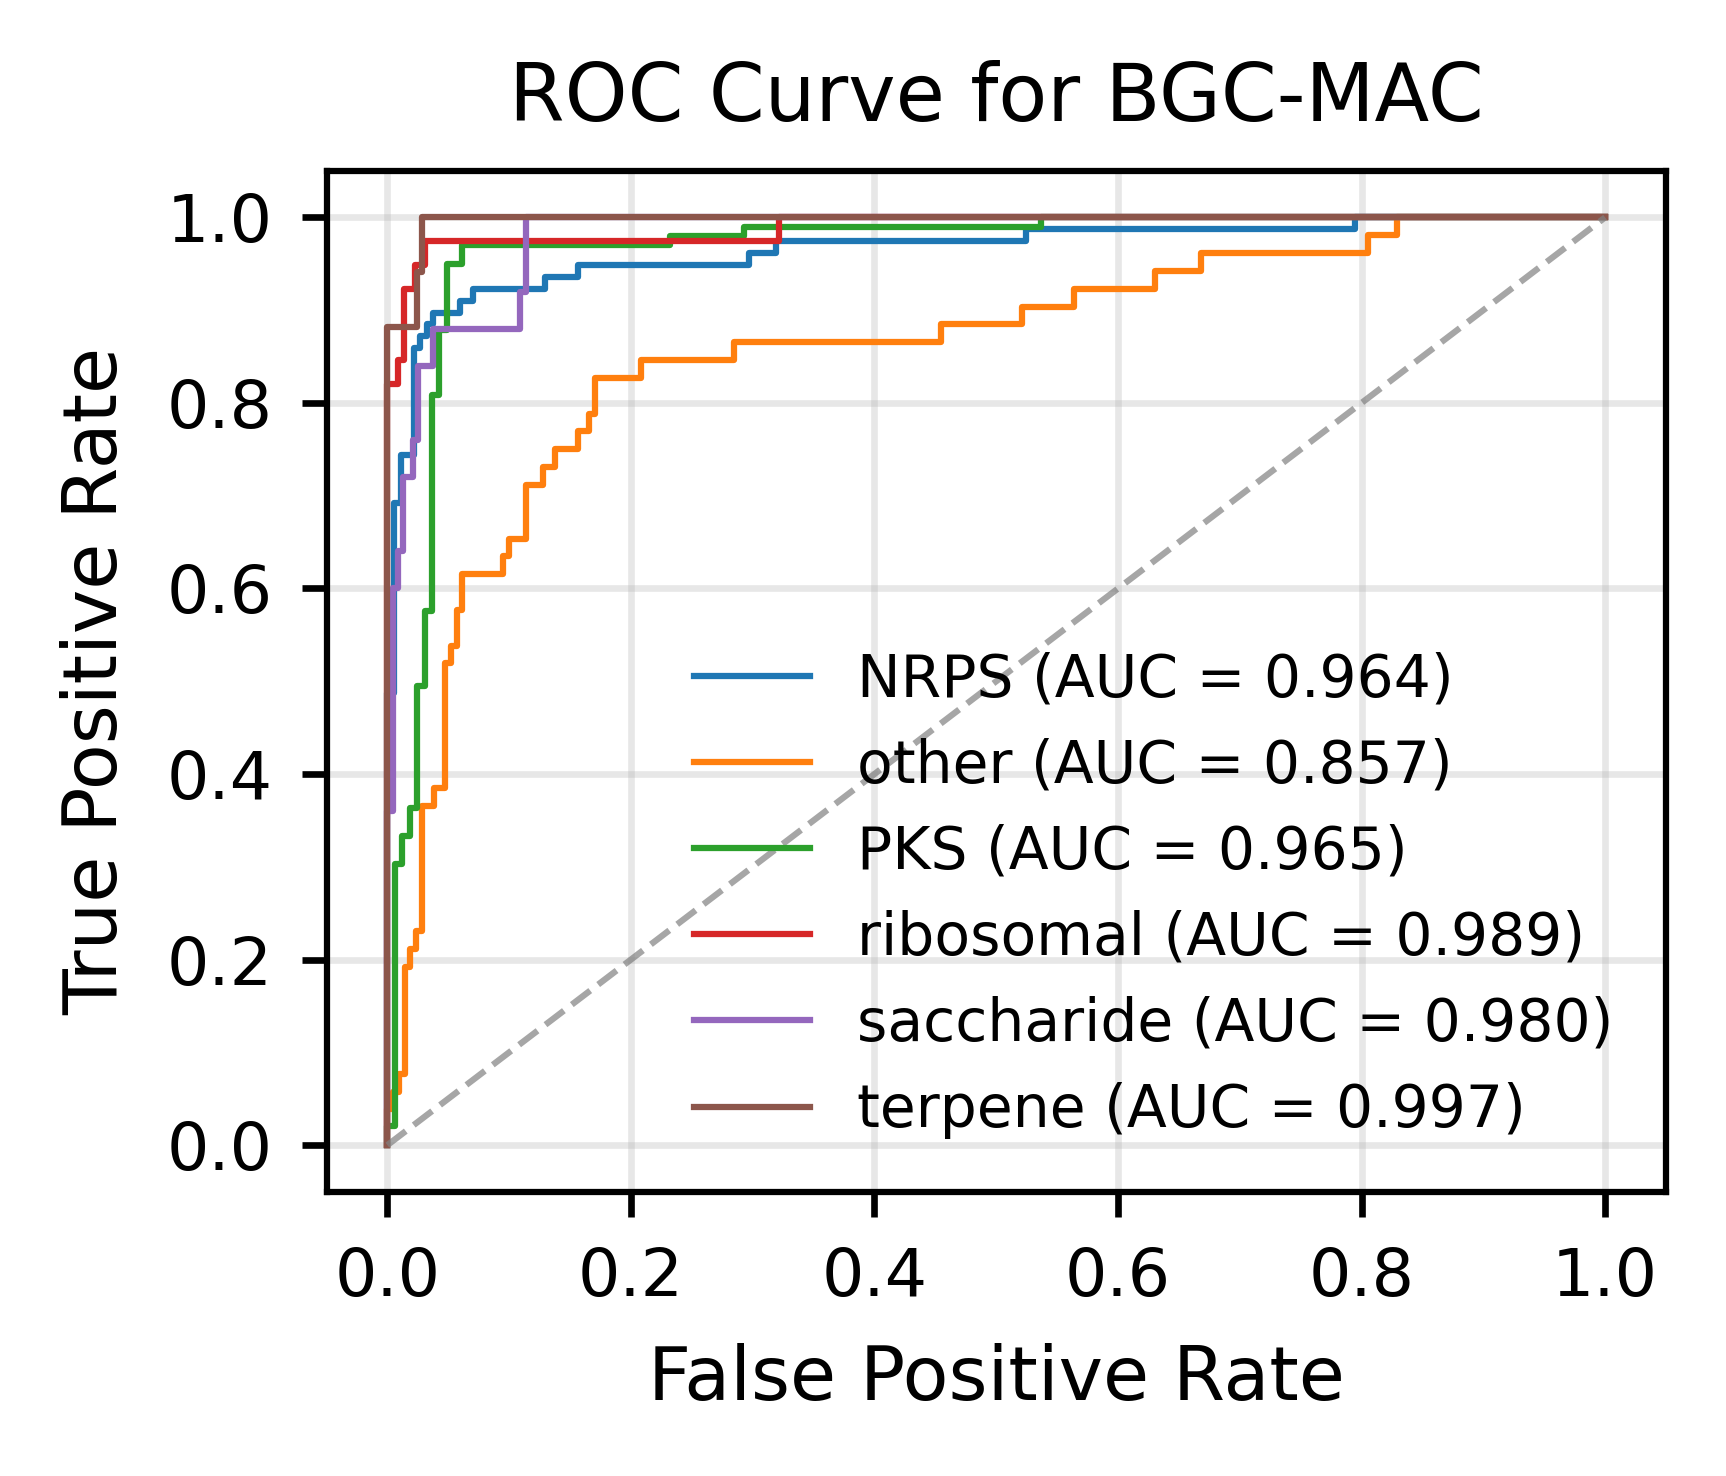

In [9]:
def plot_roc_curves(true, pred, class_labels=None, figsize=(10, 8), save_dir = None):
    """
    Plot ROC curves for multiple classes.

    Parameters:
        true (ndarray): Ground truth binary labels (shape: [n_samples, n_classes]).
        pred (ndarray): Predicted probabilities (shape: [n_samples, n_classes]).
        class_labels (list): List of class labels (default: [Class 1, Class 2, ...]).
        figsize (tuple): Size of the figure (default: (10, 8)).
    """
    n_classes = pred.shape[1]
    class_labels = class_labels or [list(class_dict.keys())[i] for i in range(n_classes)]

    plt.figure(figsize=figsize)

    for i in range(n_classes):
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(true[:, i], pred[:, i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.3f})')

    # Plot diagonal line for reference
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.7)

    # Add labels, legend, and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.yticks()
    plt.xticks()
    plt.title('ROC Curve for BGC-MAC', )
    plt.legend(loc='lower right', fontsize = 7)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_dir is not None:
      plt.savefig(os.path.join(save_dir, "auroc_sequence_only.pdf"), format='pdf')
      print(f"picture saved to{save_dir}")
    plt.show()

plot_roc_curves(true, pred, class_labels=None, figsize=(210/72, 180/72), save_dir = "./figures")

In [ ]:
categories = list(class_dict.keys())
categories.append("None")
def plot_confusion_matrix_heatmap(confusion_matrix, categories, figsize = (268/72, 200/72), title="Confusion Matrix Heatmap", save_dir = None, file_name = None):

    plt.figure(figsize=figsize)

    heatmap = sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=categories,
        yticklabels=categories[:-1],
        #cbar_kws={"shrink": 0.8}, 
        cbar = False
        #annot_kws={"fontsize": 24}  
    )
    for _, spine in heatmap.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(.75)

    plt.title(title)
    plt.xlabel("BGC-MAC Prediction")
    plt.ylabel("Actual")

    plt.xticks(rotation= 30, fontsize=6.5)
    plt.yticks(rotation= 30, fontsize=6.5)

    #colorbar = heatmap.collections[0].colorbar
    colorbar = plt.colorbar(heatmap.collections[0])
    colorbar.ax.tick_params()

    plt.tight_layout()
    if save_dir is not None:
      plt.savefig(os.path.join(save_dir, file_name), format='pdf')
      print(f"picture saved to{save_dir}")

    plt.show()

picture saved to/data5_large/home/kechenlu/natural_product/visualization/file_MAC_multihead


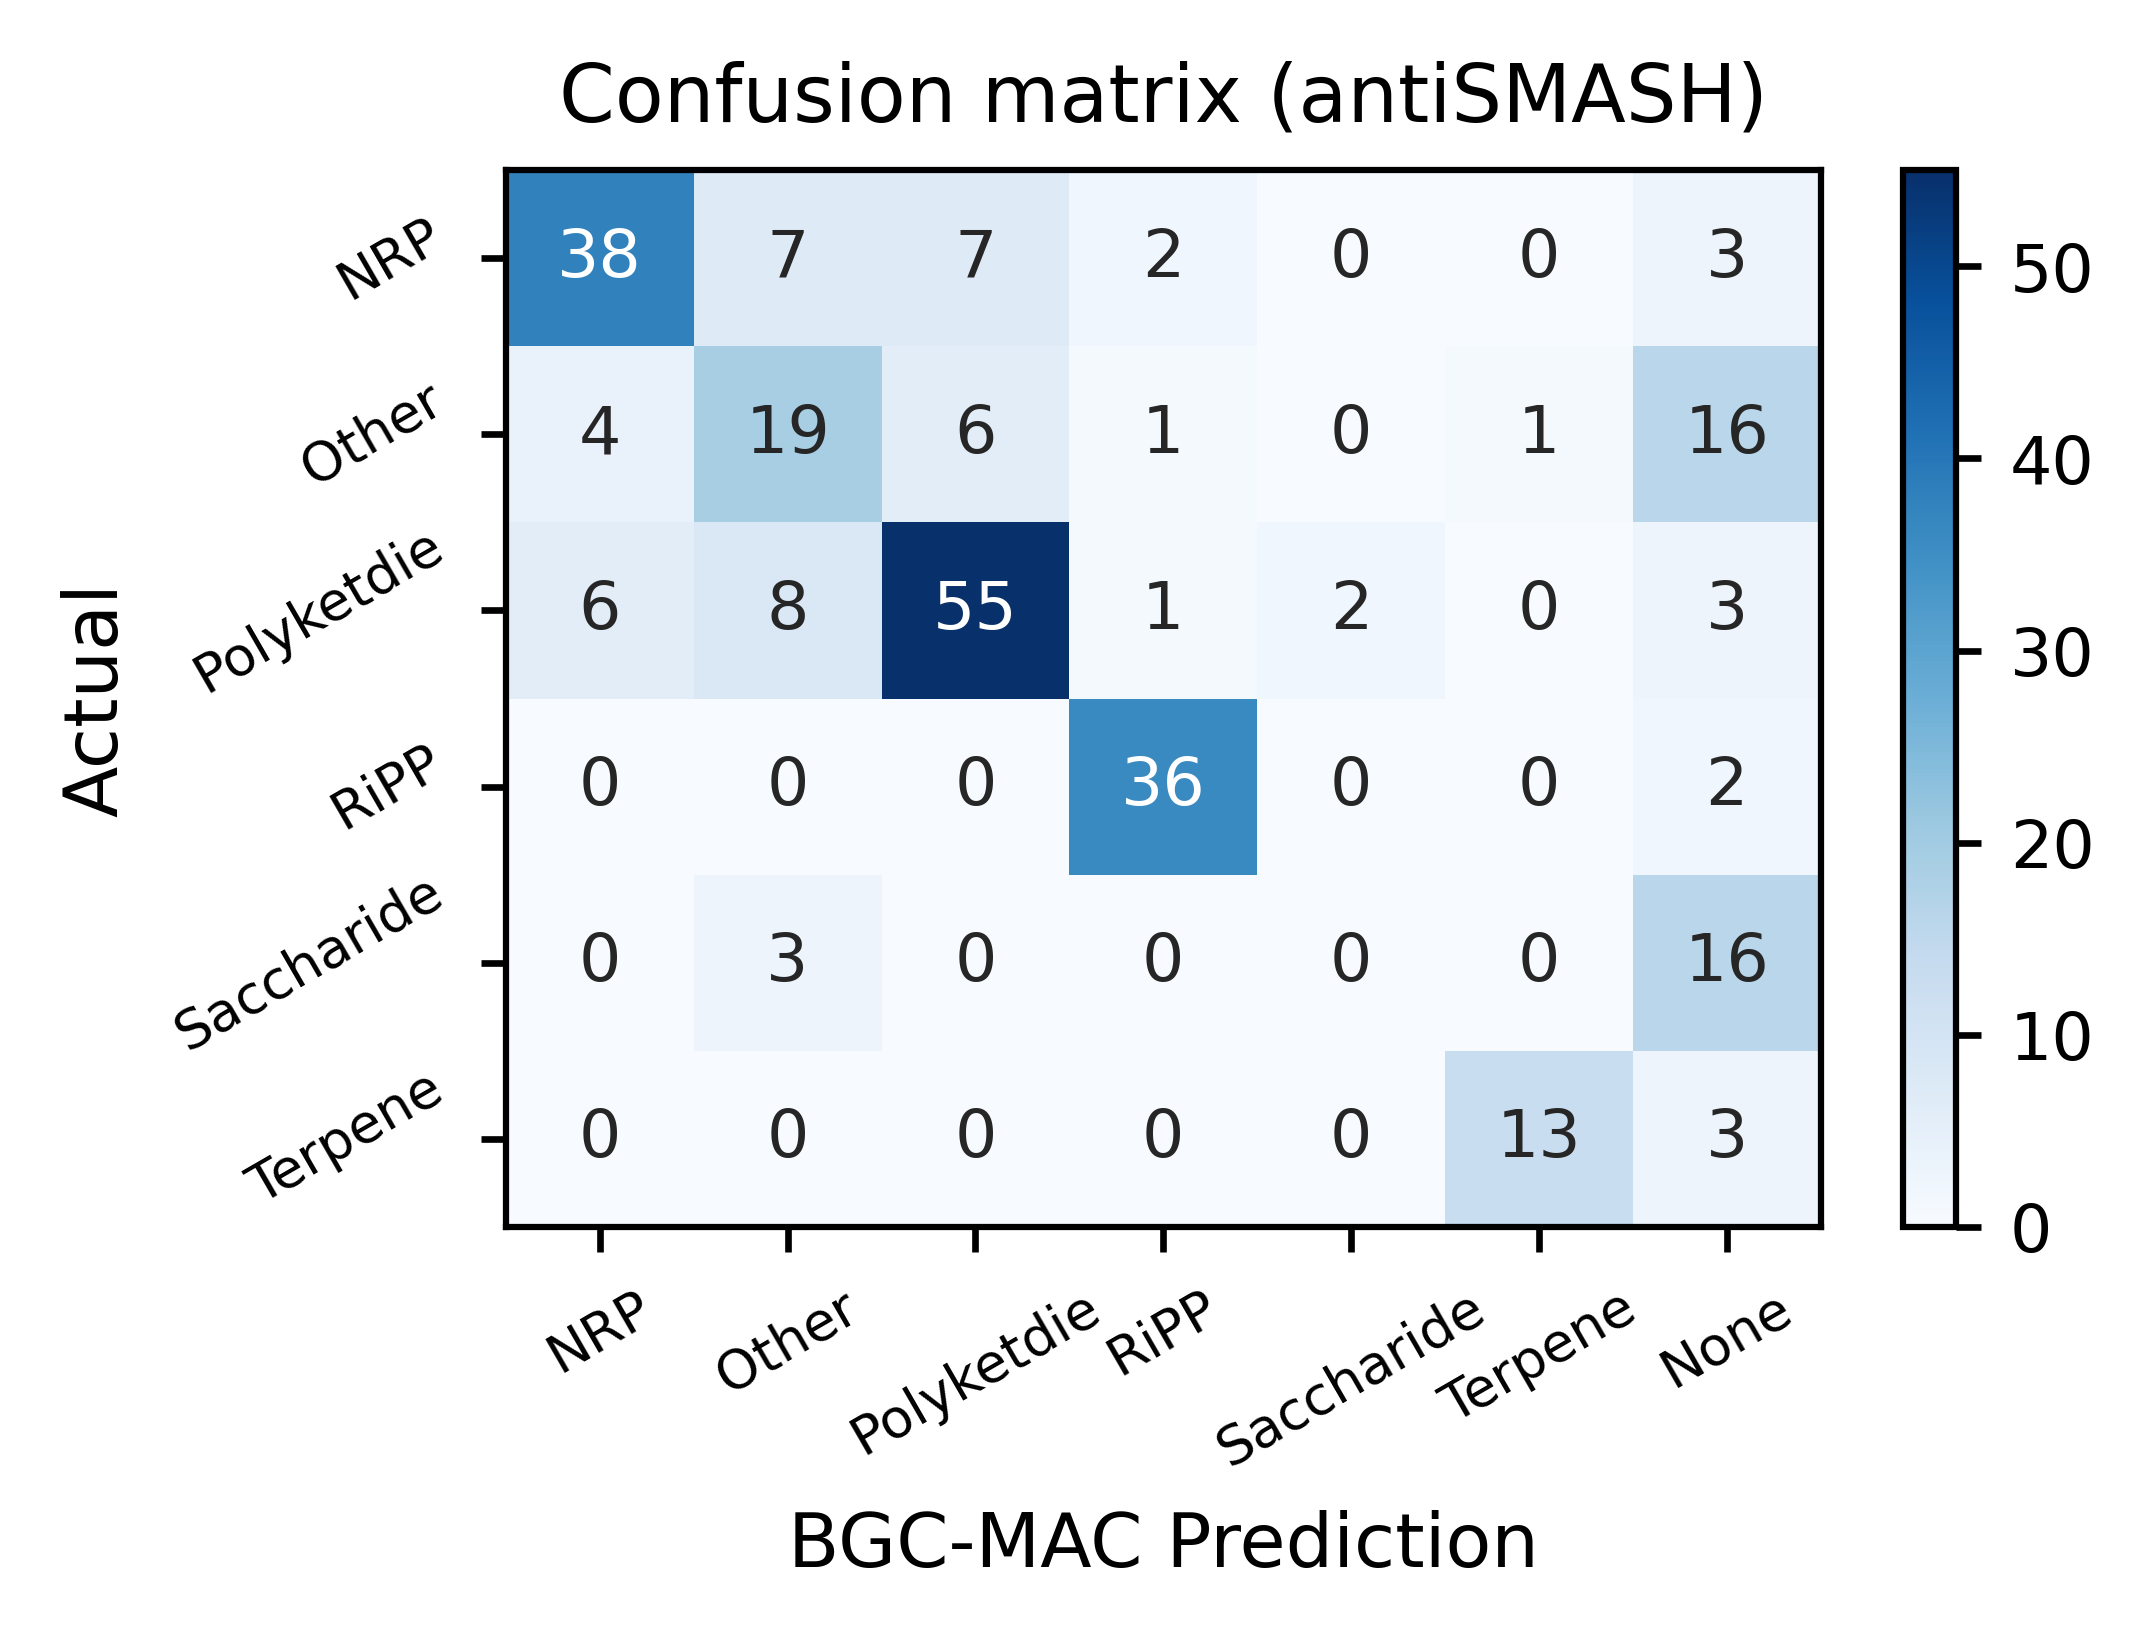

In [ ]:
confusion_matrix = compute_confusion_matrix(true, antismash_pred)
plot_confusion_matrix_heatmap(confusion_matrix, categories, title = "Confusion matrix (antiSMASH)", save_dir = "./figures", file_name = "CM_antismash.pdf")

picture saved to/data5_large/home/kechenlu/natural_product/visualization/file_MAC_multihead


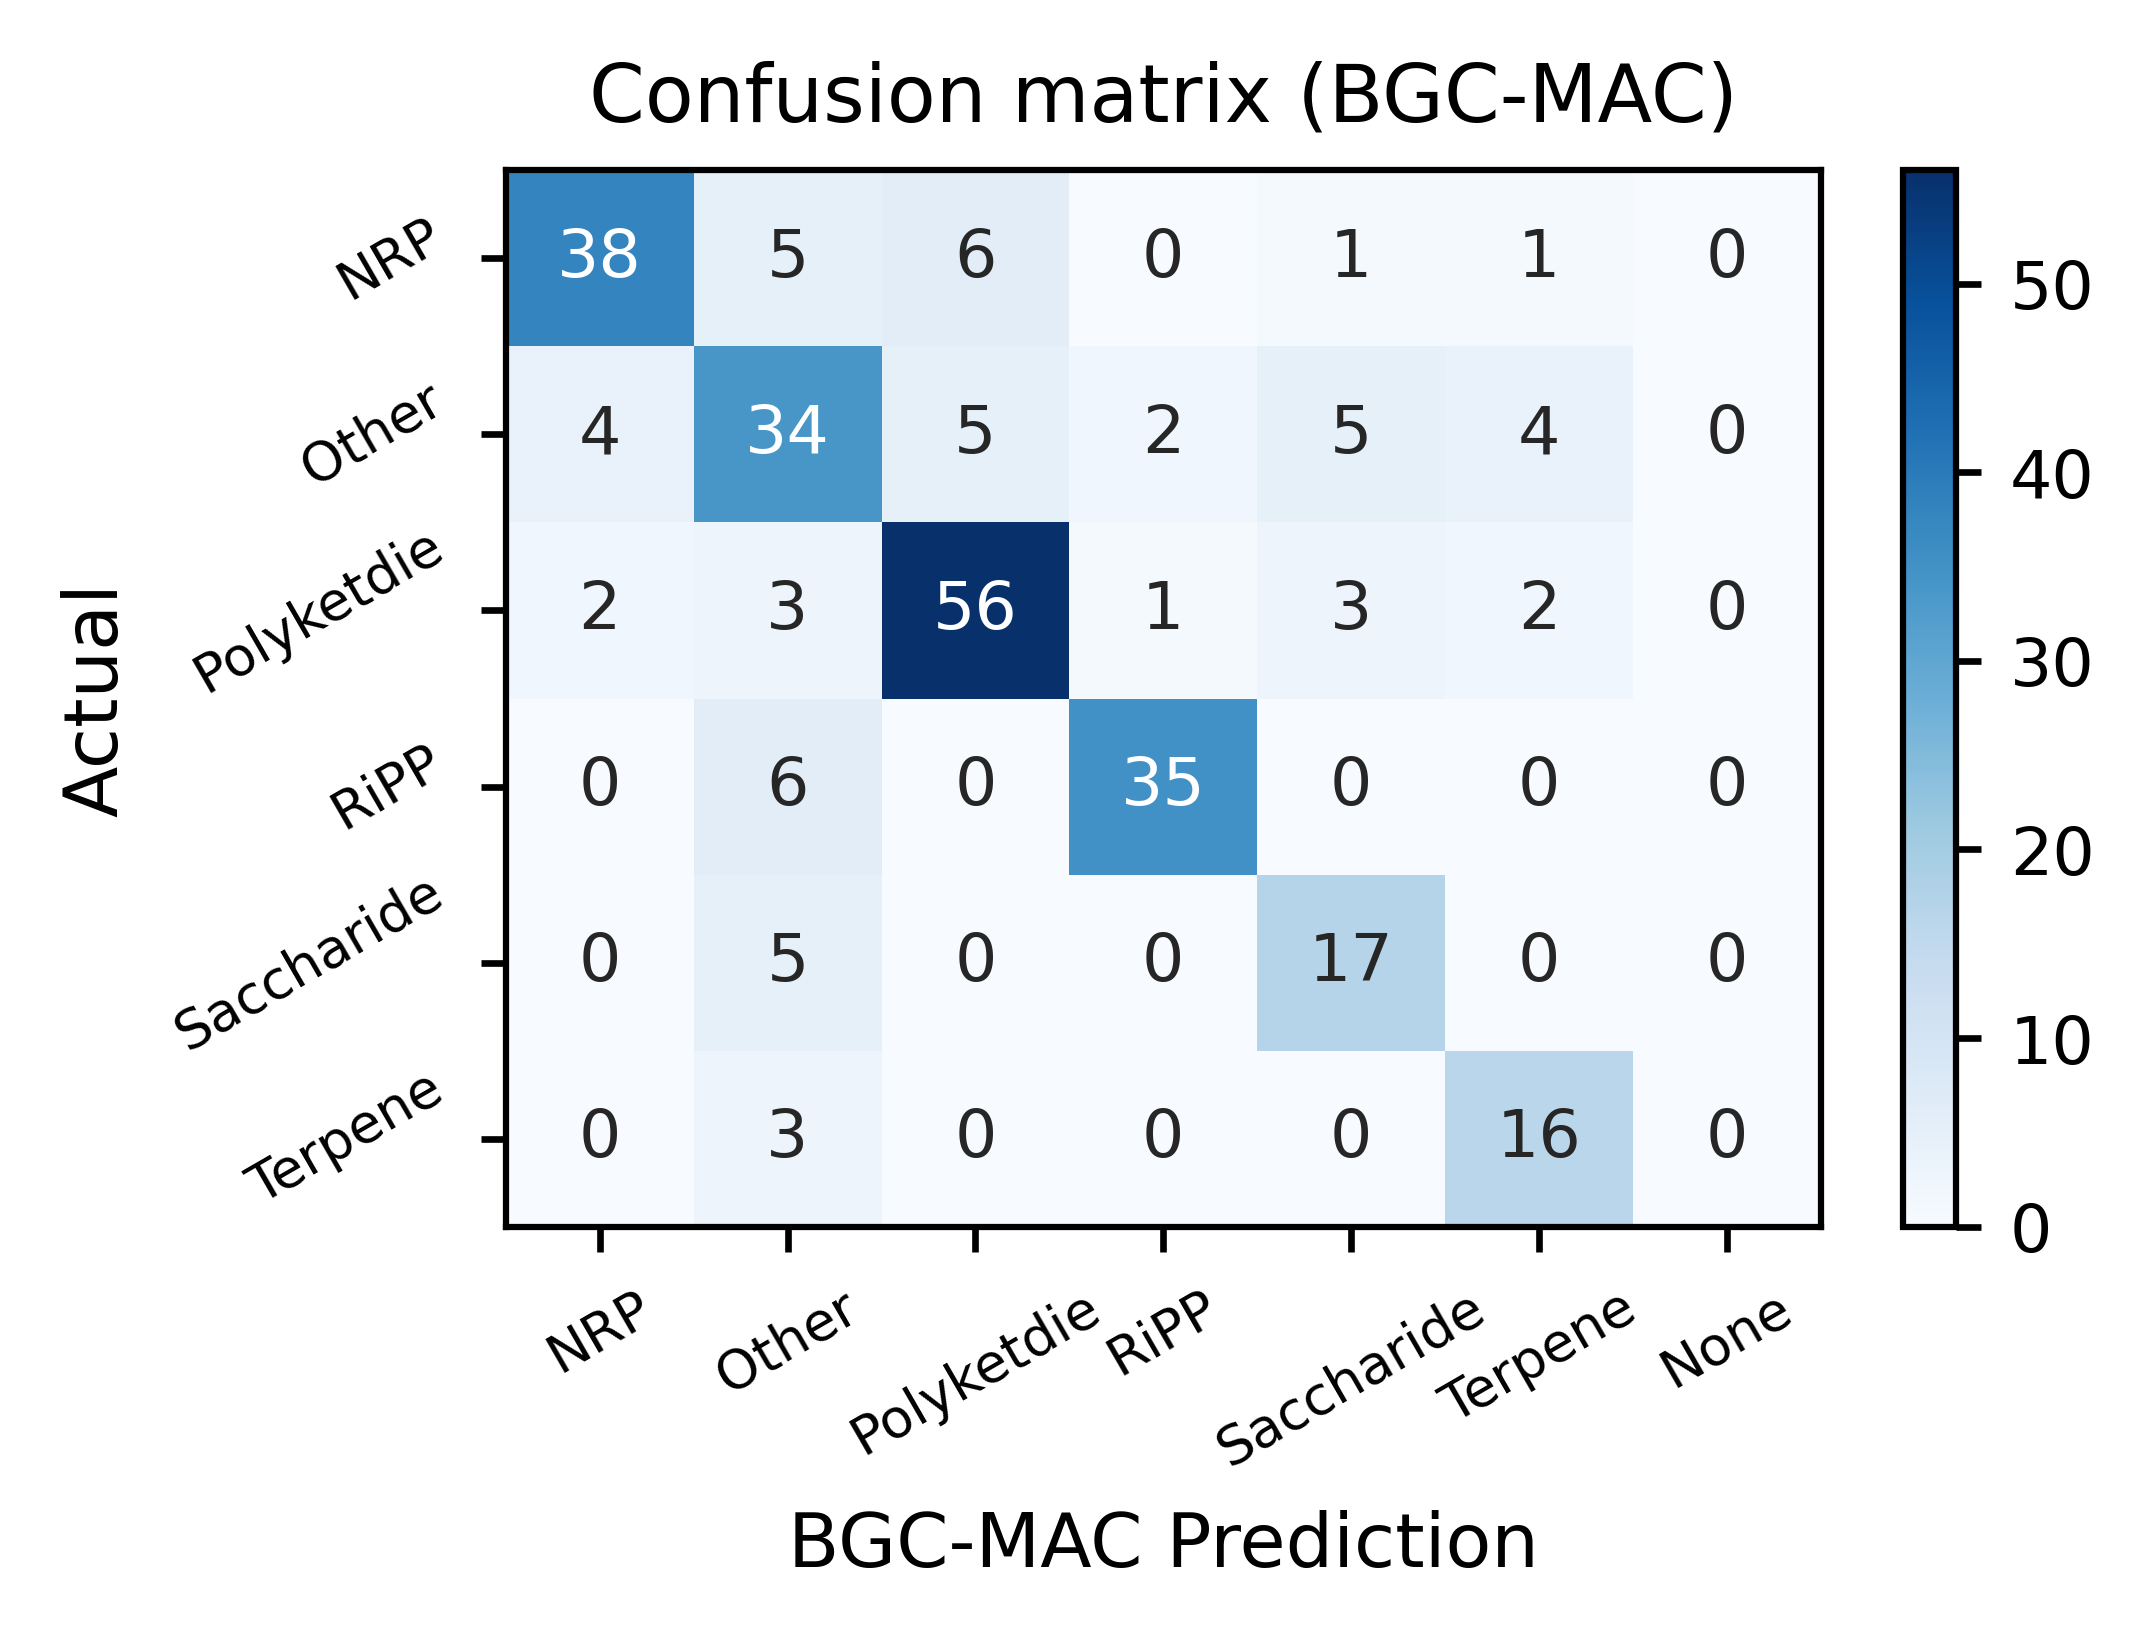

In [ ]:
confusion_matrix = compute_confusion_matrix(true, np.round(pred))
plot_confusion_matrix_heatmap(confusion_matrix, categories, title = "Confusion matrix (BGC-MAC)", save_dir = "./figures", file_name = "CM_MAC.pdf")

### Figure 3B

In [20]:
selected_idx = 88
selected_rows = test_data.iloc[selected_idx].reset_index(drop=True)
print(selected_rows)

0                                           BGC0000198
1    [tensor(0), tensor(0), tensor(1), tensor(0), t...
2    [MRGILLAGGTGSRLWPVTRAVSKQLIPVFDKPMIYYPLSTLVMAG...
3    [[tensor(0.0486), tensor(-0.0062), tensor(0.04...
4    [(NTP_transferase,), (dTDP_sugar_isom,), error...
5    [biosynthetic-additional, biosynthetic-additio...
Name: 2460, dtype: object


In [21]:
pfam = selected_rows.iloc[4]
print(pfam)

[('NTP_transferase',), ('dTDP_sugar_isom',), 'error', ('ABC_tran', 'AAA_21'), ('ABC2_membrane', 'ABC2_membrane_3'), ('Methyltransf_25',), ('DegT_DnrJ_EryC1',), ('DegT_DnrJ_EryC1',), 'error', ('MycE_N',), ('EryCIII-like_N', 'EryCIII-like_C'), ('Peptidase_M20',), ('DUF6176',), ('p450',), ('PIG-L',), ('EryCIII-like_C', 'EryCIII-like_N', 'UDPGT'), ('Aldo_ket_red',), ('Methyltransf_2', 'Dimerisation2'), ('FAD_binding_3', 'Rng_hyd_C'), ('BTAD',), ('Cyclase_polyket',), ('Cupin_2',), ('Polyketide_cyc2', 'Polyketide_cyc'), ('ABM',), ('Biotin_carb_C',), ('Carboxyl_trans',), 'error', 'error', ('BTAD',), ('Methyltransf_31', 'Methyltransf_25', 'Methyltransf_11', 'Methyltransf_12', 'Ubie_methyltran', 'Methyltransf_23'), 'error', ('Anthrone_oxy',), ('p450',), ('ketoacyl-synt', 'Ketoacyl-synt_C'), ('Ketoacyl-synt_C', 'ketoacyl-synt'), ('adh_short', 'adh_short_C2', 'KR'), ('Hexose_dehydrat',), ('GFO_IDH_MocA', 'GFO_IDH_MocA_C3'), 'error', ('ABM',), ('GDP_Man_Dehyd', 'Epimerase', '3Beta_HSD', 'Polysacc_

In [22]:
avg_attention = ensemble_evaluation["attn_weight"]
object_attention = avg_attention[selected_idx // 16][selected_idx % 16][:, :42]
print(object_attention.shape)

(6, 42)


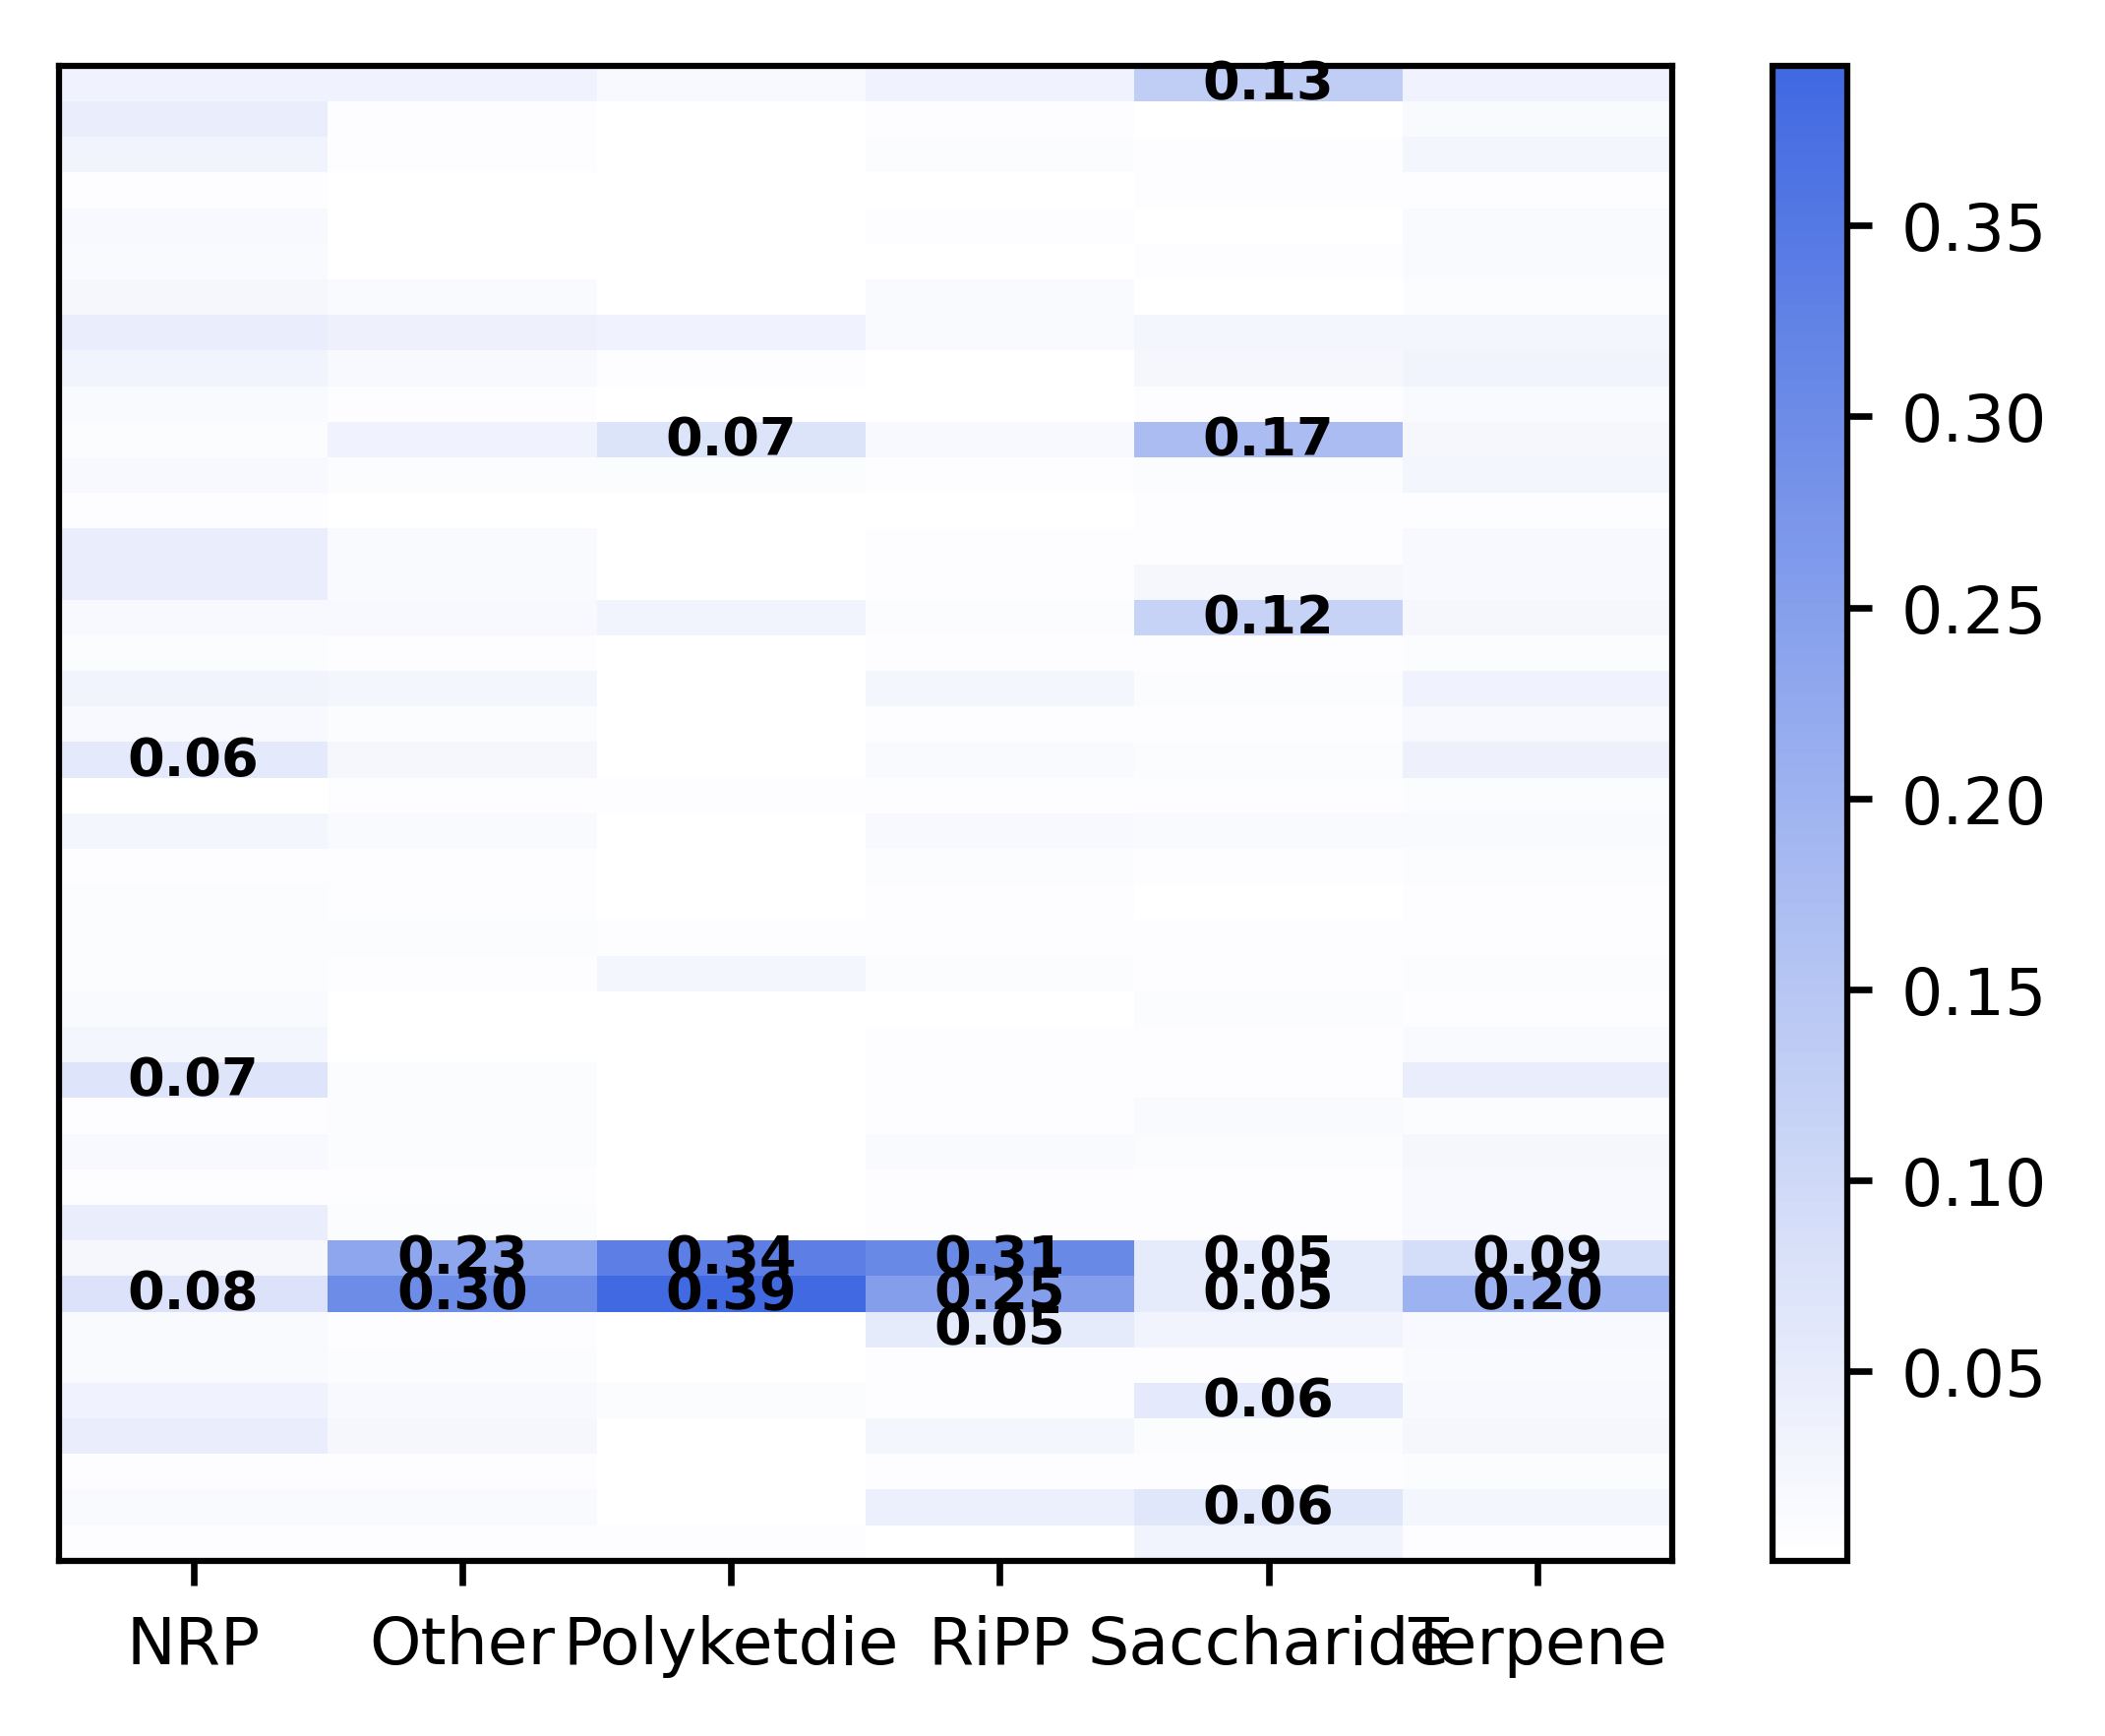

In [ ]:
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

cmap = sns.diverging_palette(240, 10, s=80, l=50, n=10, as_cmap=True)
colors = [(0, "white"), (1.0, "royalblue")]  
n_bins = 100  
cmap_name = 'custom_blue'

custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
plt.figure(figsize=(265/72, 215/72))
threshold = 0.05
annotation =  pfam
data_matrix = np.transpose(object_attention)
ax = sns.heatmap(data_matrix, 
                 cmap=custom_cmap, 
                 xticklabels = list(class_dict.keys()), 
                 yticklabels=False, 
                 cbar=False)

for i in range(data_matrix.shape[0]):
    for j in range(data_matrix.shape[1]):
        value = data_matrix[i, j]
        if value >= threshold:  # only annotate significant values
            # automatically determine text color based on background luminance
            rgb = custom_cmap(value)[:3]
            luminance = 0.299 * rgb[0] + 0.587 * rgb[1] + 0.114 * rgb[2]
            text_color = 'white' if luminance < 0.6 else 'black'

            ax.text(j + 0.5,  # x-axis
                    i + 0.5,  # y-axis
                    f'{value:.2f}',  
                    ha='center',
                    va='center',
                    color=text_color,
                    fontsize=6.5,
                    fontweight='bold')


ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.xticks(rotation=0)
#plt.yticks(rotation=0)
cbar = plt.colorbar(ax.collections[0])
cbar.ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:.2f}"))
cbar.ax.tick_params()
plt.tight_layout()
plt.savefig(os.path.join("./figures", "case_new.pdf"), format='pdf')
plt.show()

### Figure 3AC

In [24]:
gk_high_attn = ensemble_evaluation["gene_kind_high_attn"]
pfam_high_attn = ensemble_evaluation["pfam_high_attn"]

gk_counter, gk_origin_pct, gk_origin_total=count_gene_kind(test_data)
pfam_counter, pfam_origin_pct, pfam_origin_total=count_pfam(test_data)

def counter_to_percent(counter)->tuple[dict,int]:
  total = sum(counter.values())
  percentages = {key: (value / total) * 100 for key, value in counter.items()}
  return percentages,total

gk_high_attn_total=[counter_to_percent(biosyn_class)[1] for biosyn_class in gk_high_attn]
pfam_high_attn_total=[counter_to_percent(biosyn_class)[1] for biosyn_class in pfam_high_attn]
gk_high_attn_pct=[counter_to_percent(biosyn_class)[0] for biosyn_class in gk_high_attn]
pfam_high_attn_pct=[counter_to_percent(biosyn_class)[0] for biosyn_class in pfam_high_attn]

print(gk_counter)
print(gk_high_attn)

[{'biosynthetic-additional': 367, 'biosynthetic': 2151, None: 402, 'regulatory': 47, 'transport': 130, 'other': 30, 'resistance': 2}, {None: 287, 'biosynthetic-additional': 233, 'biosynthetic': 131, 'regulatory': 24, 'transport': 29, 'other': 13}, {'biosynthetic-additional': 785, 'biosynthetic': 2438, None: 642, 'transport': 99, 'regulatory': 112, 'other': 43, 'resistance': 1}, {'transport': 36, None: 139, 'biosynthetic-additional': 53, 'biosynthetic': 76, 'other': 3, 'regulatory': 12}, {None: 228, 'biosynthetic-additional': 256, 'other': 7, 'transport': 19, 'biosynthetic': 97, 'regulatory': 11}, {None: 80, 'other': 5, 'biosynthetic-additional': 66, 'biosynthetic': 19, 'transport': 5, 'regulatory': 2}]
[Counter({'biosynthetic': 509, 'biosynthetic-additional': 14, 'regulatory': 1, 'other': 1, None: 1}), Counter({'biosynthetic-additional': 27, None: 22, 'biosynthetic': 13, 'regulatory': 2, 'other': 1}), Counter({'biosynthetic': 655, 'biosynthetic-additional': 81, None: 25, 'regulatory': 

picture saved to/data5_large/home/kechenlu/natural_product/visualization/file_MAC_multihead


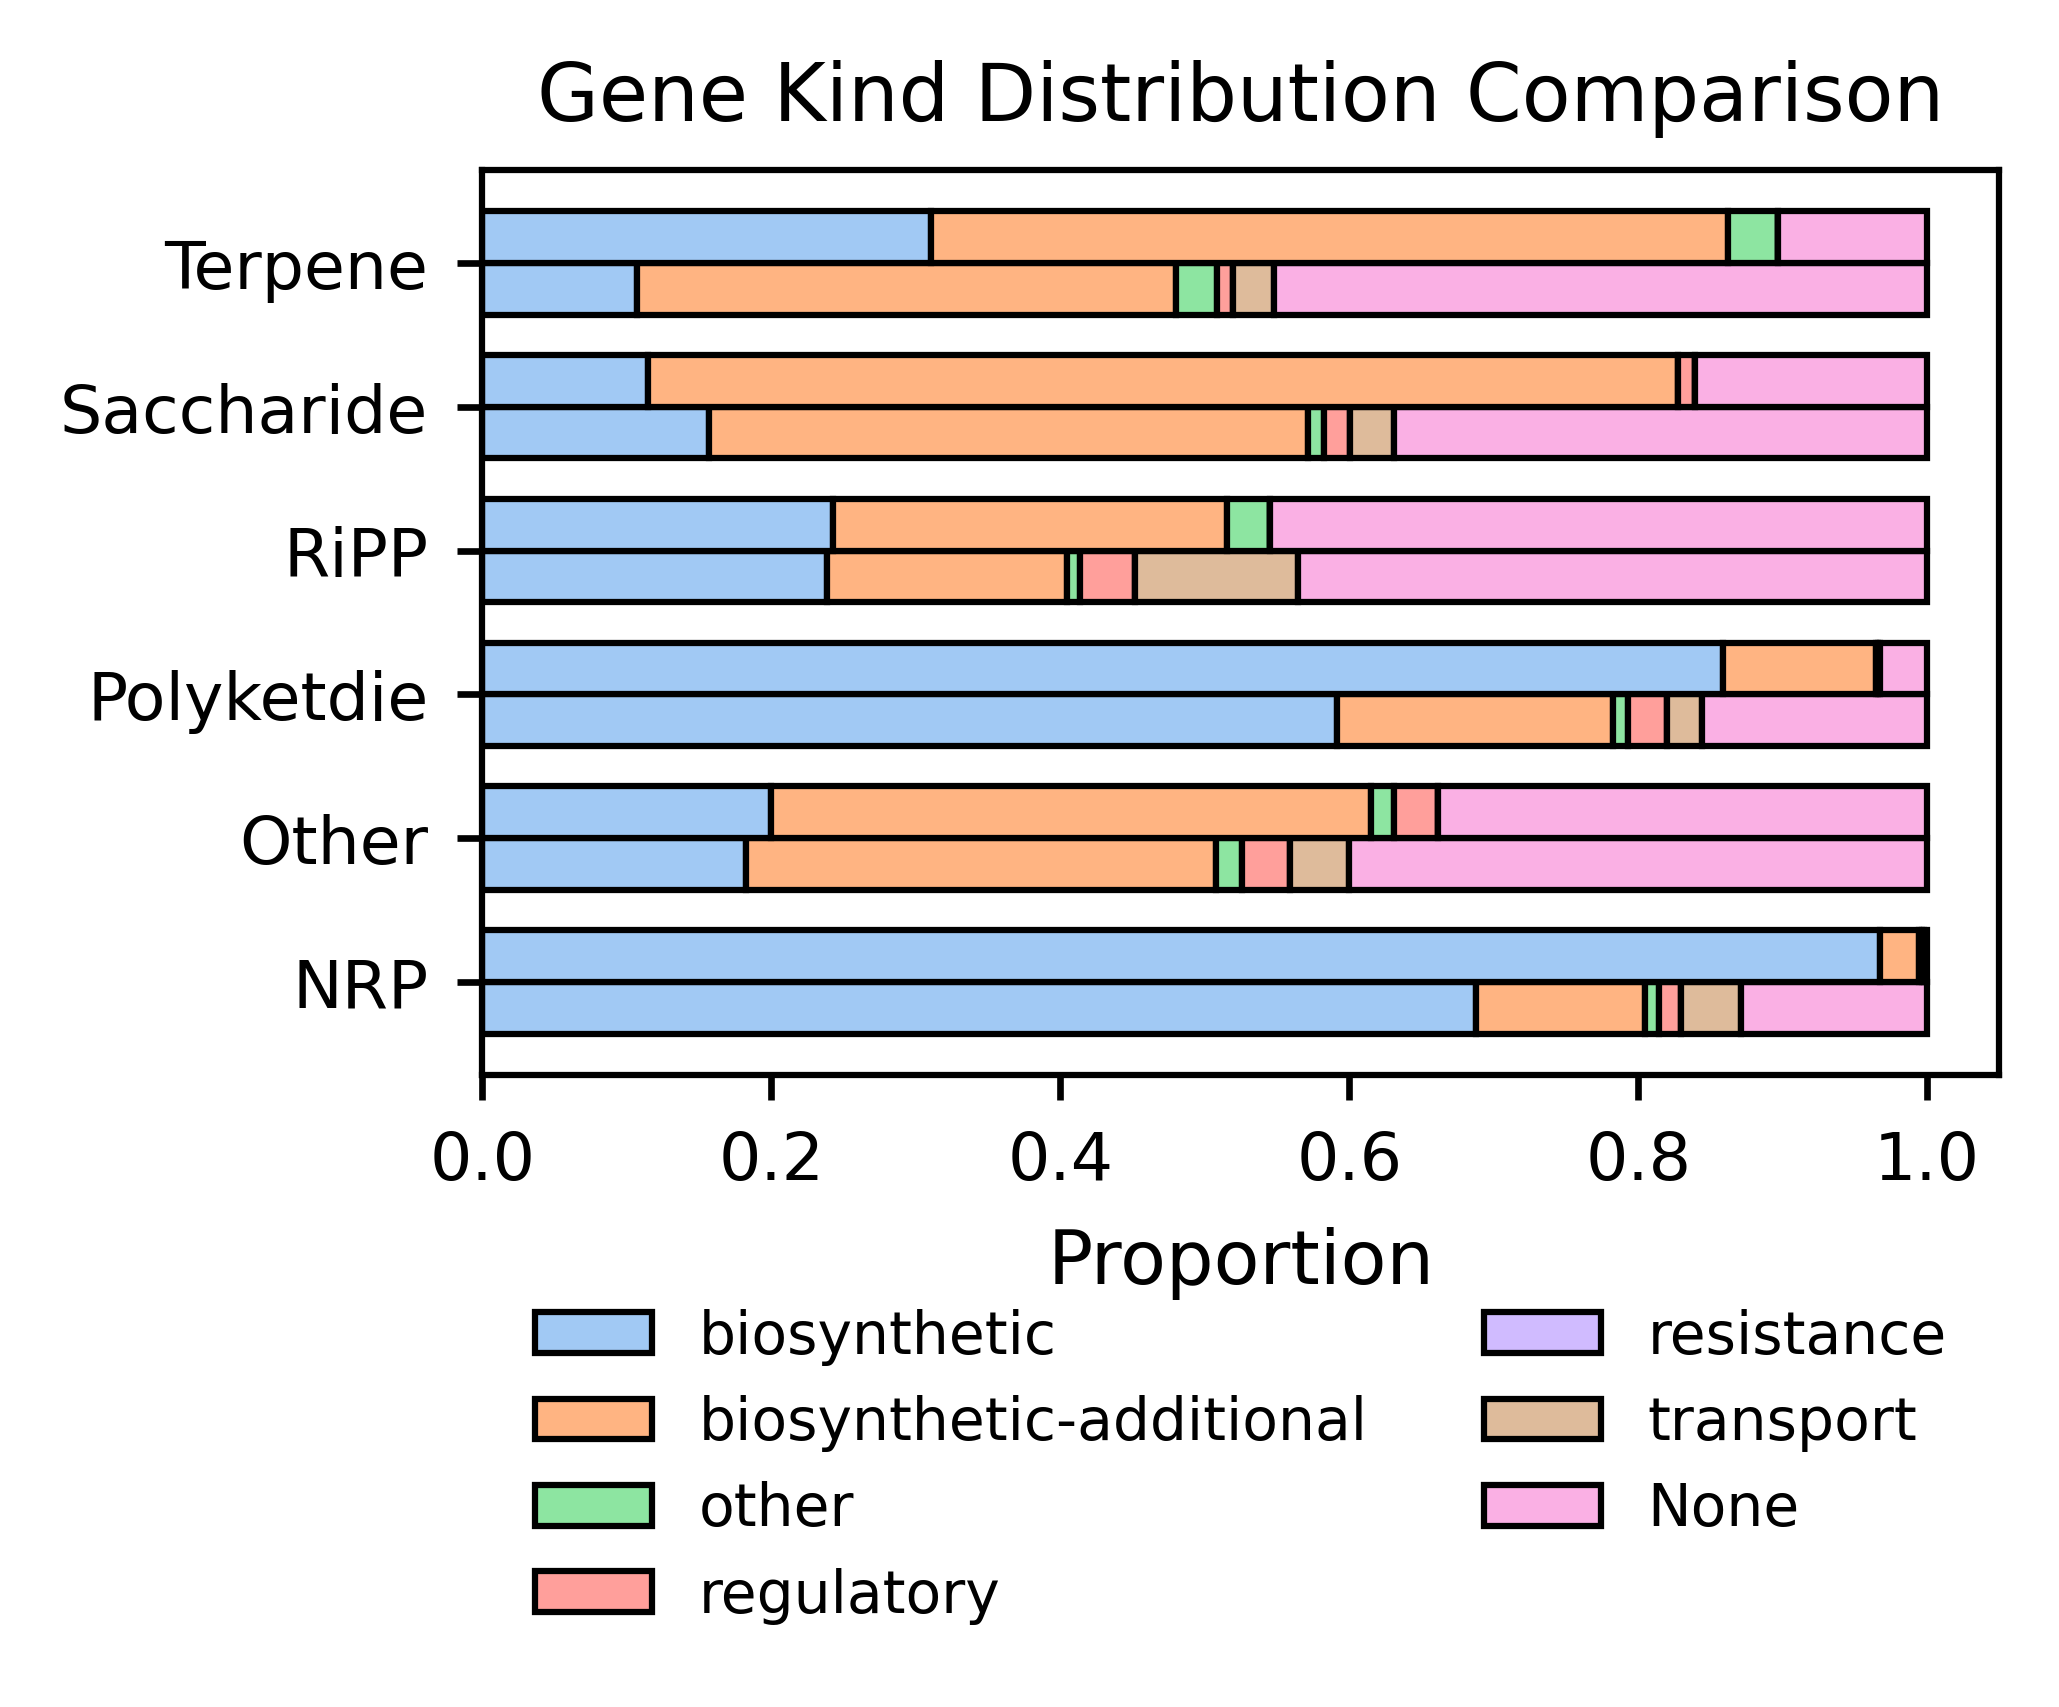

In [ ]:
def plot_two_lists(list1, list2, class_dict, save_dir = None):

    list1 = [{k if k is not None else "None": v for k, v in d.items()} for d in list1]
    list2 = [{k if k is not None else "None": v for k, v in d.items()} for d in list2]

    categories = sorted(set(k for d in list1 + list2 for k in d.keys()))
    if "None" in categories:  
        categories.append(categories.pop(categories.index("None")))

    pairs = [list(class_dict.keys())[i] for i in range(len(list1))]


    color_palette = sns.color_palette("pastel", len(categories)) 

    plt.figure(figsize=(250/72, 220/72))

    y = np.arange(len(list1))  
    width = 1.0  

    for i, (data1, data2) in enumerate(zip(list1, list2)):
        total1 = sum(data1.values())
        total2 = sum(data2.values())
        proportions1 = [data1.get(cat, 0) / total1 if total1 > 0 else 0 for cat in categories]
        proportions2 = [data2.get(cat, 0) / total2 if total2 > 0 else 0 for cat in categories]

        proportions1 = np.array(proportions1)
        proportions2 = np.array(proportions2)
        proportions1 = proportions1 / proportions1.sum() if proportions1.sum() > 0 else proportions1
        proportions2 = proportions2 / proportions2.sum() if proportions2.sum() > 0 else proportions2

        # --- list1  ---
        left = 0  
        for j, proportion in enumerate(proportions1):
            plt.barh(y[i] - 0.18, proportion, height=0.36, left=left,
                     color=color_palette[j], edgecolor='black', linewidth = .75)  
            left += proportion

        # ---  list2  ---
        left = 0
        for j, proportion in enumerate(proportions2):
            plt.barh(y[i] + 0.18, proportion, height=0.36, left=left,
                     color=color_palette[j], edgecolor='black', linewidth = .75)  
            left += proportion

    plt.yticks(y, pairs)
    plt.xticks()
    plt.xlabel("Proportion", )
    plt.title('Gene Kind Distribution Comparison')  

    plt.legend(categories, bbox_to_anchor=(0.5, -0.2), loc='upper center',
               fontsize=7, ncol=2, frameon=False, title_fontsize=14)

    plt.tight_layout()  

    if save_dir is not None:
      plt.savefig(os.path.join(save_dir, "Gene_Distribution_Comparison.pdf"), format='pdf')
      print(f"picture saved to{save_dir}")
    plt.show()


plot_two_lists(gk_counter, gk_high_attn, class_dict, save_dir = "./figures")

In [ ]:
def compare_top_n_categories(
    list1,
    list2,
    pair_names,
    top_n=0,
):

    def stringify_keys(d):
        return {str(k): v for k, v in d.items()}

    list1_clean = [stringify_keys(d) for d in list1]
    list2_clean = [stringify_keys(d) for d in list2]

    if len(list1_clean) != len(list2_clean):
        raise ValueError("list1 和 list2 的长度必须相同。")

    all_categories = set()
    selected_keys_per_pair = [] 
    for d in list2_clean:
        if top_n > 0:
            sorted_keys = sorted(d.items(), key=lambda item: item[1], reverse=True)[:top_n]
            selected_keys = [k for k, v in sorted_keys]
        else:
            selected_keys = list(d.keys())
        selected_keys_per_pair.append(selected_keys)
        all_categories.update(selected_keys)

    all_categories = sorted(all_categories)

    combined_df = pd.DataFrame(index=all_categories)

    for name, idx in pair_names.items():
        if idx >= len(list1_clean) or idx >= len(list2_clean):
            raise IndexError(f"索引 {idx} 超出了 list1 或 list2 的范围。")

        keys_to_include = selected_keys_per_pair[idx]

        list1_dist = list1_clean[idx]
        list2_dist = list2_clean[idx]

        list1_filtered = {k: list1_dist.get(k, 0) for k in keys_to_include}
        list2_filtered = {k: list2_dist.get(k, 0) for k in keys_to_include}

        combined_df[(name, 'Origin')] = pd.Series(list1_filtered)
        combined_df[(name, 'High_attn')] = pd.Series(list2_filtered)

    combined_df.fillna(0, inplace=True)

    combined_df = combined_df.round(2)

    sorted_columns = []
    for name in pair_names.keys():
        sorted_columns.extend([(name, 'Origin'), (name, 'High_attn')])
    combined_df = combined_df.reindex(columns=pd.MultiIndex.from_tuples(sorted_columns))


    return combined_df

class_dict = { 'NRPS': 0, 'other': 1, 'PKS': 2, 'ribosomal': 3, 'saccharide': 4, 'terpene': 5}
df=compare_top_n_categories(pfam_origin_pct, pfam_high_attn_pct, class_dict, top_n=0)
filtered_rows = df[(df > 0).sum(axis=1) > 2]
filtered_rows

NRPS            other              PKS           ribosomal  \
                Origin High_attn Origin High_attn Origin High_attn    Origin   
3Beta_HSD         0.00      0.00   0.88      2.06   0.00      0.00       0.0   
ACPS              0.20      0.19   0.33      1.03   0.00      0.00       0.0   
ACP_syn_III       0.00      0.00   0.44      1.03   0.12      0.16       0.0   
ACP_syn_III_C     0.00      0.00   0.66      2.06   0.24      0.70       0.0   
ADH_N             0.00      0.00   0.22      1.03   1.02      0.08       0.0   
ADH_zinc_N        0.00      0.00   0.44      1.03   0.97      0.08       0.0   
AMP-binding       9.16     33.71   2.41      2.06   0.00      0.00       0.0   
Abhydrolase_1     0.00      0.00   0.77      1.03   0.00      0.00       0.0   
Acyl-CoA_dh_1     0.00      0.00   0.55      1.03   0.26      0.54       0.0   
Acyl-CoA_dh_M     0.00      0.00   0.55      1.03   0.28      0.54       0.0   
Acyl-CoA_dh_N     0.00      0.00   0.55      1.03   0.24      0.39       0.0   
Acyl_transf_1     0.00      0.00   0.55      1.03   5.55      9.63       0.0   
BBE               0.00      0.00   0.22      1.03   0.10      0.16       0.0   
Bac_luciferase    0.00      0.00   0.00      0.00   0.16      0.16       0.3   
Chal_sti_synt_C   0.00      0.00   0.11      1.03   0.02      0.08       0.0   
Chal_sti_synt_N   0.00      0.00   0.11      1.03   0.02      0.08       0.0   
Chorismate_bind   0.00      0.00   0.33      1.03   0.05      0.08       0.0   
Condensation     10.34     40.26   0.00      0.00   1.92      1.09       0.0   
DXPR_C            0.00      0.00   0.11      1.03   0.00      0.00       0.0   
DXP_redisom_C     0.00      0.00   0.11      1.03   0.00      0.00       0.0   
DXP_reductoisom   0.00      0.00   0.11      1.03   0.00      0.00       0.0   
DegT_DnrJ_EryC1   0.00      0.00   0.44      1.03   0.29      0.31       0.0   
Epimerase         0.00      0.00   0.88      2.06   1.73      0.16       0.0   
EryCIII-like_C    0.00      0.00   0.11      1.03   0.62      1.55       0.0   
EryCIII-like_N    0.00      0.00   0.00      0.00   0.52      1.55       0.0   
FAD_binding_4     0.00      0.00   0.55      2.06   0.19      0.23       0.0   
FAE1_CUT1_RppA    0.00      0.00   0.11      1.03   0.02      0.08       0.0   
GATase            0.00      0.00   0.33      1.03   0.02      0.08       0.0   
GDP_Man_Dehyd     0.00      0.00   0.77      2.06   0.43      0.08       0.0   
GFO_IDH_MocA      0.00      0.00   0.00      0.00   0.21      0.16       0.0   
GFO_IDH_MocA_C3   0.00      0.00   0.00      0.00   0.19      0.16       0.0   
Glyco_trans_1_4   0.00      0.00   0.22      1.03   0.00      0.00       0.0   
Glycos_transf_1   0.00      0.00   0.22      1.03   0.00      0.00       0.0   
HMG_CoA_synt_C    0.00      0.00   0.11      1.03   0.10      0.16       0.0   
HTH_18            0.15      0.19   0.00      0.00   0.12      0.16       0.0   
HTH_AraC          0.13      0.19   0.00      0.00   0.10      0.16       0.0   
KAsynt_C_assoc    0.65      0.37   0.00      0.00   0.78      2.87       0.0   
Ketoacyl-synt_C   5.16      2.43   1.64      3.09   7.83     30.90       0.0   
Methyltransf_2    0.00      0.00   0.88      1.03   0.31      0.08       0.0   
NAD_binding_4     0.00      0.00   0.44      1.03   0.00      0.00       0.0   
NTP_transferase   0.00      0.00   0.00      0.00   0.17      0.39       0.0   
Nitroreductase    0.00      0.00   0.22      1.03   0.02      0.08       0.0   
PKS_DH_N          1.84      0.19   0.00      0.00   3.07      6.06       0.0   
Polysacc_synt_2   0.00      0.00   0.33      1.03   0.00      0.00       0.0   
RmlD_sub_bind     0.00      0.00   0.33      1.03   0.00      0.00       0.0   
Thiolase_N        0.00      0.00   0.11      1.03   0.16      0.54       0.0   
Transferase       0.00      0.00   0.22      1.03   0.00      0.00       0.0   
UDPGT             0.00      0.00   0.22      2.06   0.10      0.08       0.0   
ketoacyl-synt     

In [ ]:
def compare_top_n_categories(
    list1,
    list2,
    pair_names,
    top_n=0,
    return_combined=True
):


    def stringify_keys(d):
        return {str(k): v for k, v in d.items()}

    list1_clean = [stringify_keys(d) for d in list1]
    list2_clean = [stringify_keys(d) for d in list2]

    if len(list1_clean) != len(list2_clean):
        raise ValueError("list1 和 list2 的长度必须相同。")

    all_categories = set()
    selected_keys_per_pair = []  
    for d in list2_clean:
        if top_n > 0:
            sorted_keys = sorted(d.items(), key=lambda item: item[1], reverse=True)[:top_n]
            selected_keys = [k for k, v in sorted_keys]
        else:
            selected_keys = list(d.keys())
        selected_keys_per_pair.append(selected_keys)
        all_categories.update(selected_keys)

    all_categories = sorted(all_categories)

    list_of_dfs = []

    for name, idx in pair_names.items():
        if idx >= len(list1_clean) or idx >= len(list2_clean):
            print(f"警告: 索引 {idx} 超出了 list1 或 list2 的范围。跳过配对 '{name}'。")
            continue

        keys_to_include = selected_keys_per_pair[idx]

        list1_dist = list1_clean[idx]
        list2_dist = list2_clean[idx]

        list1_filtered = {k: list1_dist.get(k, 0) for k in keys_to_include}
        list2_filtered = {k: list2_dist.get(k, 0) for k in keys_to_include}

        df = pd.DataFrame({
            'Origin': pd.Series(list1_filtered),
            'High_attn': pd.Series(list2_filtered)
        })

        df.fillna(0, inplace=True)

        df = df.round(2)

        df.index.name = 'Category'

        list_of_dfs.append(df)

    if return_combined:
        combined_df = pd.DataFrame(index=all_categories)

        for df, name in zip(list_of_dfs, pair_names.keys()):
            categories = df.index
            origin_data = df['Origin']
            high_attn_data = df['High_attn']

            combined_df[(name, 'Origin')] = origin_data
            combined_df[(name, 'High_attn')] = high_attn_data

        combined_df.fillna(0, inplace=True)

        combined_df = combined_df.round(2)

        sorted_columns = []
        for name in pair_names.keys():
            sorted_columns.extend([(name, 'Origin'), (name, 'High_attn')])
        combined_df = combined_df.reindex(columns=pd.MultiIndex.from_tuples(sorted_columns))

        return combined_df
    else:
        return list_of_dfs

df_list = compare_top_n_categories(pfam_origin_pct, pfam_high_attn_pct, class_dict, top_n=5, return_combined=False)
for dfs in df_list:
  display(dfs)

Origin  High_attn
Category                          
Condensation      10.34      40.26
AMP-binding        9.16      33.71
PP-binding        13.69      19.10
ketoacyl-synt      5.23       2.43
Ketoacyl-synt_C    5.16       2.43

Origin  High_attn
Category                          
Ketoacyl-synt_C    1.64       3.09
ketoacyl-synt      1.75       3.09
AMP-binding        2.41       2.06
Pyr_redox_2        0.66       2.06
Reductase_C        0.44       2.06

Origin  High_attn
Category                          
ketoacyl-synt      7.92      31.21
Ketoacyl-synt_C    7.83      30.90
Acyl_transf_1      5.55       9.63
PKS_DH_N           3.07       6.06
KAsynt_C_assoc     0.78       2.87

Origin  High_attn
Category                         
Gallidermin       0.59      11.76
LANC_like         4.44      11.76
Bac_luciferase    0.30       5.88
APH               0.89       5.88
DUF5972           0.30       5.88

Origin  High_attn
Category                          
Glycos_transf_1    1.91       7.91
Glyco_trans_1_4    1.91       7.34
Epimerase          3.95       7.34
GDP_Man_Dehyd      3.11       6.78
Glycos_transf_2    3.35       5.65

Origin  High_attn
Category                          
polyprenyl_synt    3.36      18.18
SQS_PSY            2.52      12.12
p450               7.98       9.09
Terpene_syn_C_2    2.10       6.06
DIT1_PvcA          0.84       6.06

picture saved to/data5_large/home/kechenlu/natural_product/visualization/file_MAC_multihead


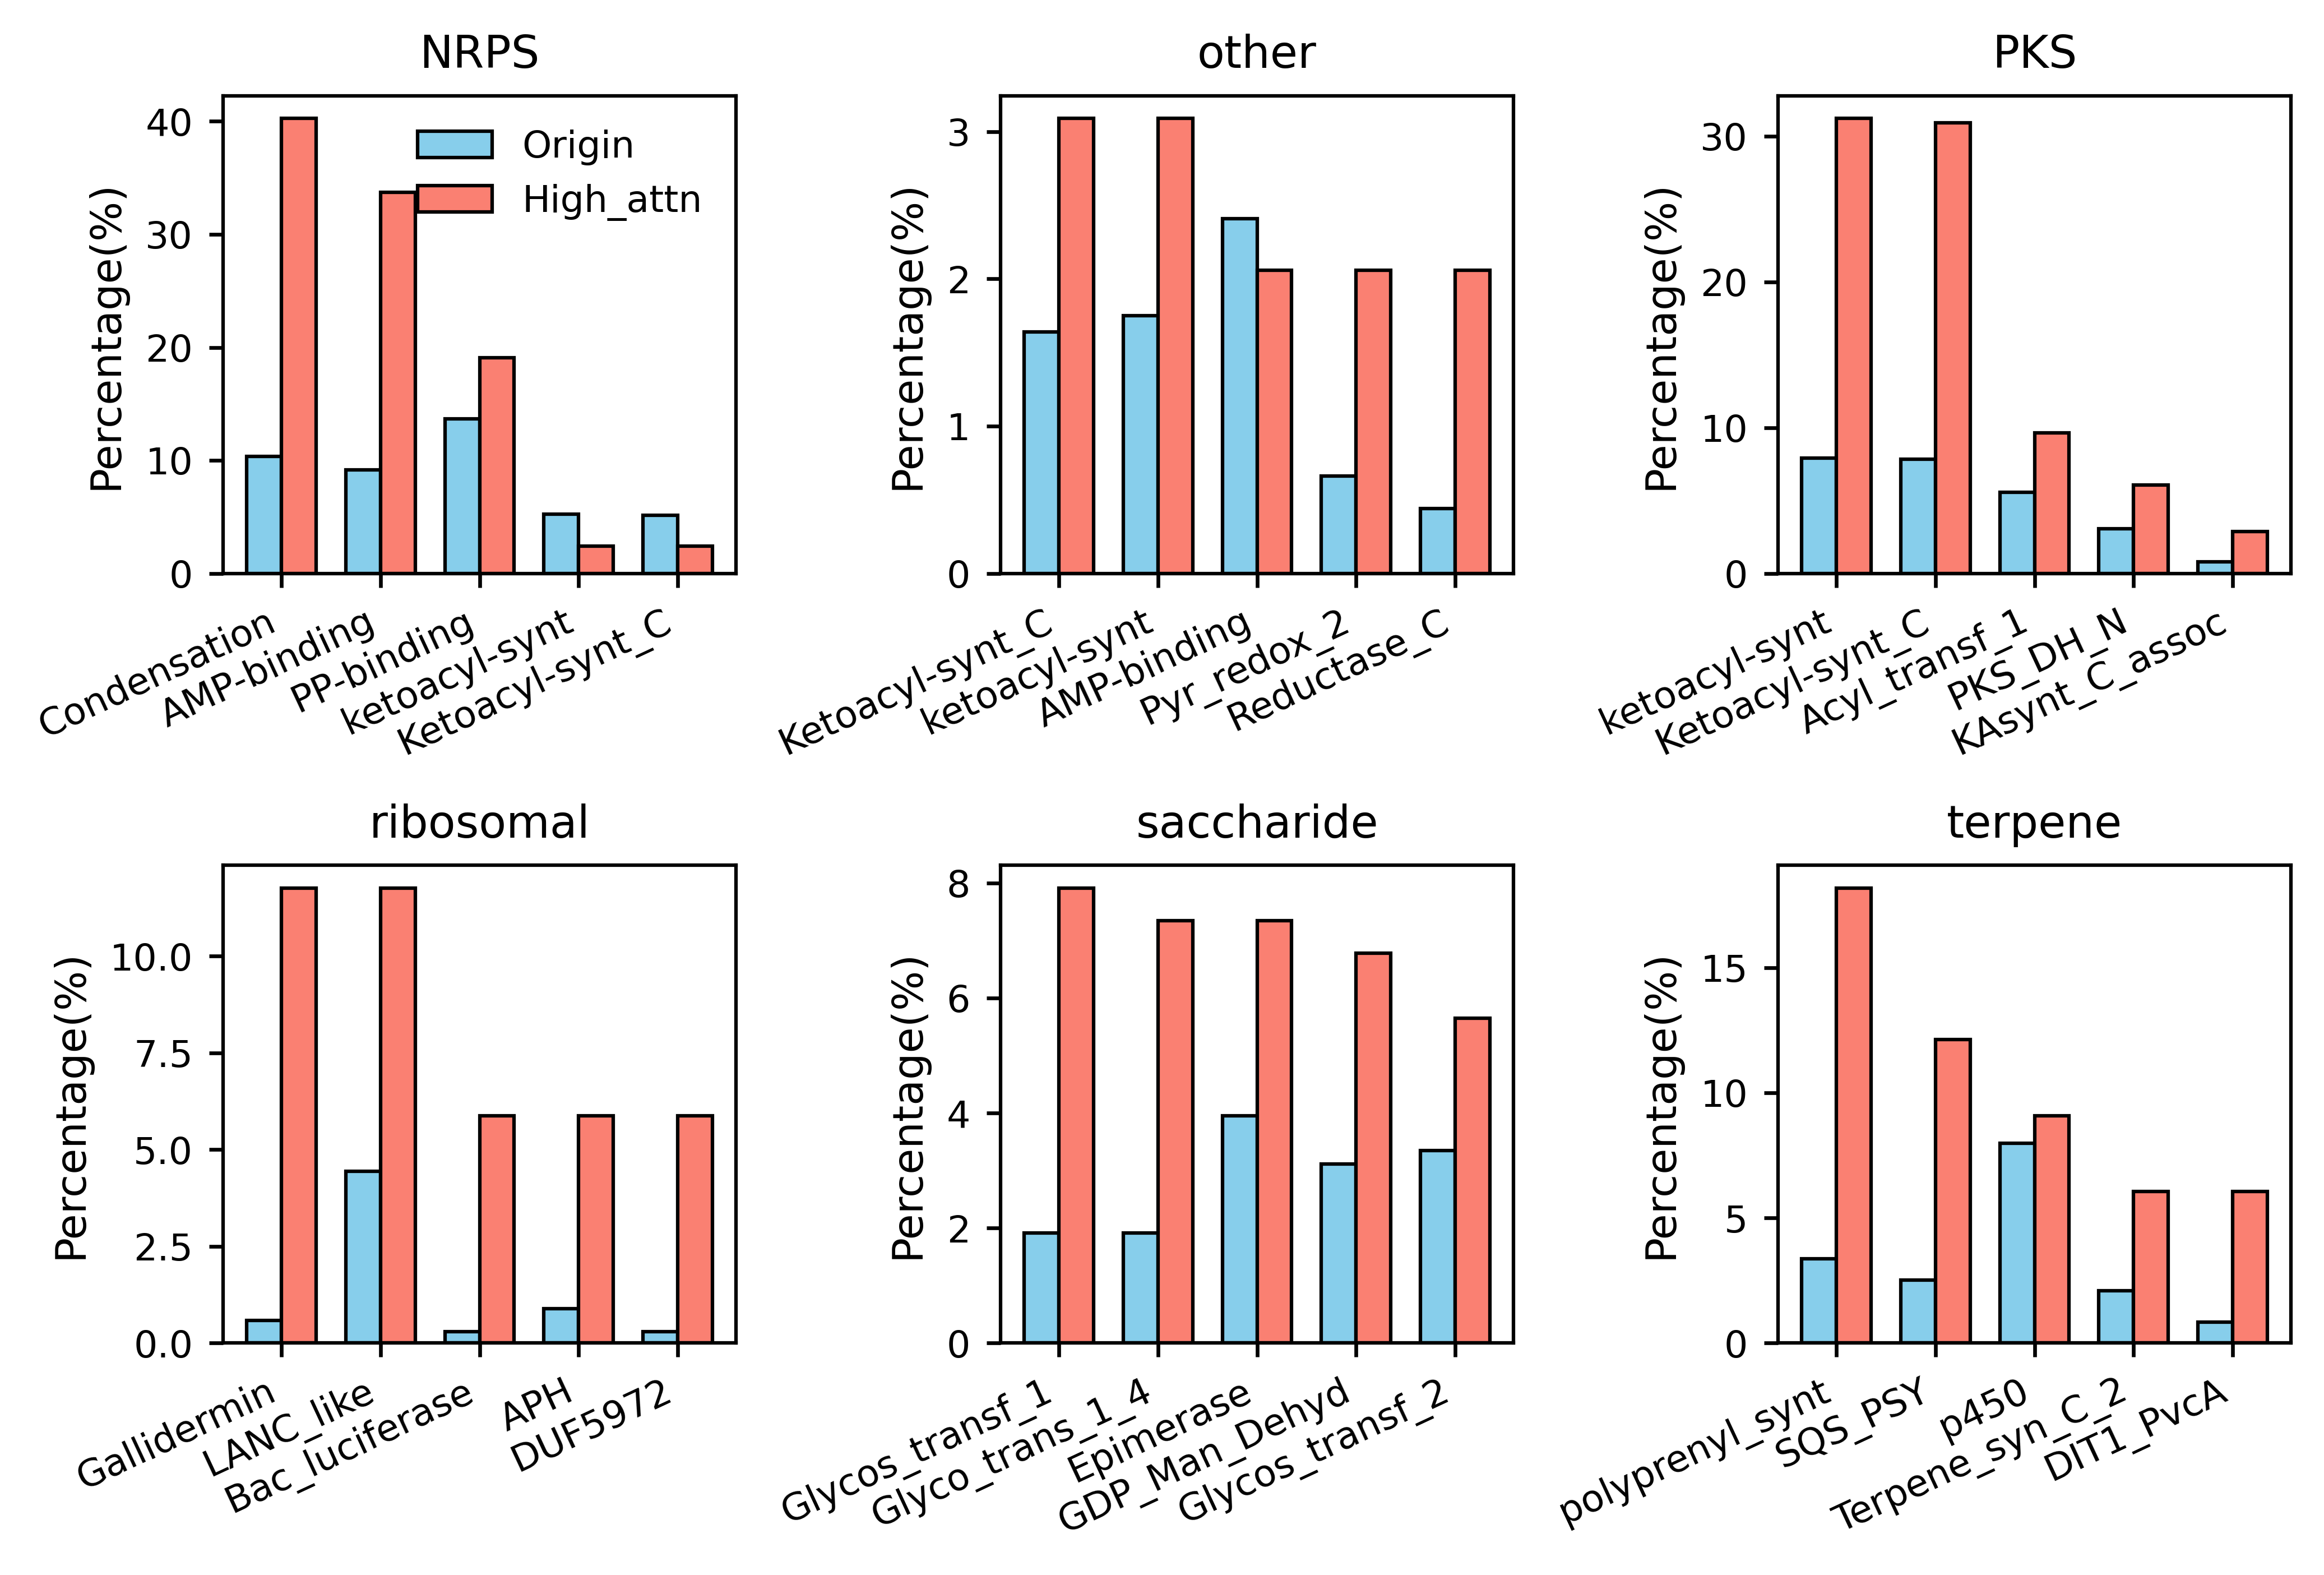

In [28]:
def plot_multiple_bar_charts(df_list, titles=None, figsize = (500/72, 340/72), labels1='Origin', labels2='High_attn', save_dir = None):
    """
    Generates a figure containing multiple grouped bar charts as subplots,
    one for each DataFrame in df_list.

    Args:
        df_list (list of pd.DataFrame): A list of Pandas DataFrames. Each DataFrame
                                        should have an index as categories and at least
                                        two columns named 'Origin' and 'High_attn' (or
                                        columns corresponding to labels1 and labels2).
        titles (list of str, optional): A list of titles for each subplot. If None,
                                         default titles will be used (e.g., "Chart 1", "Chart 2", ...).
                                         Defaults to None.
        labels1 (str, optional): Label for the first set of bars (default 'Origin').
        labels2 (str, optional): Label for the second set of bars (default 'High_attn').
    """
    num_charts = len(df_list)
    if num_charts == 0:
        print("df_list is empty, no charts to plot.")
        return

    # Determine subplot layout (adjust rows and cols as needed)
    if num_charts <= 2:
        rows = 1
        cols = num_charts
    elif num_charts <= 6:
        rows = 2
        cols = 3
    else: # For more than 6 charts, adjust layout accordingly
        rows = 3
        cols = (num_charts + 2) // 3 # Ensure enough columns

    fig, axes = plt.subplots(rows, cols, figsize=figsize) # Adjust figsize based on layout

    if not isinstance(axes, np.ndarray): # Handle case when axes is not an array (only one subplot)
        axes = np.array([axes]) # Make it an array for consistent indexing

    axes = axes.flatten() # Flatten axes array for easy iteration

    for i, df in enumerate(df_list):
        if i >= len(axes): # Break if more charts than subplots (shouldn't happen with layout logic)
            break
        ax = axes[i] # Get current subplot axes

        if df.empty: # Handle empty DataFrame
            ax.set_title(f"Chart {i+1} (Empty DataFrame)")
            ax.axis('off') # Turn off axes for empty subplot
            continue

        categories = df.index.tolist()
        values1 = df[labels1].tolist() # Use labels1 argument
        values2 = df[labels2].tolist() # Use labels2 argument

        x = np.arange(len(categories))
        bar_width = 0.35

        bar1 = ax.bar(x - bar_width/2, values1, bar_width, label=labels1, color='skyblue', edgecolor='black', linewidth = .75) # Use labels1
        bar2 = ax.bar(x + bar_width/2, values2, bar_width, label=labels2, color='salmon', edgecolor='black', linewidth = .75) # Use labels2

        # Set subplot title, labels, ticks, and legend
        if titles:
            ax.set_title(titles[i])
        else:
            ax.set_title(f"Chart {i+1}")

        #ax.set_xlabel("Category", fontsize=12)
        ax.set_ylabel("Percentage(%)")
        ax.set_xticks(x)
        ax.set_xticklabels(categories, rotation=25, ha='right')
        ax.tick_params(axis='y',) # Adjust y tick font size

        if i == 0: # Only show legend on the first subplot to avoid redundancy
            ax.legend()

    # Remove any unused subplots if num_charts is less than the layout size
    for j in range(num_charts, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    if save_dir is not None:
      plt.savefig(os.path.join(save_dir, "Domain_Distribution_Comparison.pdf"), format='pdf')
      print(f"picture saved to{save_dir}")
    plt.show()

plot_multiple_bar_charts(df_list, titles = list(class_dict.keys()), labels1='Origin', labels2='High_attn', save_dir = save_dir)

## MAP performance

In [11]:
model_cfg = cfg.BGC_MAP
ckpt_name = "MAP_2025-08-16_23-22-12"
test_name = os.path.basename(cfg.MAP_metadata).split(".")[0]
test_data = pd.read_pickle(os.path.join("..", model_cfg.checkpoint_dir, f"test_{test_name}_{model_cfg.data.random_seed}.pkl"))
ckpt_path = os.path.join("..", model_cfg.checkpoint_dir, ckpt_name)
individual_evaluation = pickle.load(open(os.path.join(ckpt_path, "MAP_test_individual.pkl"), "rb"))

ensemble_evaluation = pickle.load(open(os.path.join(ckpt_path, "MAP_test_ensemble.pkl"), "rb"))
print(ensemble_evaluation.keys())
print(individual_evaluation.keys())
true = ensemble_evaluation["true_labels"].copy()
pred = ensemble_evaluation["pred"].copy()
print(true.shape)
print(pred.shape)
print(len(test_data))


dict_keys(['pred', 'metrics', 'true_labels', 'attn_weight'])
dict_keys(['pred', 'metrics', 'true_labels', 'attn_weight'])
(2525, 1)
(2525, 1)
2525


In [22]:
data_for_save = test_data.drop(columns = ["enzyme_list", "protein_rep", "pfam", "gene_kind", "product_index"])
data_for_save["prediction_score"] = list(pred)
data_for_save["prediction_score"] = data_for_save["prediction_score"].apply(lambda x:x[0])
data_for_save.to_csv(f"/home/kchlu/link_name/natural_product/ckpt/BGC_MAP/{ckpt_name}/result.csv")

### Figure 4

In [12]:
individual_pred = individual_evaluation["pred"].copy()
expanded_pred = np.expand_dims(pred, axis = 0)
all_pred = np.concatenate([expanded_pred, individual_pred], axis = 0)
print(all_pred.shape)
print(individual_pred.shape)
ensemble_metrics = ensemble_evaluation["metrics"].copy()
individual_metrics = individual_evaluation["metrics"].copy()
all_metrics = individual_metrics
all_metrics["f1"] = [all_metrics["f1"]]
for key in all_metrics:
    all_metrics[key].insert(0, ensemble_metrics[key])


(10, 2525, 1)
(9, 2525, 1)


In [14]:

class_dict = { 'NRPS': 0, 'other': 1, 'PKS': 2, 'ribosomal': 3, 'saccharide': 4, 'terpene': 5}
class_index = [[] for i in range(6)]
biosyn_class = test_data["biosyn_class"].to_list()

for i, BGC in enumerate(biosyn_class):
  for BGC_class in BGC:
    class_index[class_dict[BGC_class]].append(i)


class_trues = [true[class_index[i]] for i in range(6)]

class_preds = {
    "all": [],
    **{f'ensemble_{i}': [] for i in range(9)}
}

for i, ensemble in enumerate(class_preds):
  class_preds[ensemble] = [all_pred[i][class_index[j]] for j in range(6)]

class_preds_round = {}
for i, ensemble in enumerate(class_preds):
  class_preds_round[ensemble] = [np.round(pred) for pred in class_preds[ensemble]]

In [ ]:
model_recall = {key:all_metrics["overall_recall"][i] for i, key in enumerate(class_preds)}
model_precision = {key:all_metrics["overall_precision"][i] for i, key in enumerate(class_preds)}
model_auc = {key:torch.tensor([all_metrics["overall_auc"][i]]) for i, key in enumerate(class_preds)}

for ensemble in class_preds_round:
  for i, class_pred in enumerate(class_preds_round[ensemble]):
    recall = recall_cal(torch.tensor(class_trues[i]), torch.tensor(class_pred), 0.5)
    precision = precision_cal(torch.tensor(class_trues[i]), torch.tensor(class_pred), 0.5)
    model_recall[ensemble] = np.concatenate((model_recall[ensemble], recall), axis = 0)
    model_precision[ensemble]= np.concatenate((model_precision[ensemble], precision), axis = 0)


for ensemble in class_preds_round:
  for i, class_pred in enumerate(class_preds[ensemble]):
    class_auc = auc_cal(torch.tensor(class_trues[i]), torch.tensor(class_pred))
    model_auc[ensemble] = np.concatenate((model_auc[ensemble], class_auc), axis = 0)

print(model_auc)
print(model_recall)
print(model_precision)

{'all': array([0.84311611, 0.87255693, 0.82529028, 0.83942718, 0.92285479,
       0.78442105, 0.82561883]), 'ensemble_0': array([0.83213784, 0.84786118, 0.80424528, 0.82896162, 0.93729373,
       0.81347368, 0.82151182]), 'ensemble_1': array([0.81875835, 0.85554448, 0.77685051, 0.82388548, 0.88407591,
       0.76968421, 0.74314574]), 'ensemble_2': array([0.79576779, 0.80917565, 0.76040155, 0.80898095, 0.88531353,
       0.64842105, 0.80952381]), 'ensemble_3': array([0.83747513, 0.87178148, 0.82855588, 0.82196334, 0.93605611,
       0.76463158, 0.83238983]), 'ensemble_4': array([0.8001682 , 0.8485575 , 0.81119981, 0.77140369, 0.91254125,
       0.80631579, 0.77500278]), 'ensemble_5': array([0.80644729, 0.8401304 , 0.74268263, 0.81120574, 0.90924092,
       0.74147368, 0.78177378]), 'ensemble_6': array([0.8225317 , 0.85057526, 0.80853895, 0.80946414, 0.9150165 ,
       0.78736842, 0.76989677]), 'ensemble_7': array([0.81314687, 0.83268449, 0.79547654, 0.81388718, 0.87128713,
       0.7473

In [9]:
display(pd.DataFrame(model_auc))


all  ensemble_0  ensemble_1  ensemble_2  ensemble_3  ensemble_4  \
0  0.843116    0.832138    0.818758    0.795768    0.837475    0.800168   
1  0.872557    0.847861    0.855544    0.809176    0.871781    0.848558   
2  0.825290    0.804245    0.776851    0.760402    0.828556    0.811200   
3  0.839427    0.828962    0.823885    0.808981    0.821963    0.771404   
4  0.922855    0.937294    0.884076    0.885314    0.936056    0.912541   
5  0.784421    0.813474    0.769684    0.648421    0.764632    0.806316   
6  0.825619    0.821512    0.743146    0.809524    0.832390    0.775003   

   ensemble_5  ensemble_6  ensemble_7  ensemble_8  
0    0.806447    0.822532    0.813147    0.808129  
1    0.840130    0.850575    0.832684    0.841681  
2    0.742683    0.808539    0.795477    0.796867  
3    0.811206    0.809464    0.813887    0.798829  
4    0.909241    0.915017    0.871287    0.881188  
5    0.741474    0.787368    0.747368    0.745263  
6    0.781774    0.769897    0.811078    0.817960

In [10]:
display(pd.DataFrame(model_precision))

with pd.ExcelWriter(os.path.join(CURRENT_DIR, "visualization", "table", "MAP_performance.xlsx"), engine="openpyxl") as writer:
    pd.DataFrame(model_precision).to_excel(writer, sheet_name="Precision", index=False)
    pd.DataFrame(model_recall).to_excel(writer, sheet_name="recall", index=False)
    pd.DataFrame(model_auc).to_excel(writer, sheet_name="auc", index=False)

all  ensemble_0  ensemble_1  ensemble_2  ensemble_3  ensemble_4  \
0  0.420863    0.384025    0.360164    0.369919    0.407407    0.392704   
1  0.445833    0.389961    0.383607    0.385000    0.448889    0.442396   
2  0.402985    0.333333    0.350515    0.327273    0.442857    0.446429   
3  0.445230    0.414414    0.369110    0.413793    0.401993    0.388393   
4  0.411765    0.400000    0.285714    0.285714    0.428571    0.300000   
5  0.342857    0.350000    0.341463    0.153846    0.343750    0.392857   
6  0.375000    0.380282    0.303030    0.396552    0.351351    0.333333   

   ensemble_5  ensemble_6  ensemble_7  ensemble_8  
0    0.376344    0.378657    0.372549    0.359756  
1    0.428571    0.397260    0.389078    0.390681  
2    0.342105    0.368421    0.386364    0.376238  
3    0.413428    0.396667    0.382609    0.367601  
4    0.300000    0.400000    0.315789    0.280000  
5    0.279070    0.272727    0.270270    0.285714  
6    0.322581    0.308642    0.352941    0.349206

In [11]:
display(pd.DataFrame(model_recall))


all  ensemble_0  ensemble_1  ensemble_2  ensemble_3  ensemble_4  \
0  0.617414    0.659631    0.696570    0.480211    0.609499    0.482850   
1  0.699346    0.660131    0.764706    0.503268    0.660131    0.627451   
2  0.519231    0.538462    0.653846    0.346154    0.596154    0.480769   
3  0.639594    0.700508    0.715736    0.548223    0.614213    0.441624   
4  0.583333    0.666667    0.666667    0.333333    0.500000    0.500000   
5  0.631579    0.736842    0.736842    0.210526    0.578947    0.578947   
6  0.615385    0.692308    0.512821    0.589744    0.666667    0.435897   

   ensemble_5  ensemble_6  ensemble_7  ensemble_8  
0    0.554090    0.580475    0.651715    0.622691  
1    0.607843    0.568627    0.745098    0.712418  
2    0.500000    0.538462    0.653846    0.730769  
3    0.593909    0.604061    0.670051    0.598985  
4    0.500000    0.500000    0.500000    0.583333  
5    0.631579    0.473684    0.526316    0.736842  
6    0.512821    0.641026    0.615385    0.564103

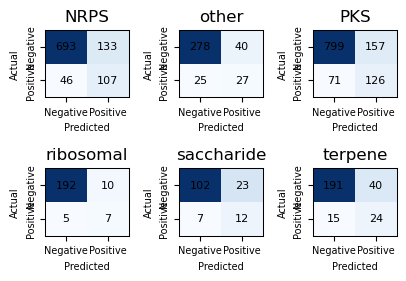

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_multiple_confusion_matrices(true_list, pred_list, titles, class_names=None, save_dir = None):
    if len(true_list) != len(pred_list) or len(true_list) != len(titles):
        raise ValueError("true_list, pred_list, and titles must have the same length.")

    num_matrices = len(true_list)

    cols = math.ceil(math.sqrt(num_matrices))
    rows = math.ceil(num_matrices / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(300 / 72, 210 / 72))
    axes = np.array(axes).flatten()  

    for i, (true, pred, title) in enumerate(zip(true_list, pred_list, titles)):
        ax = axes[i]
        if not isinstance(true, torch.Tensor):
            true = torch.tensor(true)
        if not isinstance(pred, torch.Tensor):
            pred = torch.tensor(pred)

        cm = confusion_matrix(true.numpy(), pred.numpy())
        num_classes = cm.shape[0]
        if class_names is None:
            class_names = [f'Class {i}' for i in range(num_classes)]

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=class_names, yticklabels=class_names,
                    #linewidths = .5,
                    #linecolor='black',
                    annot_kws={"size": 8, "color": 'black'}, 
                    ax=ax) 
        for spine in ax.spines.values():
          spine.set_visible(True)  
          spine.set_linewidth(.75)   
          spine.set_edgecolor('black')

        ax.set_title(title)
        ax.set_xticks(np.arange(num_classes)+0.5)
        ax.set_yticks(np.arange(num_classes)+0.5)
        ax.set_xticklabels(class_names, rotation=0, size = 7)
        ax.set_yticklabels(class_names, rotation = 90, va='center', size = 7)

        ax.set_ylabel('Actual', size = 7 )
        ax.set_xlabel('Predicted', size = 7)


    for j in range(num_matrices, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    if save_dir is not None:
      plt.savefig(os.path.join(save_dir, "MAP-confusion_matrix.pdf"), format='pdf')

    plt.show()

class_names = ['Negative', 'Positive']

plot_multiple_confusion_matrices(class_trues, class_preds_round["all"], titles = list(class_dict.keys()) ,class_names=class_names, save_dir = "./figures")


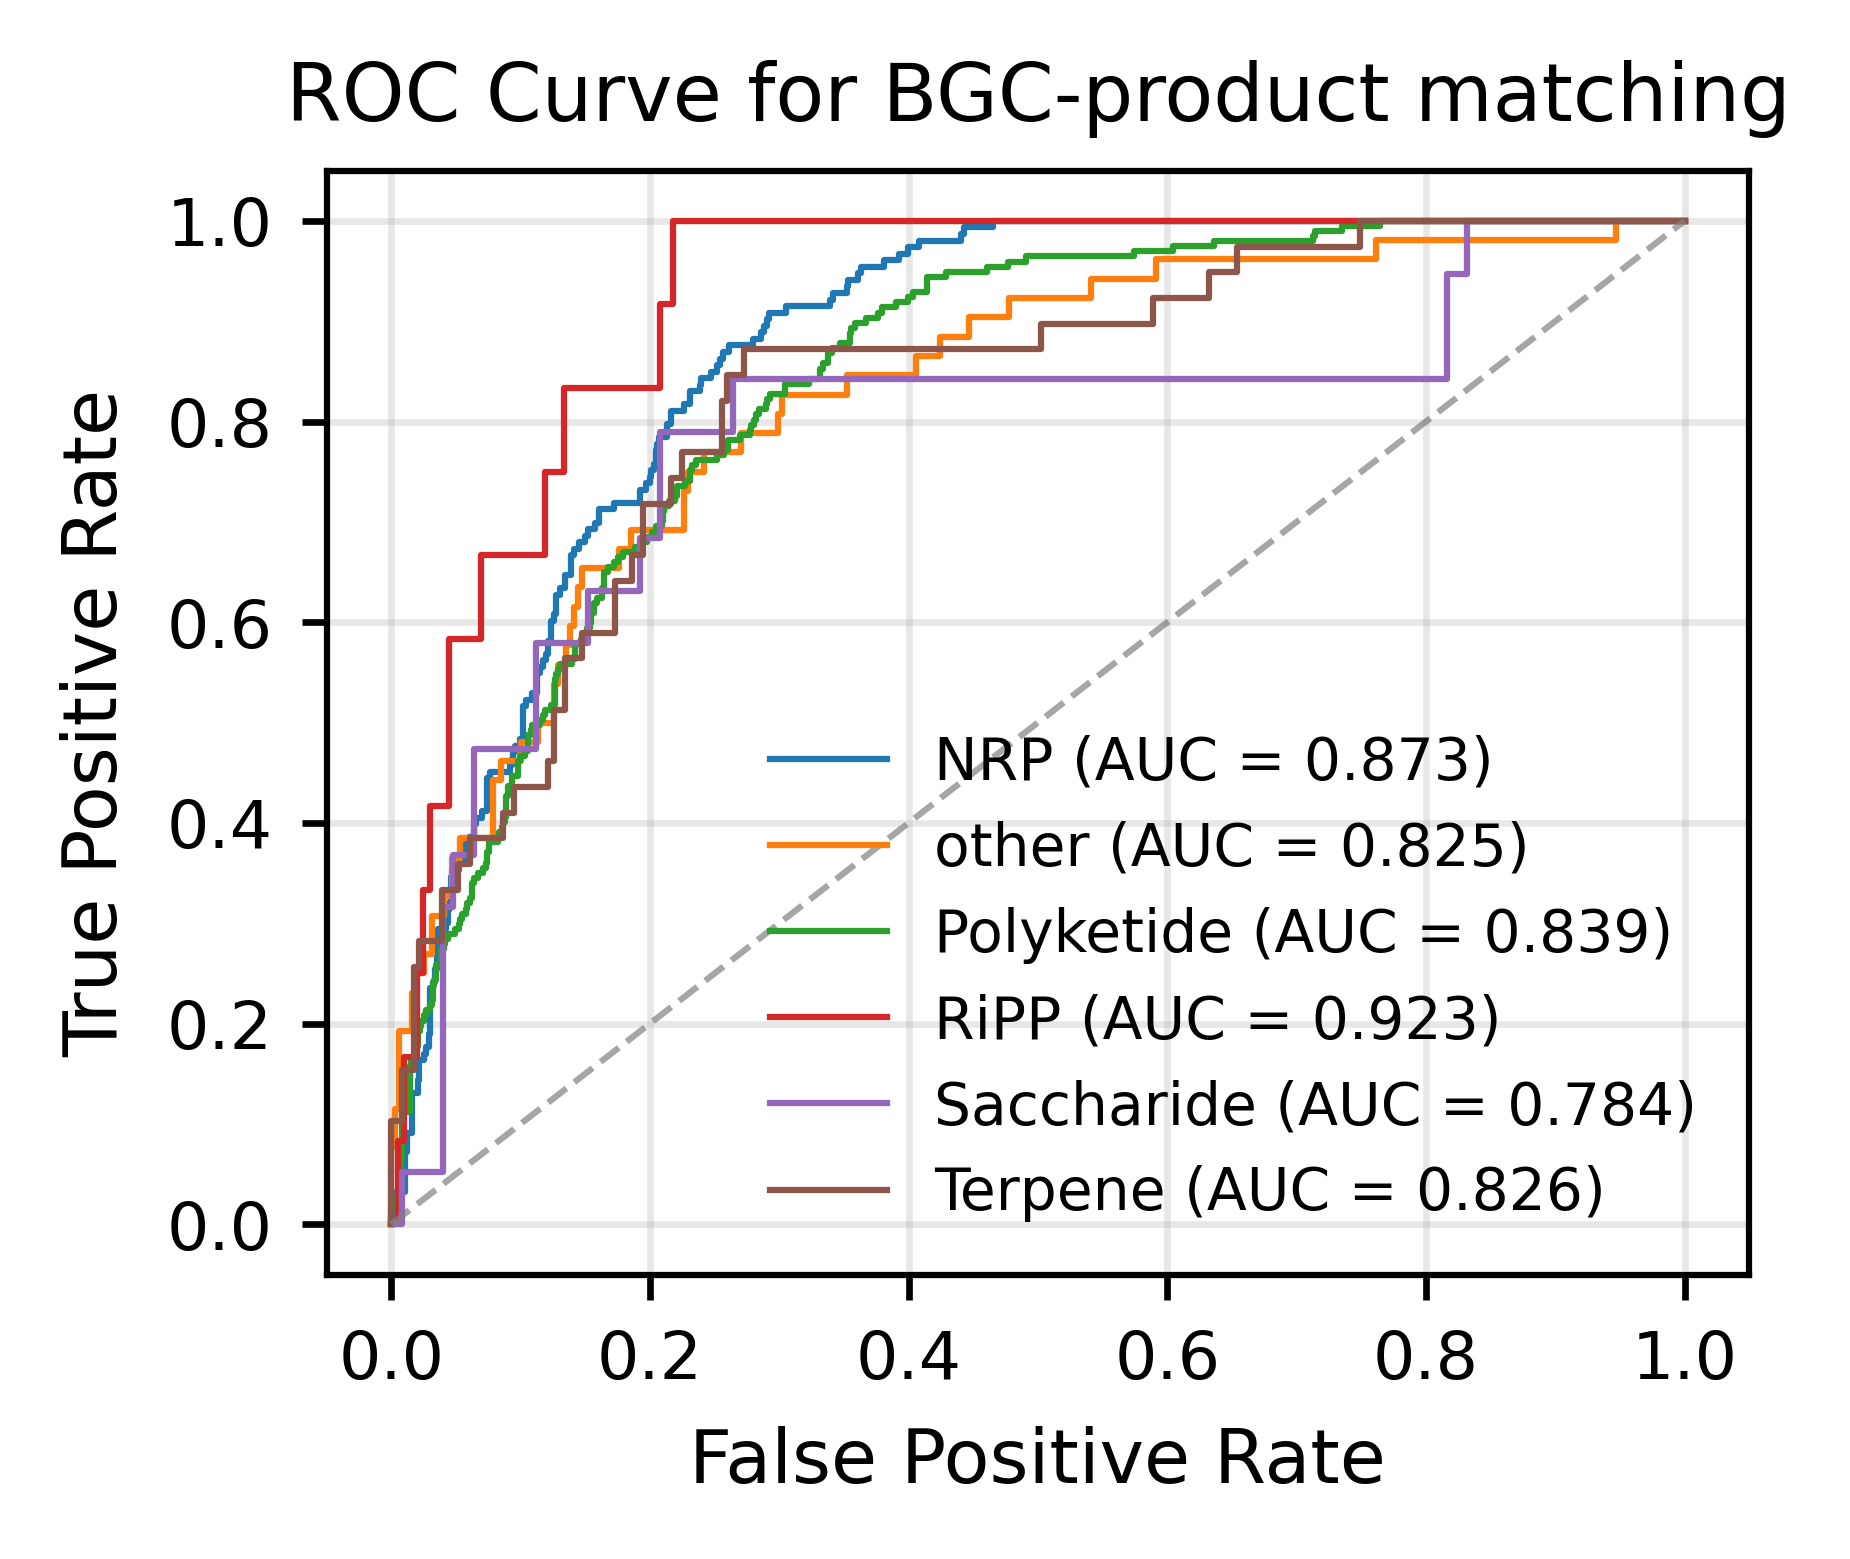

In [18]:
def plot_roc_curves(true_list, pred_list, class_labels=None, figsize=(10, 8), save_dir = None):
    """
    Plot ROC curves for multiple classes.

    Parameters:
        true (ndarray): Ground truth binary labels (shape: [n_samples, n_classes]).
        pred (ndarray): Predicted probabilities (shape: [n_samples, n_classes]).
        class_labels (list): List of class labels (default: [Class 1, Class 2, ...]).
        figsize (tuple): Size of the figure (default: (10, 8)).
    """
    n_classes = len(true_list)
    class_labels = class_labels or ["NRP", "other", "Polyketide", "RiPP", "Saccharide", "Terpene"]

    plt.figure(figsize=figsize)

    for i in range(n_classes):
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(true_list[i], pred_list[i])
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.3f})')

    # Plot diagonal line for reference
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.7)

    # Add labels, legend, and title
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.yticks()
    plt.xticks()
    plt.title('ROC Curve for BGC-product matching')
    plt.legend(loc='lower right', fontsize=7)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    if save_dir is not None:
      plt.savefig(os.path.join(save_dir, "MAP_auroc.pdf"), format='pdf')
    plt.show()

plot_roc_curves(class_trues, class_preds["all"], class_labels=None, figsize=(220/72, 190/72), save_dir = "./figures")

###  Figure 5 Interpretation

In [52]:
#BGC_num = "BGC0000448"
#BGC_num = "BGC0002209"
#BGC_num = "BGC0001007"
#BGC_num = "BGC0000693"
#BGC_num = "BGC0001790"
#BGC_num = "BGC0002786"
BGC_num = "BGC0000676"
#BGC_num = "BGC0000045"

display(test_data[(test_data["BGC_number"] == BGC_num) & (test_data["is_product"] == 1)])
attn_weight = ensemble_evaluation["attn_weight"]

BGC_number                                            product  \
23615  BGC0000676  CC1(C)CCC[C@@]2(C)[C@H]1CC[C@H]1C[C@H]3C[C@@]1...   

      biosyn_class                                        enzyme_list  \
23615    [terpene]  [MAYTVEPREHSKNTTLPTVAMPPSPPSSFSASFGPFRYDTKEVNF...   

       is_product                                      product_index  \
23615           1  [tensor(33), tensor(33), tensor(21), tensor(18...   

                                             protein_rep  \
23615  [[tensor(0.0582), tensor(-0.0406), tensor(0.08...   

                                                    pfam  \
23615  [(polyprenyl_synt,), error, (p450,), (MFS_1,),...   

                                               gene_kind  
23615  [biosynthetic, None, biosynthetic-additional, ...

In [53]:

def intepretation(BGC_num, test_data, attn_weight):
    object_row = test_data[(test_data["BGC_number"] == BGC_num) & (test_data["is_product"] == 1)].head(1)
    object_item = object_row.index.item()
    print(pred[object_item-22727])
    print(true[object_item-22727])
    smiles = object_row["product"].item()
    BGC_len = len(object_row["enzyme_list"].item())
    SMI_REGEX_PATTERN = r"(\[[^\]]+\]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|\+|\\\/|:|@|\?|\>|\*|\$|\%[0-9]{2}|[0-9])"
    split = re.findall(SMI_REGEX_PATTERN, smiles)
    smiles_len = len(split)
    objective_map = attn_weight[(object_item-22727) // 16][(object_item-22727) % 16][:BGC_len][:,:smiles_len]
    _1d_attention = list(objective_map.mean(axis=0))
    _1d_attention = [float(x) for x in _1d_attention]
    return split, _1d_attention, BGC_num, smiles, split, objective_map

ticks, _1d_attention, BGC_num, smiles, split, objective_map = intepretation(BGC_num= BGC_num, test_data = test_data, attn_weight=attn_weight)
print(smiles)

[0.68279254]
[1.]
CC1(C)CCC[C@@]2(C)[C@H]1CC[C@H]1C[C@H]3C[C@@]12CC[C@@]3(C)O


In [22]:
from collections import defaultdict

leak = ['BGC0001140', 'BGC0000478', 'BGC0002168', 'BGC0001343', 'BGC0002591', 'BGC0001126', 'BGC0003058', 'BGC0001396', 'BGC0002906', 'BGC0001667', 'BGC0000264', 'BGC0000403', 'BGC0003051', 'BGC0002440', 'BGC0000340', 'BGC0000477', 'BGC0002510', 'BGC0000849', 'BGC0002564', 'BGC0002555', 'BGC0002806', 'BGC0001525', 'BGC0003089', 'BGC0002070', 'BGC0002812', 'BGC0002244', 'BGC0000008', 'BGC0003084', 'BGC0002410', 'BGC0000051', 'BGC0001033', 'BGC0001398', 'BGC0003005', 'BGC0001007', 'BGC0000386', 'BGC0001904', 'BGC0001346', 'BGC0002262', 'BGC0000148', 'BGC0001625', 'BGC0002479', 'BGC0002136', 'BGC0002871', 'BGC0002644', 'BGC0002415', 'BGC0002424', 'BGC0002987', 'BGC0000200', 'BGC0003094', 'BGC0002372', 'BGC0001621', 'BGC0001195', 'BGC0002473', 'BGC0002347', 'BGC0003023', 'BGC0001337', 'BGC0002548', 'BGC0000631', 'BGC0002190', 'BGC0000371', 'BGC0003088', 'BGC0002176', 'BGC0001082', 'BGC0001108', 'BGC0002956', 'BGC0002594', 'BGC0001064', 'BGC0001506', 'BGC0002319', 'BGC0001383', 'BGC0002435', 'BGC0000676', 'BGC0002779', 'BGC0000804', 'BGC0000285', 'BGC0002480', 'BGC0002101', 'BGC0001666', 'BGC0002625', 'BGC0000301', 'BGC0001830', 'BGC0001365', 'BGC0000380', 'BGC0002082', 'BGC0001886', 'BGC0001590', 'BGC0001305', 'BGC0000668', 'BGC0002104', 'BGC0003163', 'BGC0000376', 'BGC0003079', 'BGC0001492', 'BGC0001022', 'BGC0000416', 'BGC0001001', 'BGC0002623', 'BGC0002430', 'BGC0001077', 'BGC0000898', 'BGC0002373', 'BGC0002163', 'BGC0001755', 'BGC0002429', 'BGC0001738', 'BGC0002815', 'BGC0000156', 'BGC0002165', 'BGC0000308', 'BGC0001596', 'BGC0000288', 'BGC0000940', 'BGC0000111', 'BGC0001079', 'BGC0002377', 'BGC0000062', 'BGC0003053', 'BGC0000922', 'BGC0001807', 'BGC0001076', 'BGC0001716', 'BGC0001792', 'BGC0001759', 'BGC0002342', 'BGC0001322', 'BGC0002861', 'BGC0001357', 'BGC0002260', 'BGC0002465', 'BGC0000378', 'BGC0001458', 'BGC0002928', 'BGC0002813', 'BGC0002203', 'BGC0002926', 'BGC0002043', 'BGC0000420', 'BGC0000997', 'BGC0001370', 'BGC0000080', 'BGC0002340', 'BGC0001801', 'BGC0001620', 'BGC0002187', 'BGC0002525', 'BGC0002732', 'BGC0002134', 'BGC0002050', 'BGC0002572', 'BGC0000932', 'BGC0000391', 'BGC0000967', 'BGC0001331', 'BGC0002177', 'BGC0002278', 'BGC0003027', 'BGC0000937', 'BGC0002117', 'BGC0001340', 'BGC0002123', 'BGC0002324', 'BGC0003054', 'BGC0002578', 'BGC0001526', 'BGC0001833', 'BGC0000402', 'BGC0000440', 'BGC0002075', 'BGC0002080', 'BGC0002293', 'BGC0003069', 'BGC0002259', 'BGC0002138', 'BGC0001125', 'BGC0002661', 'BGC0001147', 'BGC0002254', 'BGC0002109', 'BGC0002049', 'BGC0002930']

biosyn_class_all = defaultdict(int) 
biosyn_class_true = defaultdict(int) 
right = 0
for BGC in leak:
    object_row = test_data[(test_data["BGC_number"] == BGC) & (test_data["is_product"] == 1)].head(1)
    object_item = object_row.index.item()
    biosyn_class = object_row.biosyn_class.item()
    for BGC_class in biosyn_class:
        biosyn_class_all[BGC_class] +=1
    if pred[object_item-22727] > 0.5:
        for BGC_class in biosyn_class:
            biosyn_class_true[BGC_class] +=1
        right +=1

print(right)

123


In [23]:
biosyn_class_recall = {k: biosyn_class_true[k]/biosyn_class_all[k] for k in biosyn_class_true}
biosyn_class_recall

{'terpene': 0.7142857142857143,
 'ribosomal': 0.5714285714285714,
 'PKS': 0.6777777777777778,
 'other': 0.5454545454545454,
 'NRPS': 0.7619047619047619,
 'saccharide': 0.8333333333333334}

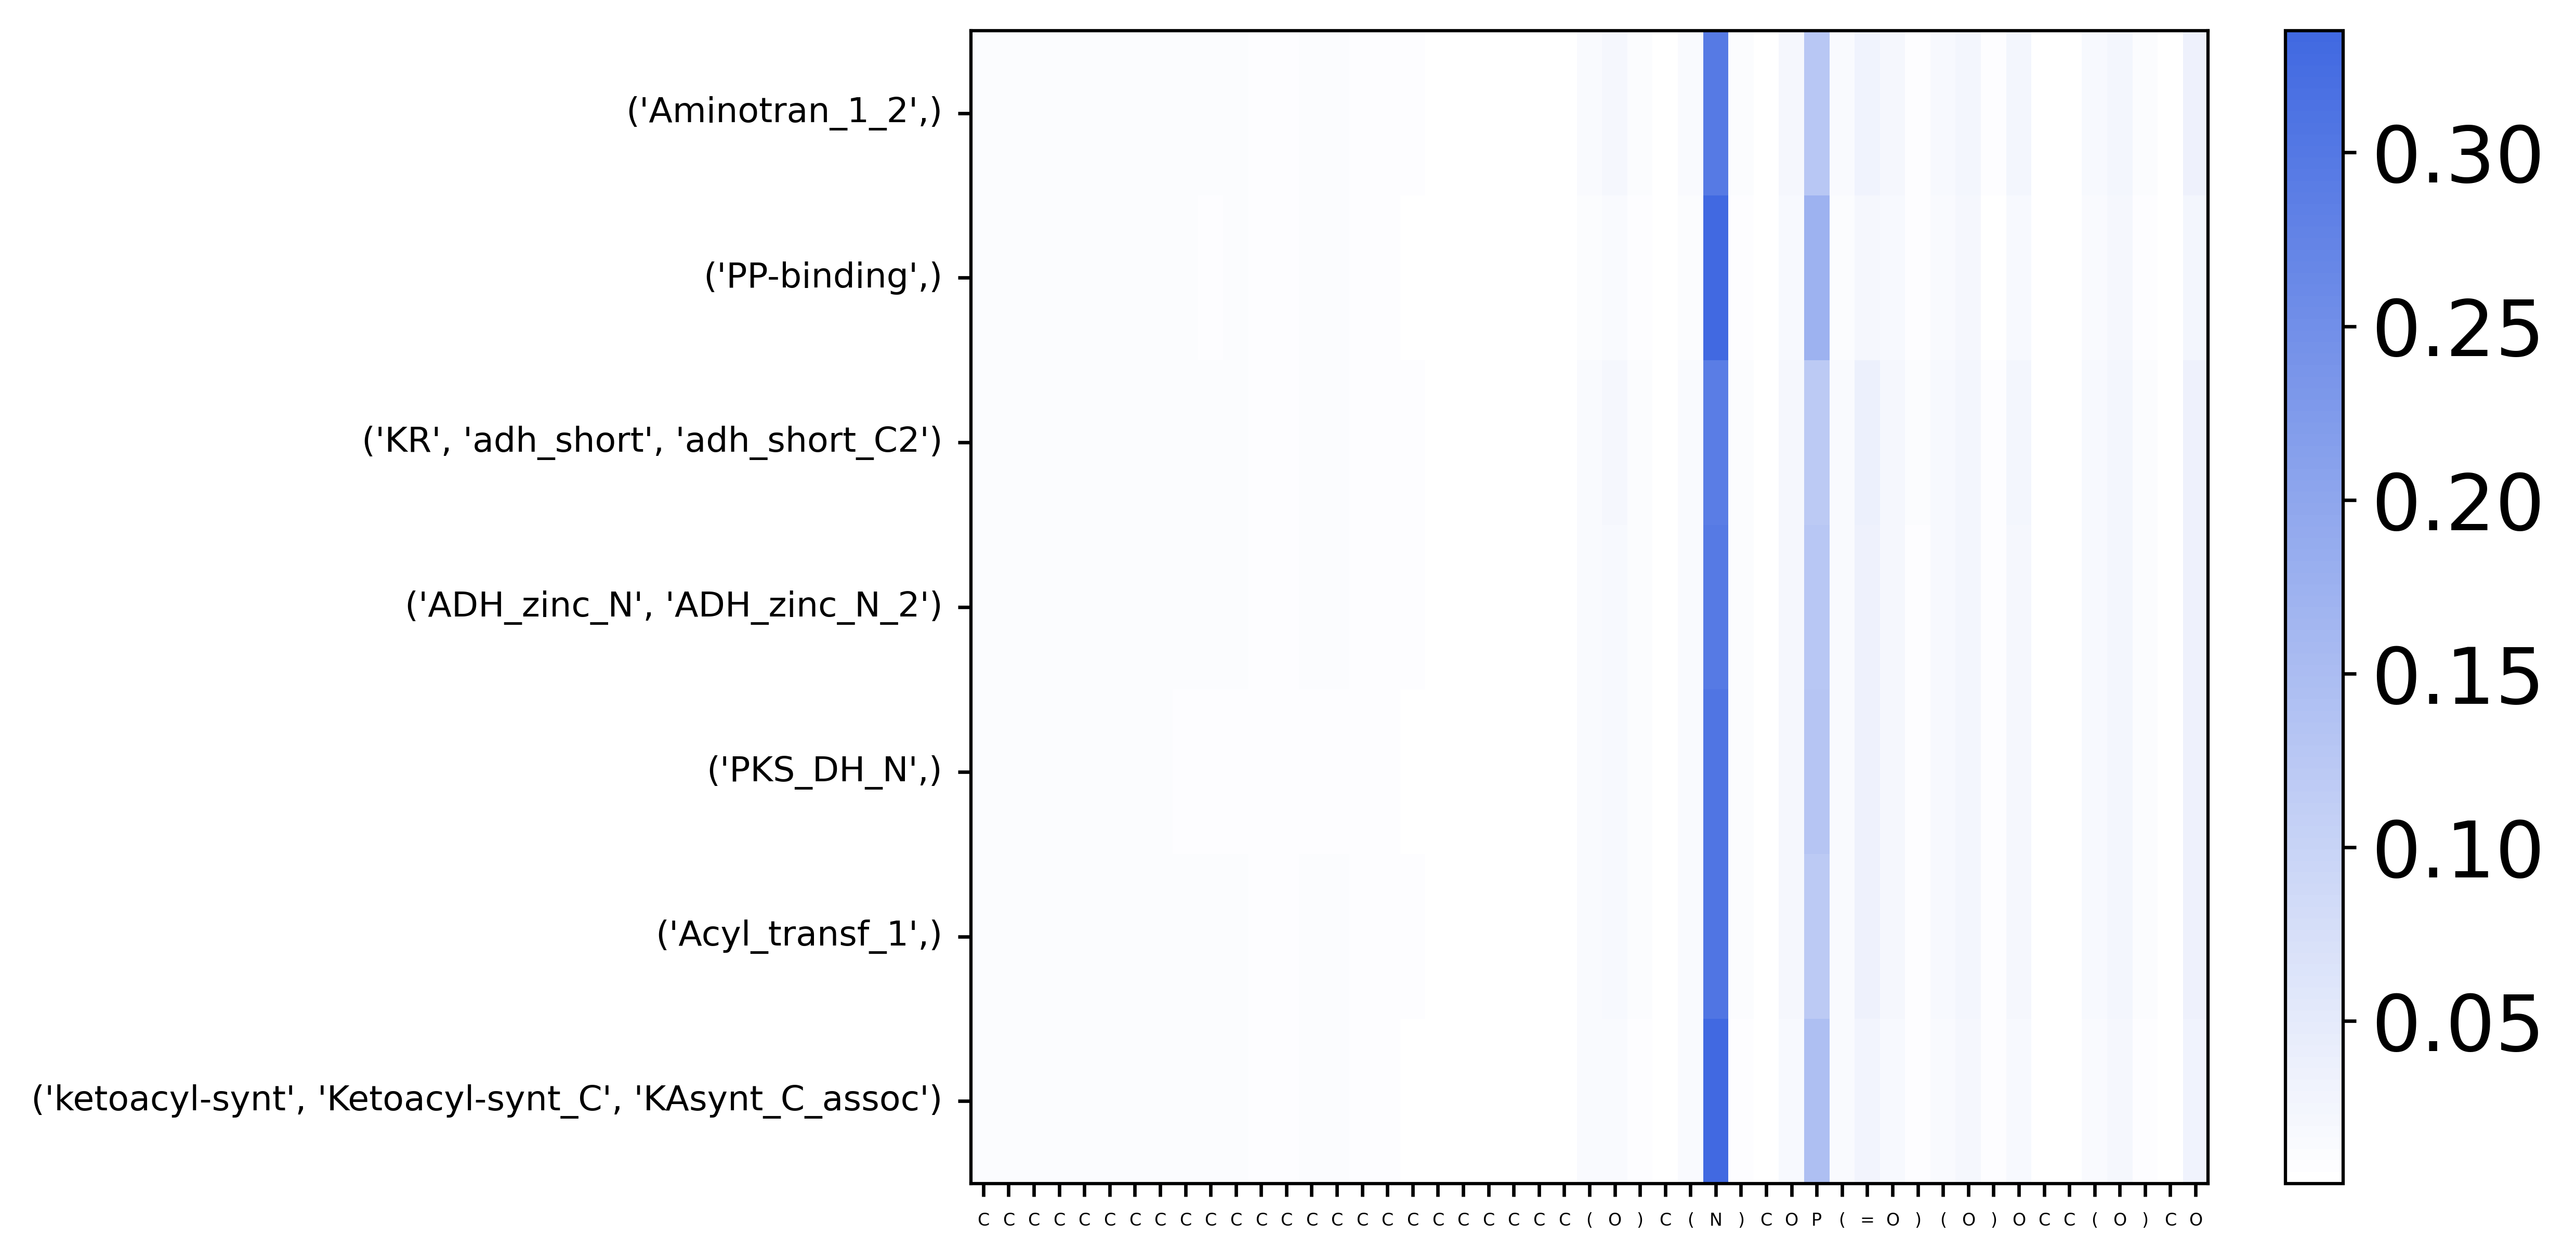

In [ ]:
import matplotlib.colors as mcolors
object_row = test_data[(test_data["BGC_number"] == BGC_num) & (test_data["is_product"] == 1)].head(1)
cmap = sns.diverging_palette(240, 10, s=80, l=50, n=10, as_cmap=True)
colors = [(0, "white"), (1.0, "royalblue")] 
n_bins = 100 
cmap_name = 'custom_blue'

custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

annotation =  object_row["pfam"].item()
ax = sns.heatmap(objective_map, cmap=custom_cmap, xticklabels = split, yticklabels=annotation,cbar=False)
ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
plt.xticks(rotation=0, size=4)

cbar = plt.colorbar(ax.collections[0])
cbar.ax.tick_params(labelsize=18)
plt.show()


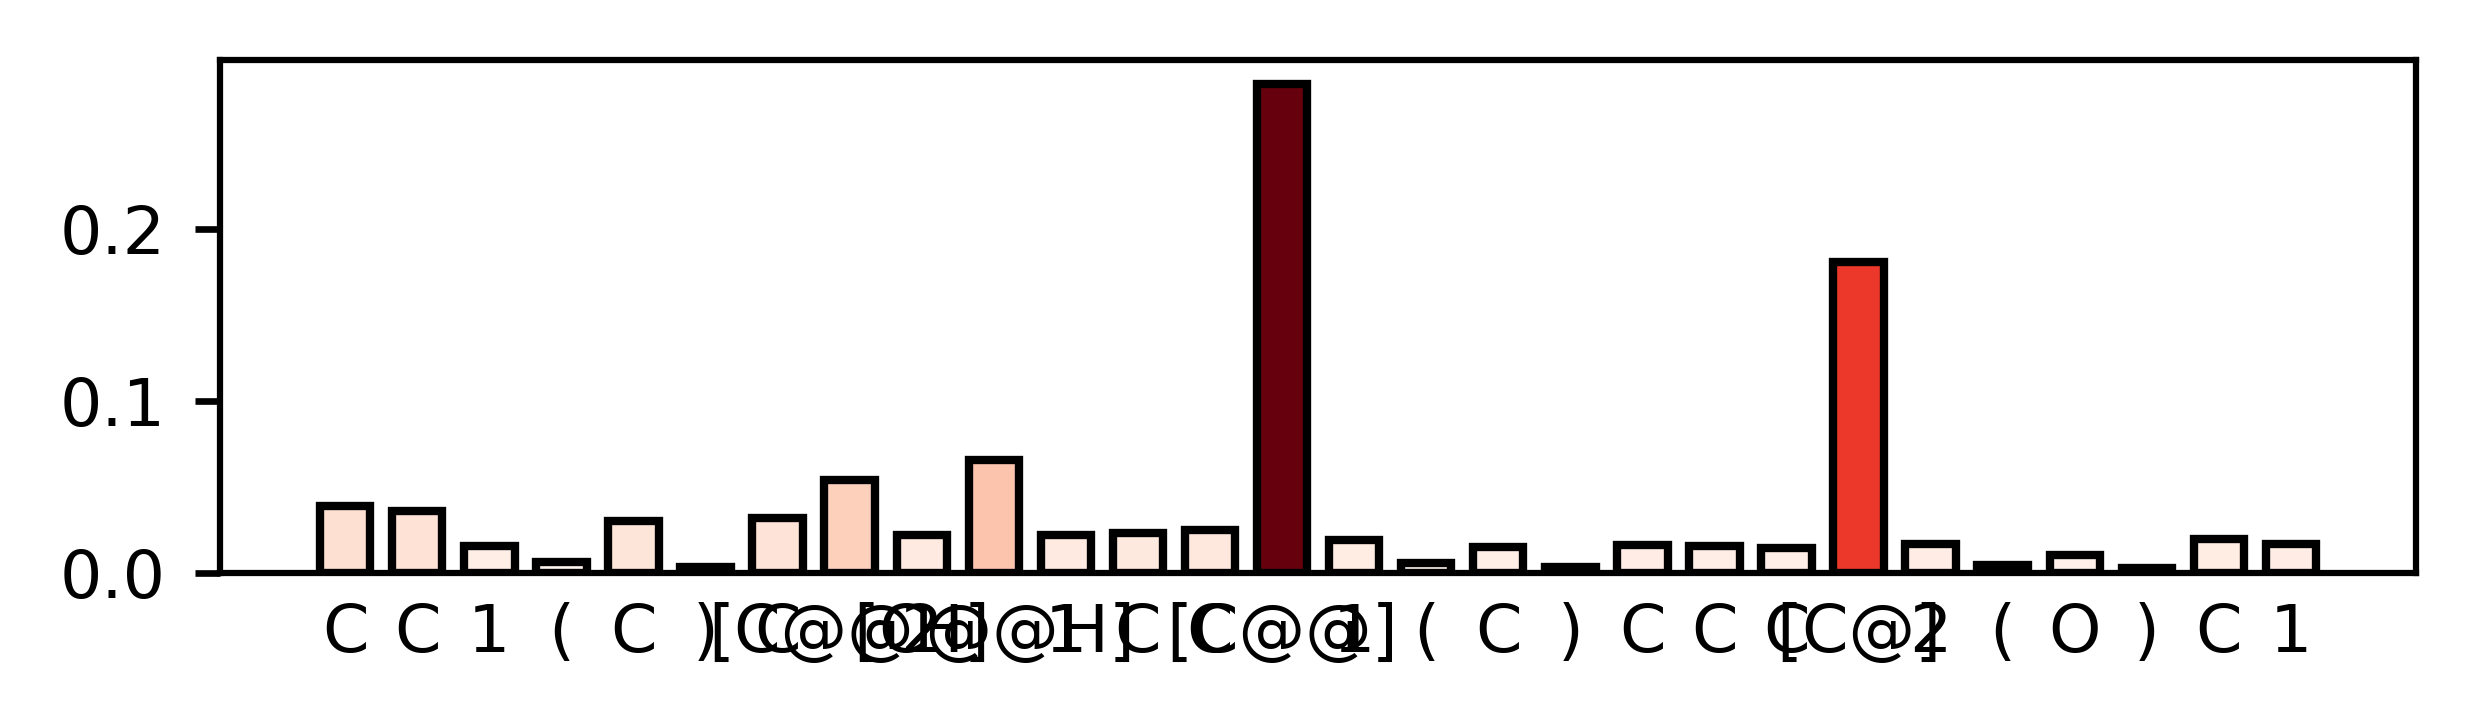

In [ ]:
def smiles_bar(smi, descriptor, figsize = (300/72,90/72), save_path = None):
        assert len(smi) == len(descriptor)
        ticks, values = smi, descriptor
        normalize = plt.Normalize(vmin=min(values), vmax=max(values))
        colors = plt.cm.Reds(normalize(values))  

        fig, ax = plt.subplots(figsize=figsize)

        bars = plt.bar(range(len(values)), values, color=colors, edgecolor='black', width = 0.7)

        plt.xticks(range(len(values)), ticks, rotation=0, fontsize=8)
        ax.tick_params(axis='x', rotation=0, labelrotation=0, length=0)  
        sm = plt.cm.ScalarMappable(cmap='Reds', norm=normalize)
        sm.set_array([])

        plt.tight_layout()
        if save_path is not None:
                plt.savefig(save_path, format='pdf')
        plt.show()
smiles_bar(ticks, _1d_attention , save_path = os.path.join("./figures", f"{BGC_num}_MAP.pdf"))


In [ ]:
import json
def generate_json(string, sequence, scores, compound_name="abyssomicin"):
    data = [
        {
            "string": string,
            "sequence": sequence,
            "methods": [
                {
                    "name": "attention score",
                    "scores": scores
                }
            ],
            "attributes": {
                "Compound Name": compound_name
            }
        }
    ]
    return data

def save_to_json(data, filename="output.json"):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)

json_data = generate_json(smiles, split, _1d_attention)

save_to_json(json_data, os.path.join("visualization", "json", f"{BGC_num}.json"))


### Figure 5 Draw molecular

In [ ]:
import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import AllChem
from PIL import Image

# Cookbook : https://www.rdkit.org/docs/Cookbook.html#drawing-molecules-jupyter
# Another tutorial : https://gist.github.com/HelloJocelynLu/f115fc1624730da7f045a60095976ea4

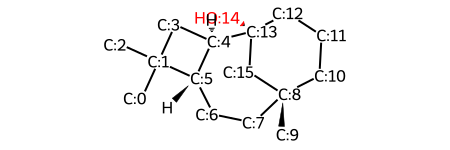

In [ ]:
def show_ids(smi):
    mol=Chem.MolFromSmiles(smi)
    mol = rdkit.Chem.RemoveHs(mol)
    for i, atom in enumerate(mol.GetAtoms()):
        atom.SetProp('molAtomMapNumber',str(i))
    return Chem.MolToSmiles(mol, canonical=True), mol 

show_ids(smiles)[1]

# 1 2 3 4 5 8 13

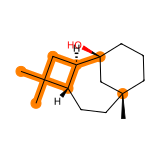

In [ ]:
def draw_molecule(smi, highlight_atoms, save_path):
    mol = Chem.MolFromSmiles(smi)
    mol = rdkit.Chem.RemoveHs(mol)
    highlight_atoms =  highlight_atoms
    highlight_bonds = []

    for bond in mol.GetBonds():
        start = bond.GetBeginAtomIdx()
        end = bond.GetEndAtomIdx()
        if start in highlight_atoms and end in highlight_atoms:
            highlight_bonds.append(bond.GetIdx())

    drawer = rdkit.Chem.Draw.rdMolDraw2D.MolDraw2DSVG(160, 160) 
    opts = drawer.drawOptions()

    #opts.useBWAtomPalette()  
    opts.bondLineWidth = 3.0  
    opts.multipleBondOffset = 0.15  
    opts.padding = 0.1 
    opts.fixedScale = 0.5  
    opts.fontScale = 0.8  
    opts.scaleBondWidth = True  

    # 绘制分子
    drawer.DrawMolecule(
        mol,
        highlightAtoms=highlight_atoms, 
        highlightBonds=highlight_bonds,
        highlightAtomColors={i: (1, 0.5, 0) for i in highlight_atoms}, 
        highlightBondColors={i: (1, 0.5, 0) for i in highlight_bonds}
    )
    drawer.FinishDrawing()

    svg_data = drawer.GetDrawingText()
    
    if save_path is not None:
        with open(save_path, 'w') as f:
            f.write(svg_data)

    from IPython.display import SVG, display
    display(SVG(svg_data))

# highlight_atoms = [2, 3, 15, 19, 20] #693
# highlight_atoms = [6, 8, 13, 14, 20, 19, 24, 2, 3] #1790
highlight_atoms = [0, 1, 2, 3, 4, 5, 8, 13]
save_path = os.path.join("visualization", "molecule", f"{BGC_num}.svg")
draw_molecule(smiles, highlight_atoms, save_path)